# Credit Risk Analysis Using Machine Learning Models


<b>Business Objective:<b>
    The project's primary goal is to predict credit defaulters as loan providers find it difficult 
to give loans due to inconsistencies in credit histories. As a result, the majority of clients 
accept the risk of defaulting, and loan providers struggle to find the proper customer.
    
The project highlights that it's critical to check data quality (by excluding redundant variables during the preparation and cleaning phase) and to deal with an imbalanced training dataset to avoid bias in majority class.

We shall also indicate that the features chosen to meet the business objective ( Can we make this decision with only a few features to save time?)   and the algorithm applied to make the decision (whether the borrower defaults or not ) are two important keys in the decision management processing when issuing a loan (here,
the bank).

In [1]:
''' IMPORT REQUIRED LIBRARIES '''
    
''' Numpy ''' 
import numpy as np
##----------------------------------------------------------------------------------------------------------------------------
''' Pandas ''' 
import pandas as pd
##----------------------------------------------------------------------------------------------------------------------------
''' Matplotlib '''
# import pyplot subpackage 
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
##----------------------------------------------------------------------------------------------------------------------------
''' Seaborn ''' 
import seaborn as sns
##----------------------------------------------------------------------------------------------------------------------------
''' Scipy '''
# import 'stats' module
import scipy.stats as st
##----------------------------------------------------------------------------------------------------------------------------
''' Sklearn '''
# import SimpleImputer
from sklearn.impute import SimpleImputer 
# import the LabelEncoder
from sklearn.preprocessing import LabelEncoder
# import PowerTransformer
from sklearn.preprocessing import PowerTransformer
# import Kfold cross-validator
from sklearn.model_selection import KFold
# import cross_val_score
from sklearn.model_selection import cross_val_score
# import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
# import RFE abd RFECV
from sklearn.feature_selection import RFE,RFECV
# import LogisticRegression
from sklearn.linear_model import LogisticRegression
# import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
# import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
# import XGBClassifier
from xgboost import XGBClassifier
# import GaussianNB
from sklearn.naive_bayes import GaussianNB
# import Pipeline
from sklearn.pipeline import Pipeline
# import train_test_split
from sklearn.model_selection import train_test_split
# import different scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler
# import GridSearchCV
from sklearn.model_selection import GridSearchCV
# import elastic net regularization function
from sklearn.linear_model import ElasticNet
# import VarianceThreshold
from sklearn.feature_selection import VarianceThreshold
# import metrics from sklearn
from sklearn import metrics
# import classification_report
from sklearn.metrics import classification_report
# import cohen_kappa_score
from sklearn.metrics import cohen_kappa_score
# import confusion_matrix
from sklearn.metrics import confusion_matrix
# import roc_curve
from sklearn.metrics import roc_curve
# import accuracy_score
from sklearn.metrics import accuracy_score
# import tree
from sklearn import tree
##----------------------------------------------------------------------------------------------------------------------------
''' Pydotplus '''
import pydotplus
##----------------------------------------------------------------------------------------------------------------------------
''' IPython '''
from IPython.display import Image
##----------------------------------------------------------------------------------------------------------------------------
''' Imblearn '''
# import 'SMOTE'
from imblearn.over_sampling import SMOTE

##----------------------------------------------------------------------------------------------------------------------------
''' Statsmodels '''
# import variance_inflation_factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
# import statsmodels api module 
import statsmodels.api as sm

##----------------------------------------------------------------------------------------------------------------------------
''' Configurations '''
## display all rows of the dataframe
pd.set_option("display.max_rows",200)
## display all columns of the dataframe
pd.set_option("display.max_columns",None)
## set the plot size using 'rcParams'
plt.rcParams["figure.figsize"] = [15,10]

# to suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# import random
import random

# define class to customize print statements
class style:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# create & store random colors for 'color' parameter in visualization
color_codes = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(50)]

##---------------------------------------------------------------------------------------------------------------------------- 

# 1) EXPLORATORY DATA ANALYSIS (EDA)

In [17]:
%%time
''' ## CUSTOM FUNCTIONS '''

def fetch_raw_data():
    # import dataset
    return pd.read_csv('application_train.csv')

##---------------------------------------------------------------------------------------------------------------------------
# define function to categorize into numerical and categorical features
def categorize_features(df):
    #create a list to select categorical features which start with the string
    categorical_like_list = ['TARGET','NAME','CODE','FLAG','CNT','REGION_RATING','OCCUPATION','WEEKDAY',
                      'REG_REGION','LIVE_REGION','REG_CITY','LIVE_CITY','ORGANIZATION', 'CATEGORY_']
    #create a list to select numerical features which start or end with the string
    numerical_like_list = ['AMT','REGION_POPULATION','DAYS','HOUR_APPR','EXT_SOURCE','OBS','DEF',
                           'CAR_AGE','_AVG','_MEDI','_MODE','SCORE_', 'RATIO_']
    
    global categorical_columns
    categorical_columns = [feature for feature in df.columns for string in categorical_like_list if feature.startswith(string)]
    categorical_columns.sort()
    global numerical_columns
    numerical_columns = [feature for feature in df.columns for string in numerical_like_list 
                         if feature.startswith(string) | feature.endswith(string)]
    numerical_columns.sort()
    #select document submission features
    global document_features
    document_features = [feature for feature in df.columns if feature.startswith('FLAG_DOCUMENT_')]
##----------------------------------------------------------------------------------------------------------------------------
# define function to clean data    
def cleanse_dataset(df):
    
    # drop the feature 'SK_ID_CURR'
    if 'SK_ID_CURR' in df.columns:
         df.drop('SK_ID_CURR',axis=1, inplace=True)
    ##----------------------------------------------------------------------------------------------------------------------------
    print(style.BOLD+style.RED+"Cleansing the dataset"+style.END)
    print('Shape before dropping columns having more than 40% missing data:', df.shape)
    # calculate missing value percentage
    missing_data_percentage = ((df.isna().sum()*100)/len(df)).sort_values(ascending=False)
    print('Missing value Percentage')
    display(pd.DataFrame(missing_data_percentage).T)
    # select columns having more than 40% missing data
    missing_above_40_percentage_cols = list(missing_data_percentage[missing_data_percentage>40].index.values)
    # display details
    print("No.of columns with more than 40% missing values:", len(missing_above_40_percentage_cols))
    # dropping columns having more than 40% missing data
    df.drop(missing_above_40_percentage_cols,axis=1, inplace=True)
    print('Shape after dropping columns having more than 40% missing data:', df.shape)
    ##----------------------------------------------------------------------------------------------------------------------------
    #Checking for duplicates in the data.
    df[df.duplicated(subset = list(df.columns), keep=False)]
    print('No.of duplicates in the data:',df[df.duplicated(subset = list(df.columns), keep=False)].shape[0])
    ##----------------------------------------------------------------------------------------------------------------------------
    # Observe that the values in the below features are negative. 
    # Since days count cannot be negative, let's convert the data into positive values.
    df['DAYS_LAST_PHONE_CHANGE'] = np.abs(df['DAYS_LAST_PHONE_CHANGE'])
    df['DAYS_BIRTH'] = np.abs(df['DAYS_BIRTH'])
    df['DAYS_REGISTRATION'] = np.abs(df['DAYS_REGISTRATION'])
    df['DAYS_ID_PUBLISH'] = np.abs(df['DAYS_ID_PUBLISH'])
    df['DAYS_EMPLOYED'] = np.abs(df['DAYS_EMPLOYED'])
    ##----------------------------------------------------------------------------------------------------------------------------
    # Update numerical and categorical columns lists
    categorize_features(df)
    print("Total number of categorical features after cleansing the data: ", len(categorical_columns))
    print("Total number of numerical features after cleansing the data: ", len(numerical_columns))
    
    return df
##---------------------------------------------------------------------------------------------------------------------------- 

# define a function to start EDA
def init():
## Initialize df_credit (dataframe used for EDA in this project)
    global df_credit              
    df_credit = fetch_raw_data() 
    
## Check Shape
    print(style.BOLD+style.RED+"Shape of the dataset: "+style.END)
    print(df_credit.shape)
## Check head
    print(style.BOLD+style.RED+"View first five observations"+style.END)
    display(df_credit.head())
## Check data types
    print(style.BOLD+style.RED+"Check data types: "+style.END)
    #use info() to understand the dataset
    display(df_credit.select_dtypes(np.number).dtypes)
    display(df_credit.select_dtypes(object).dtypes)
## Descriptive Statistics
    #use describe to display descriptive statistics
    print(style.BOLD+style.RED+"Descriptive statistics "+style.END)
    display(df_credit.describe(include='all'))
## Clean the dataset
    cleanse_dataset(df_credit)

init()

Shape of the dataset: 
(307511, 122)
View first five observations


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

Check data types: 


SK_ID_CURR                        int64
TARGET                            int64
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64
FLAG_CONT_MOBILE                  int64
FLAG_PHONE                        int64
FLAG_EMAIL                        int64
CNT_FAM_MEMBERS                 float64
REGION_RATING_CLIENT              int64
REGION_RATING_CLIENT_W_CITY       int64
HOUR_APPR_PROCESS_START           int64
REG_REGION_NOT_LIVE_REGION        int64
REG_REGION_NOT_WORK_REGION        int64


NAME_CONTRACT_TYPE            object
CODE_GENDER                   object
FLAG_OWN_CAR                  object
FLAG_OWN_REALTY               object
NAME_TYPE_SUITE               object
NAME_INCOME_TYPE              object
NAME_EDUCATION_TYPE           object
NAME_FAMILY_STATUS            object
NAME_HOUSING_TYPE             object
OCCUPATION_TYPE               object
WEEKDAY_APPR_PROCESS_START    object
ORGANIZATION_TYPE             object
FONDKAPREMONT_MODE            object
HOUSETYPE_MODE                object
WALLSMATERIAL_MODE            object
EMERGENCYSTATE_MODE           object
dtype: object

Descriptive statistics 


SK_ID_CURR         TARGET NAME_CONTRACT_TYPE CODE_GENDER  \
count   307511.000000  307511.000000             307511      307511   
unique            NaN            NaN                  2           3   
top               NaN            NaN         Cash loans           F   
freq              NaN            NaN             278232      202448   
mean    278180.518577       0.080729                NaN         NaN   
std     102790.175348       0.272419                NaN         NaN   
min     100002.000000       0.000000                NaN         NaN   
25%     189145.500000       0.000000                NaN         NaN   
50%     278202.000000       0.000000                NaN         NaN   
75%     367142.500000       0.000000                NaN         NaN   
max     456255.000000       1.000000                NaN         NaN   

       FLAG_OWN_CAR FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count        307511          307511  307511.000000      3.075110e+05   
unique            2               2            NaN               NaN   
top               N               Y            NaN               NaN   
freq         202924          213312            NaN               NaN   
mean            NaN             NaN       0.417052      1.687979e+05   
std             NaN             NaN       0.722121      2.371231e+05   
min             NaN             NaN       0.000000      2.565000e+04   
25%             NaN             NaN       0.000000      1.125000e+05   
50%             NaN             NaN       0.000000      1.471500e+05   
75%             NaN             NaN       1.000000      2.025000e+05   
max             NaN             NaN      19.000000      1.170000e+08   

          AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
count   3.075110e+05  307499.000000     3.072330e+05          306219   
unique           NaN            NaN              NaN               7   
top              NaN            NaN              NaN   Unaccompanied   
freq             NaN            NaN              NaN          248526   
mean    5.990260e+05   27108.573909     5.383962e+05             NaN   
std     4.024908e+05   14493.737315     3.694465e+05             NaN   
min     4.500000e+04    1615.500000     4.050000e+04             NaN   
25%     2.700000e+05   16524.000000     2.385000e+05             NaN   
50%     5.135310e+05   24903.000000     4.500000e+05             NaN   
75%     8.086500e+05   34596.000000     6.795000e+05             NaN   
max     4.050000e+06  258025.500000     4.050000e+06             NaN   

       NAME_INCOME_TYPE            NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  \
count            307511                         307511             307511   
unique                8                              5                  6   
top             Working  Secondary / secondary special            Married   
freq             158774                         218391             196432   
mean                NaN                            NaN                NaN   
std                 NaN                            NaN                NaN   
min                 NaN                            NaN                NaN   
25%                 NaN                            NaN                NaN   
50%                 NaN                            NaN                NaN   
75%                 NaN                            NaN                NaN   
max                 NaN                            NaN                NaN   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE     DAYS_BIRTH  \
count              307511               307511.000000  307511.000000   
unique                  6                         NaN            NaN   
top     House / apartment                         NaN            NaN   
freq               272868                         NaN            NaN   
mean                  NaN                    0.020868  -16036.995067   
std                   NaN                    0.013831    4363.988632   

Cleansing the dataset
Shape before dropping columns having more than 40% missing data: (307511, 121)
Missing value Percentage


COMMONAREA_MEDI  COMMONAREA_AVG  COMMONAREA_MODE  NONLIVINGAPARTMENTS_MODE  \
0        69.872297       69.872297        69.872297                 69.432963   

   NONLIVINGAPARTMENTS_MEDI  NONLIVINGAPARTMENTS_AVG  FONDKAPREMONT_MODE  \
0                 69.432963                69.432963           68.386172   

   LIVINGAPARTMENTS_MEDI  LIVINGAPARTMENTS_MODE  LIVINGAPARTMENTS_AVG  \
0              68.354953              68.354953             68.354953   

   FLOORSMIN_AVG  FLOORSMIN_MEDI  FLOORSMIN_MODE  YEARS_BUILD_MEDI  \
0       67.84863        67.84863        67.84863         66.497784   

   YEARS_BUILD_MODE  YEARS_BUILD_AVG  OWN_CAR_AGE  LANDAREA_AVG  \
0         66.497784        66.497784     65.99081     59.376738   

   LANDAREA_MEDI  LANDAREA_MODE  BASEMENTAREA_AVG  BASEMENTAREA_MODE  \
0      59.376738      59.376738         58.515956          58.515956   

   BASEMENTAREA_MEDI  EXT_SOURCE_1  NONLIVINGAREA_MEDI  NONLIVINGAREA_AVG  \
0          58.515956     56.381073           55.179164          55.179164   

   NONLIVINGAREA_MODE  ELEVATORS_AVG  ELEVATORS_MEDI  ELEVATORS_MODE  \
0           55.179164       53.29598        53.29598        53.29598   

   WALLSMATERIAL_MODE  APARTMENTS_MODE  APARTMENTS_MEDI  APARTMENTS_AVG  \
0           50.840783        50.749729        50.749729       50.749729   

   ENTRANCES_MEDI  ENTRANCES_MODE  ENTRANCES_AVG  LIVINGAREA_MEDI  \
0       50.348768       50.348768      50.348768        50.193326   

   LIVINGAREA_MODE  LIVINGAREA_AVG  HOUSETYPE_MODE  FLOORSMAX_AVG  \
0        50.193326       50.193326       50.176091      49.760822   

   FLOORSMAX_MEDI  FLOORSMAX_MODE  YEARS_BEGINEXPLUATATION_AVG  \
0       49.760822       49.760822                    48.781019   

   YEARS_BEGINEXPLUATATION_MEDI  YEARS_BEGINEXPLUATATION_MODE  TOTALAREA_MODE  \
0                     48.781019                     48.781019       48.268517   

   EMERGENCYSTATE_MODE  OCCUPATION_TYPE  EXT_SOURCE_3  \
0            47.398304        31.345545     19.825307   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  \
0                  13.501631                   13.501631   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_DAY  \
0                   13.501631                  13.501631   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_MON  NAME_TYPE_SUITE  \
0                   13.501631                  13.501631         0.420148   

   OBS_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE  \
0                  0.332021                  0.332021   

   DEF_60_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  EXT_SOURCE_2  \
0                  0.332021                  0.332021      0.214626   

   AMT_GOODS_PRICE  AMT_ANNUITY  CNT_FAM_MEMBERS  DAYS_LAST_PHONE_CHANGE  \
0         0.090403     0.003902          0.00065                0.000325   

   AMT_CREDIT  AMT_INCOME_TOTAL  NAME_CONTRACT_TYPE  FLAG_EMAIL  FLAG_PHONE  \
0         0.0               0.0                 0.0         0.0         0.0   

   FLAG_CONT_MOBILE  FLAG_WORK_PHONE  FLAG_EMP_PHONE  FLAG_MOBIL  CODE_GENDER  \
0               0.0              0.0             0.0         0.0          0.0   

   FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  DAYS_ID_PUBLISH  \
0           0.0              0.0           0.0              0.0   

   DAYS_REGISTRATION  DAYS_EMPLOYED  DAYS_BIRTH  REGION_POPULATION_RELATIVE  \
0                0.0            0.0         0.0                         0.0   

   REGION_RATING_CLIENT  NAME_FAMILY_STATUS  NAME_EDUCATION_TYPE  \
0                   0.0                 0.0                  0.0   

   NAME_INCOME_TYPE  NAME_HOUSING_TYPE  REG_REGION_NOT_LIVE_REGION  \
0               0.0                0.0                         0.0   

   REGION_RATING_CLIENT_W_CITY  WEEKDAY_APPR_PROCESS_START  FLAG_DOCUMENT_2  \
0                          0.0                         0.0              0.0   

   FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
0              0.0              0.0          

No.of columns with more than 40% missing values: 49
Shape after dropping columns having more than 40% missing data: (307511, 72)
No.of duplicates in the data: 0
Total number of categorical features after cleansing the data:  49
Total number of numerical features after cleansing the data:  23
Wall time: 8.95 s


## Univariate Analysis

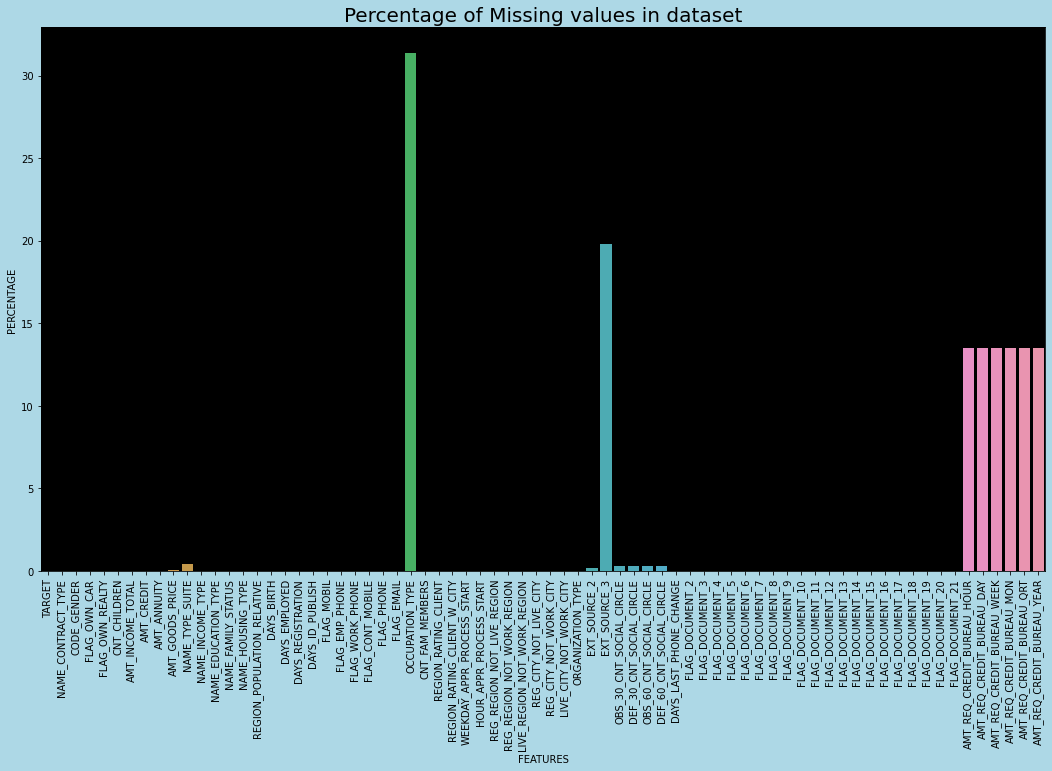

Wall time: 4.99 s


In [6]:
%%time
# set figuresize
fig = plt.figure(figsize=(18,10))

# calculate & store missing data percentage in a dataframe
df_missing_data = pd.DataFrame((df_credit.isnull().sum())*100/df_credit.shape[0]).reset_index()

# create barplot
ax = sns.barplot("index",0,data=df_missing_data)
plt.xticks(rotation =90,fontsize =10)
plt.title("Percentage of Missing values in dataset", fontdict={'fontsize':20})
plt.ylabel("PERCENTAGE")
plt.xlabel("FEATURES")
ax.set_facecolor("black")
fig.set_facecolor("lightblue")
plt.show()

<b> Observations:
The above visualization shows us that after the removal of null values above 40% then the feature with maximum null value % is OCCUPATION_TYPE feature.
Features like EXT_SOURCE_3 too has null values around 20%
Features like AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR' also show around 13% of missing values.  

<b>

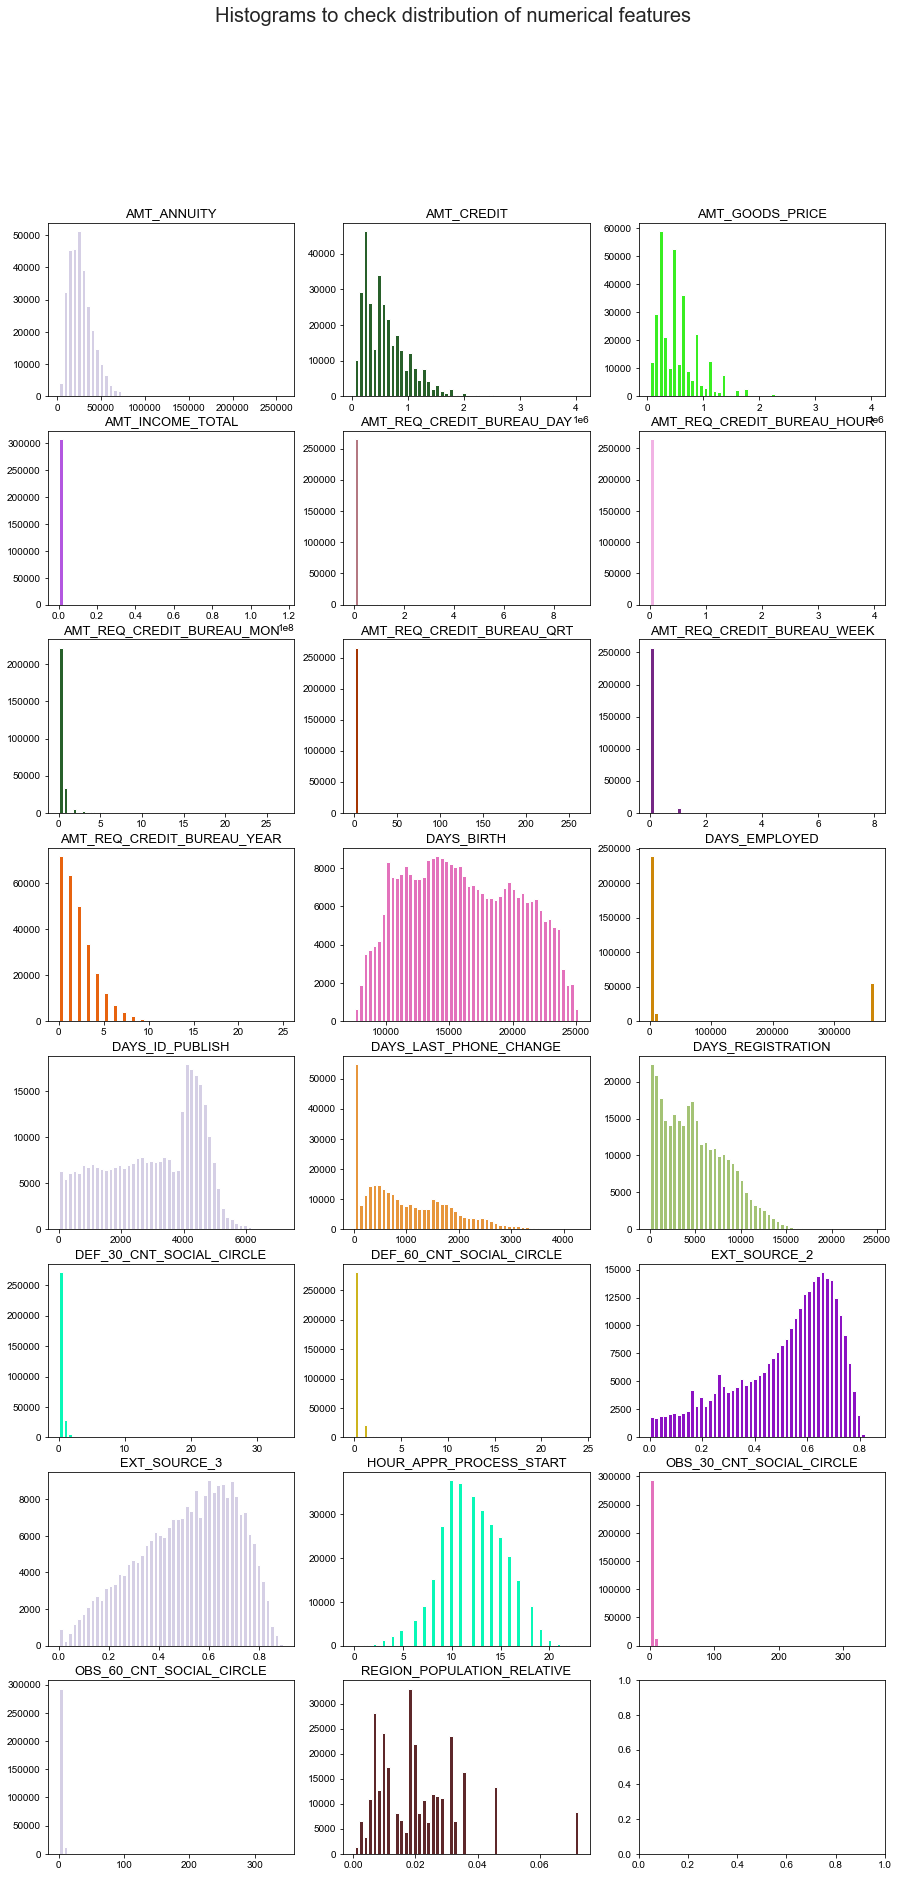

Wall time: 8.22 s


In [7]:
%%time
# create subplots
fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(15,30))
# create histograms for each numerical feature
for feature, ax in zip(numerical_columns, axs.flatten()):
    sns.set_theme(style="whitegrid")
    ax.hist(df_credit[feature], bins=50, rwidth=0.8, color= random.choice(color_codes))
    ax.set_title(feature,fontsize=13)
plt.suptitle("Histograms to check distribution of numerical features",fontsize=20)
plt.show()

<b> Observations:
The above visualization represents the Histograms to check distribution of numerical features.
From the visualization it can be infered that most of the numerical data are skewed in nature.
Majority of the skewness is right skewness.
<b>

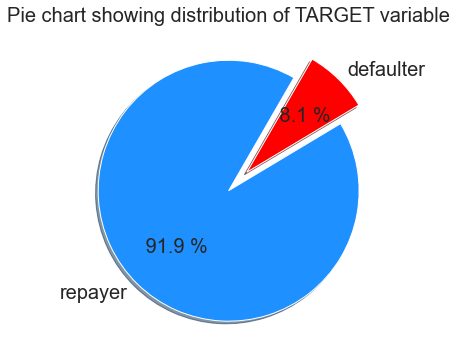

Wall time: 204 ms


In [8]:
%%time
# set figuresize
plt.figure(figsize=(10,6))

# create pie chart
plt.pie(df_credit['TARGET'].value_counts(),autopct ='% 1.1f %%',shadow = True, explode = [0,0.2], labels = ['repayer','defaulter'], startangle = 60, textprops={'fontsize': 20},colors=['dodgerblue','red'])
plt.title("Pie chart showing distribution of TARGET variable", fontdict={'fontsize':20})
plt.show()

<b> Observations:
The above pie chart shows us that 91.9% of people tend to repay the loan amount whereas 8.1% of people were unable to repay the loaned amount.

<b>

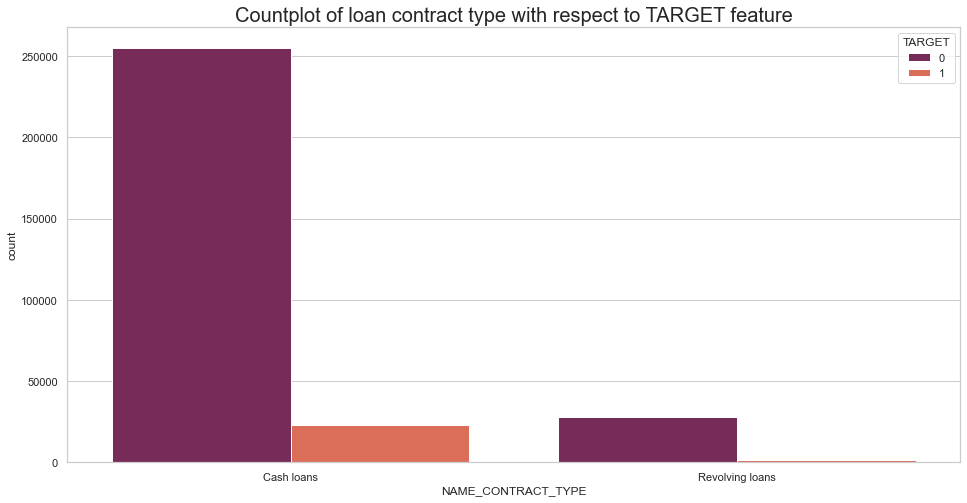

Wall time: 560 ms


In [9]:
%%time
# set figuresize
plt.figure(figsize=(16,8))

# create countplot
sns.set_theme(style="whitegrid")
sns.countplot(data=df_credit,x='NAME_CONTRACT_TYPE',hue='TARGET',palette='rocket')
plt.title("Countplot of loan contract type with respect to TARGET feature", fontdict={'fontsize':20})
plt.show()

<b> Observations:
The number of cash loans are the type of loan that is mostly taken by the people.
It could be seen that number of people that were not able to repay the Cash loan were some what same to the number of people payed the Rsvolving loan type.
    So the number of cash loans are significantly higher than Revolving loans.

<b>

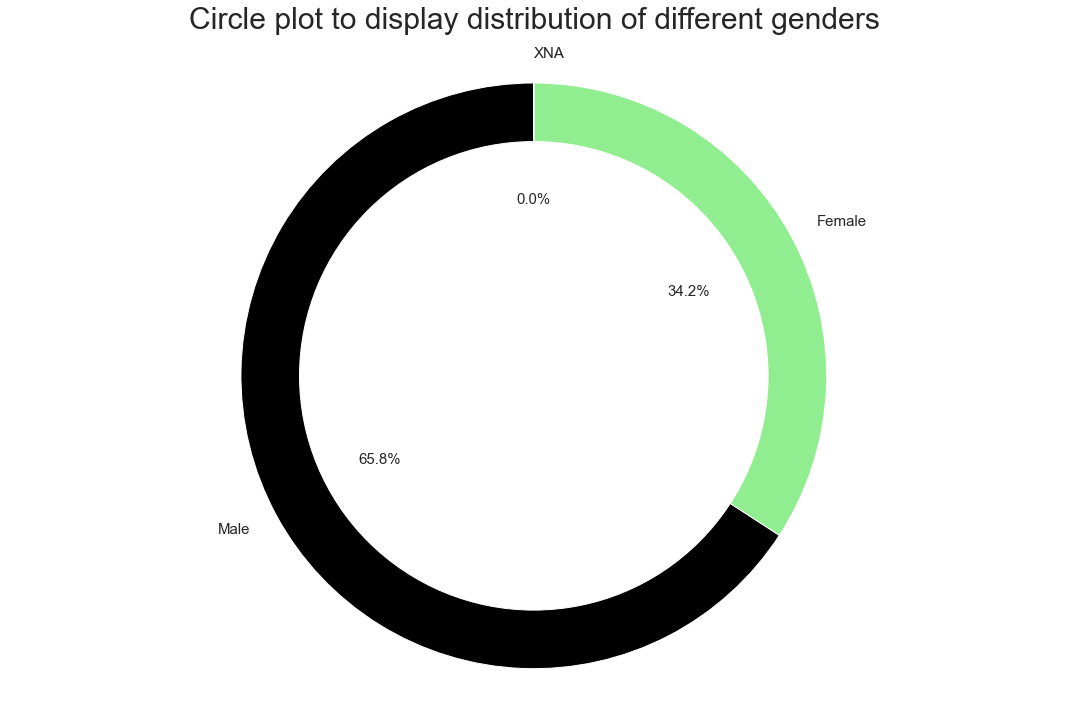

Wall time: 245 ms


In [10]:
%%time
# create subplot
fig, ax = plt.subplots()

# create pie chart on the axis
plt.suptitle("Circle plot to display distribution of different genders",fontsize=30)

ax.pie(df_credit.CODE_GENDER.value_counts(),colors=['black','lightgreen','blue'],labels=['Male','Female',"XNA"],autopct='%1.1f%%',textprops={'fontsize': 15}, startangle=90)
# draw circle
centre_circle = plt.Circle((0,0),0.80,fc='white')

# get current figure
fig = plt.gcf()

# add artist to current axis
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  
plt.tight_layout()
plt.show()

<b> Observations:
The above pie chart tells us that number of Males in applying for loans are greater than number of females that apply for loans. The number of male is approximatly double the female

<b>

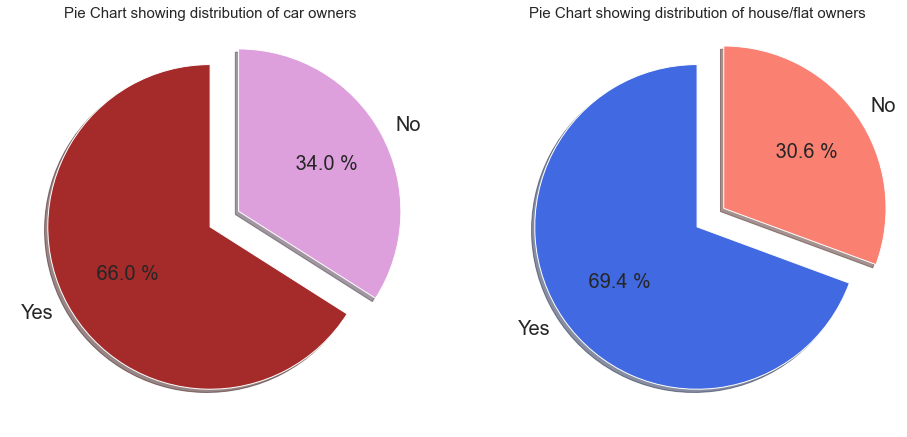

Wall time: 249 ms


In [8]:
%%time
# set figuresize
plt.figure(figsize=(16,8))

# create subplot
plt.subplot(121)
# plot pie diagram 
plt.pie(df_credit['FLAG_OWN_CAR'].value_counts(),autopct ='% 1.1f %%',shadow = True, explode = [0,0.2], labels = ['Yes','No'], startangle = 90, textprops={'fontsize': 20},colors=['brown','plum'])
plt.title("Pie Chart showing distribution of car owners", fontdict={'fontsize':15})

# create subplot
plt.subplot(122)
# plot pie diagram
plt.pie(df_credit['FLAG_OWN_REALTY'].value_counts(),autopct ='% 1.1f %%',shadow = True, explode = [0,0.2], labels = ['Yes','No'], startangle = 90, textprops={'fontsize': 20},colors=['RoyalBlue','Salmon'])
plt.title("Pie Chart showing distribution of house/flat owners", fontdict={'fontsize':15})
plt.show()

<b> Observations:
66% of clients are car owners.
    69% of the clients are house/flat owners.

<b>

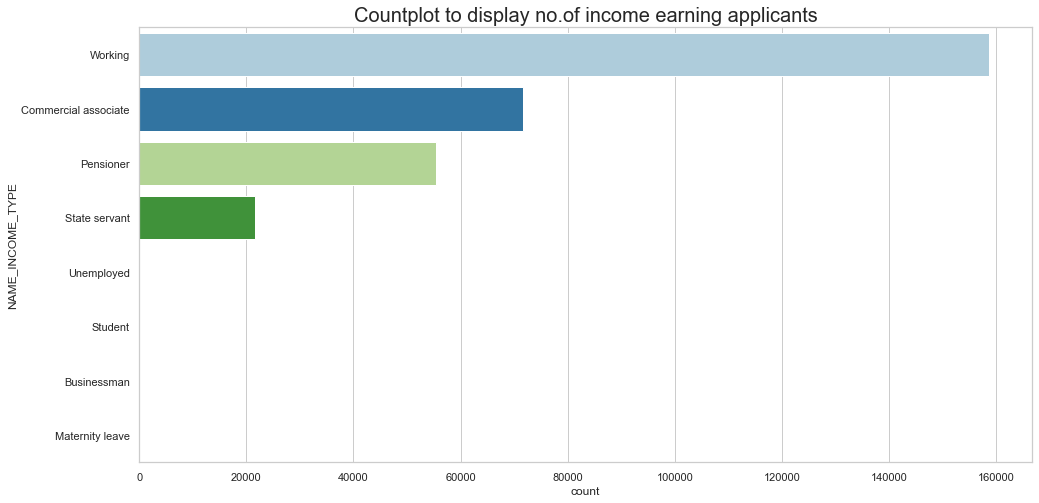

Wall time: 403 ms


In [9]:
%%time
# create countplot
plt.figure(figsize=(16,8))
sns.set_theme(style="whitegrid")
sns.countplot(y=df_credit["NAME_INCOME_TYPE"],palette='Paired',order=df_credit["NAME_INCOME_TYPE"].value_counts().index[:len(df_credit["NAME_INCOME_TYPE"])])
plt.title("Countplot to display no.of income earning applicants", fontdict={'fontsize':20})
plt.show()

<b> Observations:
Working clients have most income as comapred to Commercial associate , Pensioners and State servents. 

<b>

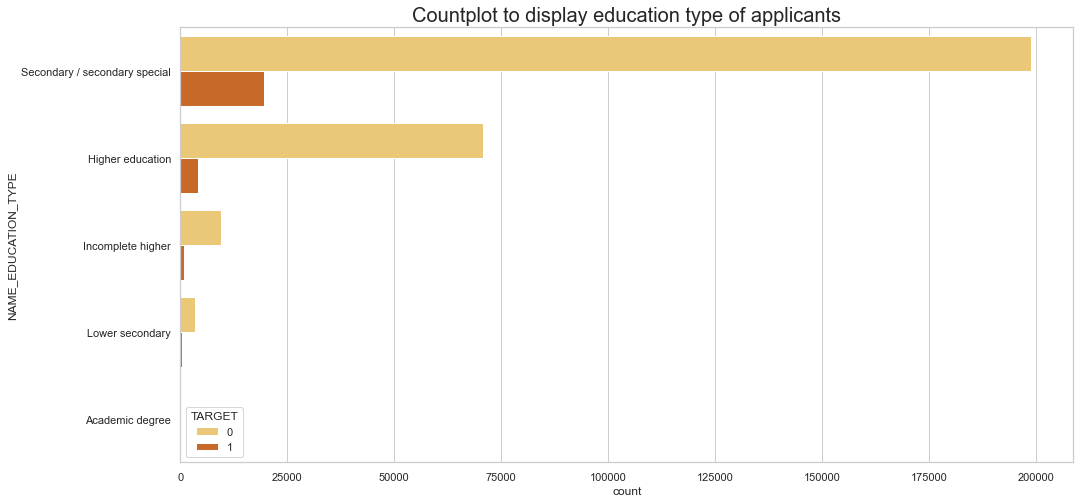

Wall time: 450 ms


In [10]:
%%time
# create countplot
plt.figure(figsize=(16,8))
sns.set_theme(style="whitegrid")
sns.countplot(y=df_credit["NAME_EDUCATION_TYPE"], hue= df_credit.TARGET, palette = 'YlOrBr',order=df_credit["NAME_EDUCATION_TYPE"].value_counts().index[:len(df_credit["NAME_EDUCATION_TYPE"])])
plt.title("Countplot to display education type of applicants", fontdict={'fontsize':20})
plt.show()

<b> Observations:
People with Secondary education are more likely to default the loan and Academic degree holders are least

<b>

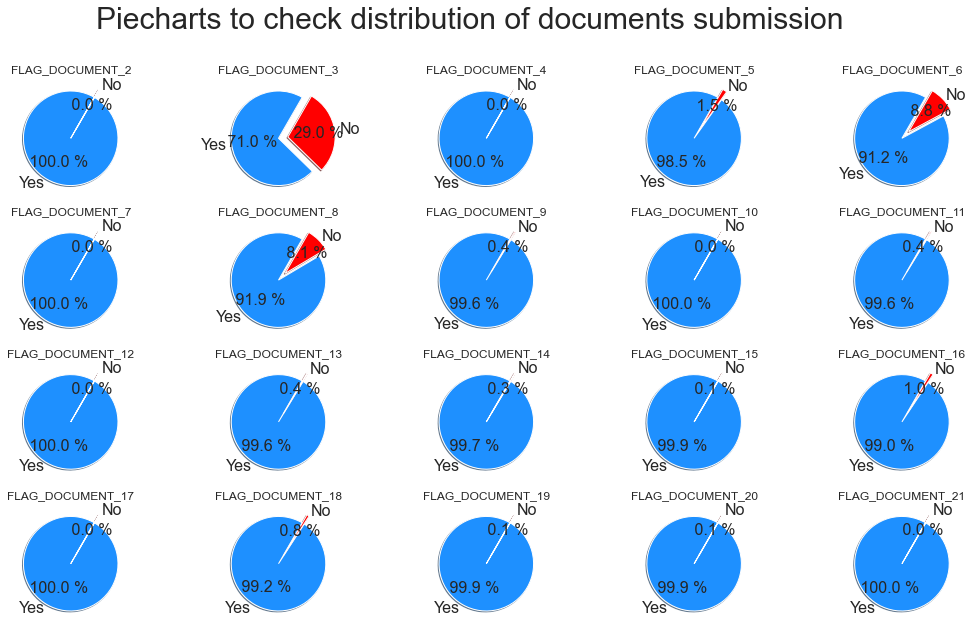

Wall time: 2.55 s


In [11]:
%%time

# create subplots
fig, axs = plt.subplots(4, 5,figsize=(18,10))

# create pie charts for each flag document feature
for index,ax in zip(range(23),axs.ravel()):
    sns.set_theme(style="whitegrid")
    ax.pie(df_credit[document_features].iloc[:,index].value_counts(),autopct ='% 1.1f %%',labels=['Yes','No'],shadow = True, startangle = 60,explode = [0,0.2], textprops={'fontsize': 16},colors=['dodgerblue','red'])
    ax.set_title(document_features[index])
plt.suptitle("Piecharts to check distribution of documents submission",fontsize=30)
plt.show()

<b> Observations:
Clients tend to provide most of the documents asked from them.
    Document 3 seems to have low priority / not important/ optional while providing the document as around 29% of clients are not able to provide that document.

<b>

## Outliers Detection

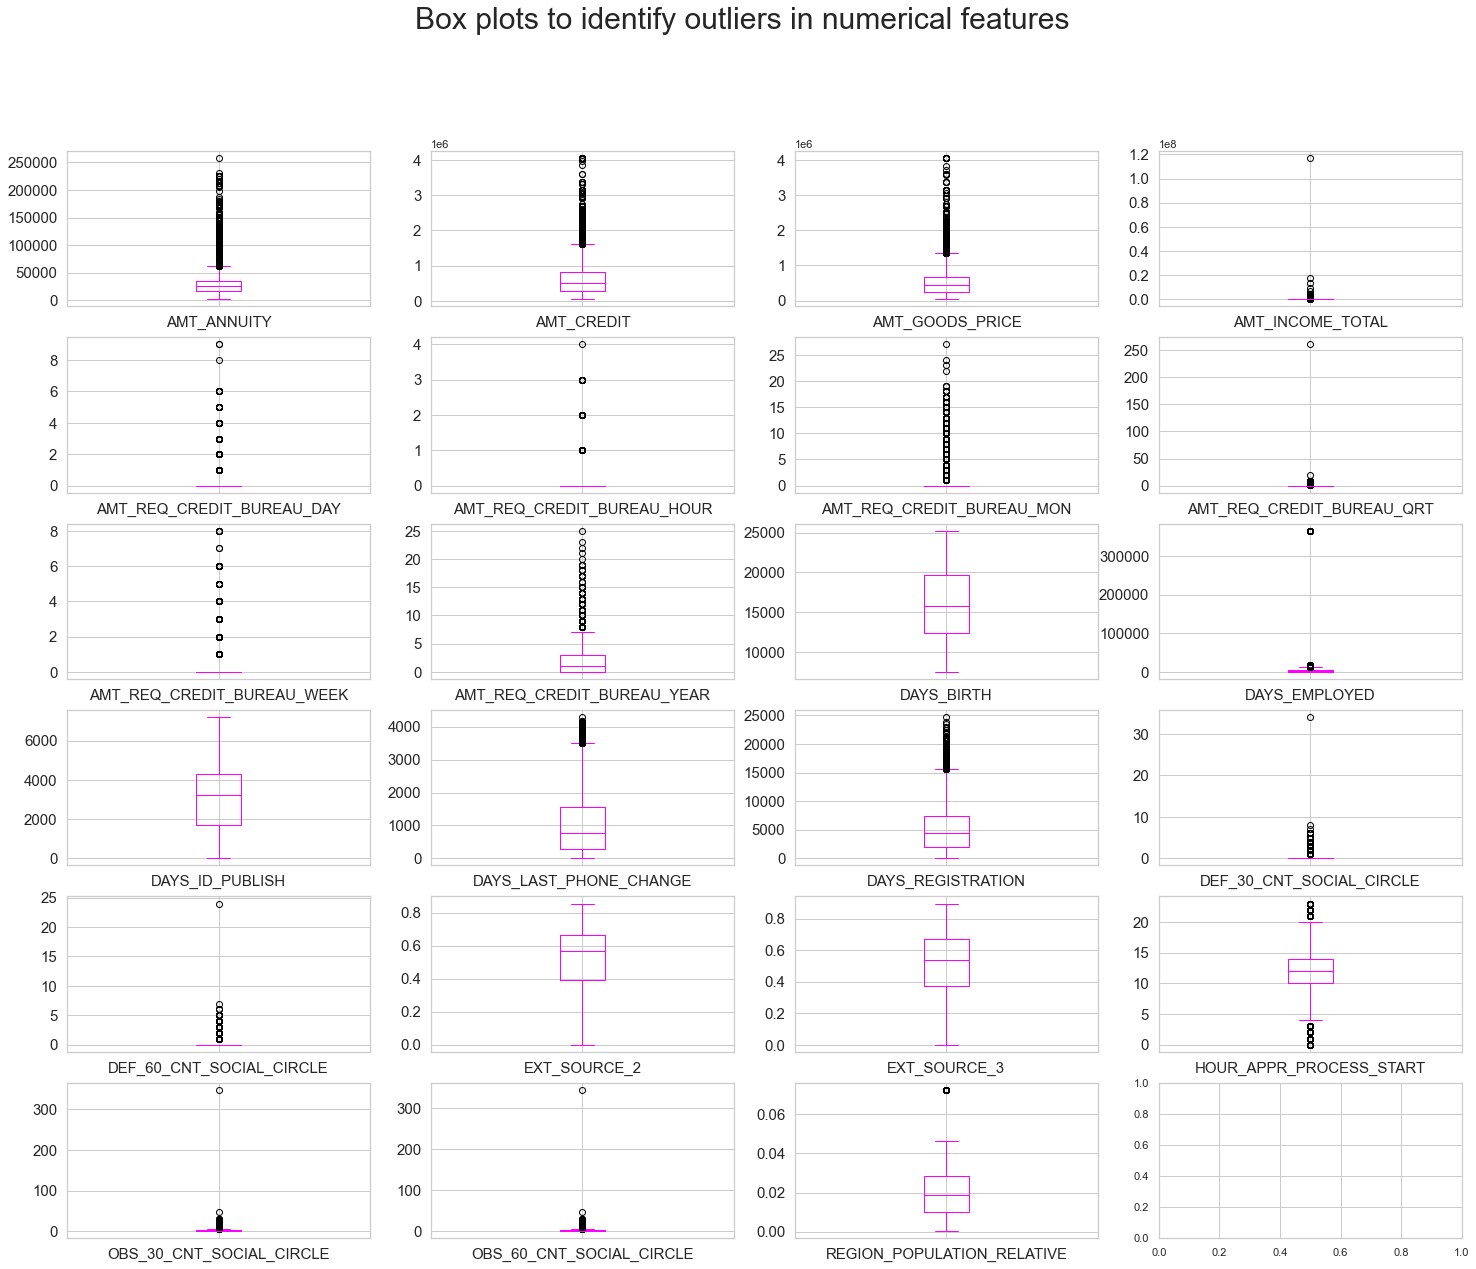

Wall time: 4.82 s


In [12]:
%%time
# check outliers presence using boxplot
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(25,20))
# create boxplot for each numerical column
for feature, ax in zip(numerical_columns, axs.flatten()):
    df_credit[feature].plot(kind='box',ax =ax, color='magenta',grid=True,fontsize=15)
plt.suptitle("Box plots to identify outliers in numerical features",fontsize=30)
plt.show()

<b> Observations:
The above boxplots shows the presence of outliers except the REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_ID_PUBLISH, EXT_SOURCE_2 and EXT_SOURCE_3 feature.

<b>

## Bivariate Analysis

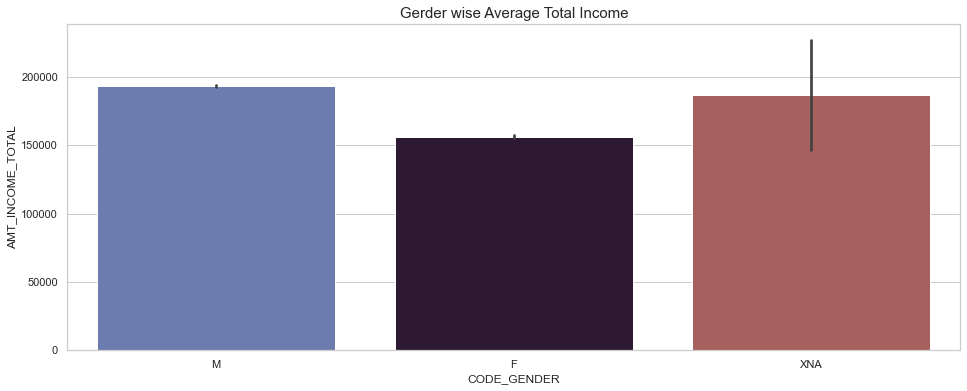

Wall time: 3.58 s


In [13]:
%%time
# create barplot
plt.figure(figsize=(16,6))
sns.set_theme(style="whitegrid")
sns.barplot(data=df_credit, x='CODE_GENDER',y='AMT_INCOME_TOTAL',palette='twilight')
plt.title("Gerder wise Average Total Income",fontdict={'fontsize':15})
plt.show()

<b> Observations:
Males tend to earn more than the females.

<b>

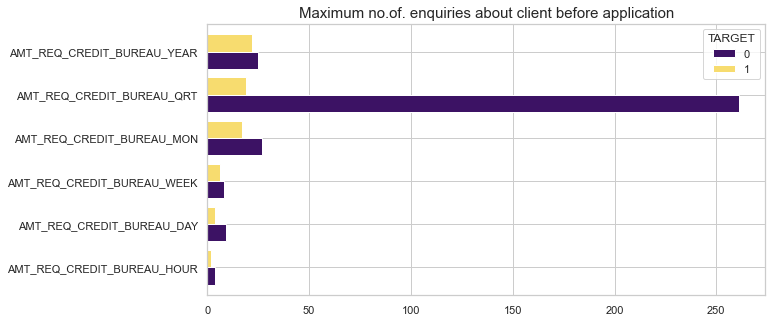

Wall time: 239 ms


In [14]:
%%time
# select credit bureau related features 
amt_columns = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
# create horizontal barplot
sns.set_theme(style="whitegrid")
df_credit.groupby("TARGET")[amt_columns].max().transpose().plot(kind="barh",figsize=(10,5),width=.8, color =['#3C1264','#F7DC6F'])
plt.title("Maximum no.of. enquiries about client before application",fontdict={'fontsize':15})
plt.show()

<b> Observations:
Most number of enquiries to Credit Bureau about the client is done 3 month before application (excluding one month before application).
The ratio of Defaulters and non Defaulters are maximum when the enquiries to Credit Bureau about the client one day year (excluding last 3 months before application).

<b>

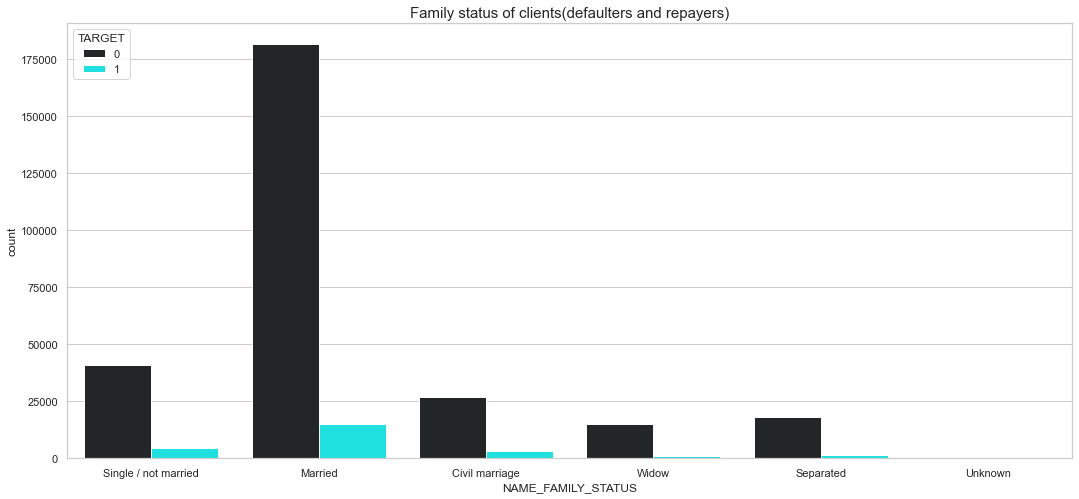

Wall time: 427 ms


In [15]:
%%time
# create countplot
plt.figure(figsize=(18,8))
sns.set_theme(style="whitegrid")
sns.countplot(data= df_credit,x='NAME_FAMILY_STATUS', hue='TARGET',palette='dark:cyan')
plt.title("Family status of clients(defaulters and repayers)",fontdict={'fontsize':15})
plt.show()

<b> Observations:
According to the data the number of Married People tend to apply for the loan the maximum.
    Then Single/Unmarried people tend to apply for the loan.
The least amount of loan are taken by Widows.
<b>

Wall time: 139 ms


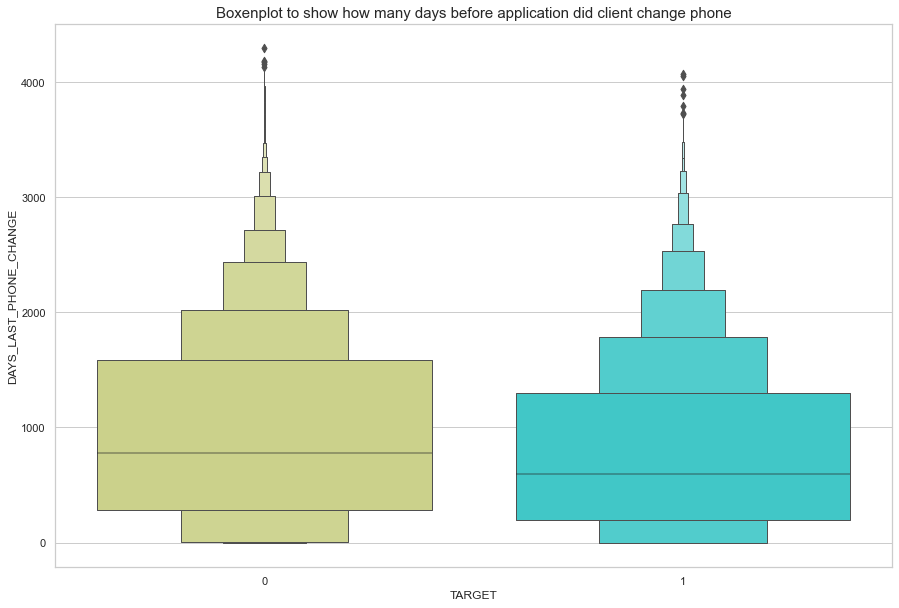

In [16]:
%%time
# create boxenplot
sns.set_theme(style="whitegrid")
ax= sns.boxenplot(df_credit["TARGET"],df_credit["DAYS_LAST_PHONE_CHANGE"],palette='rainbow_r')
ax.set_title("Boxenplot to show how many days before application did client change phone",fontdict={'fontsize':15})
plt.subplots_adjust(wspace = .2)

<b> Observations:
The Average number of days the phone number was changed in case of a repayer is 800 days and for defaulters it is 500-600 days.
    There are prople who have not changed their number for a long time.

<b>

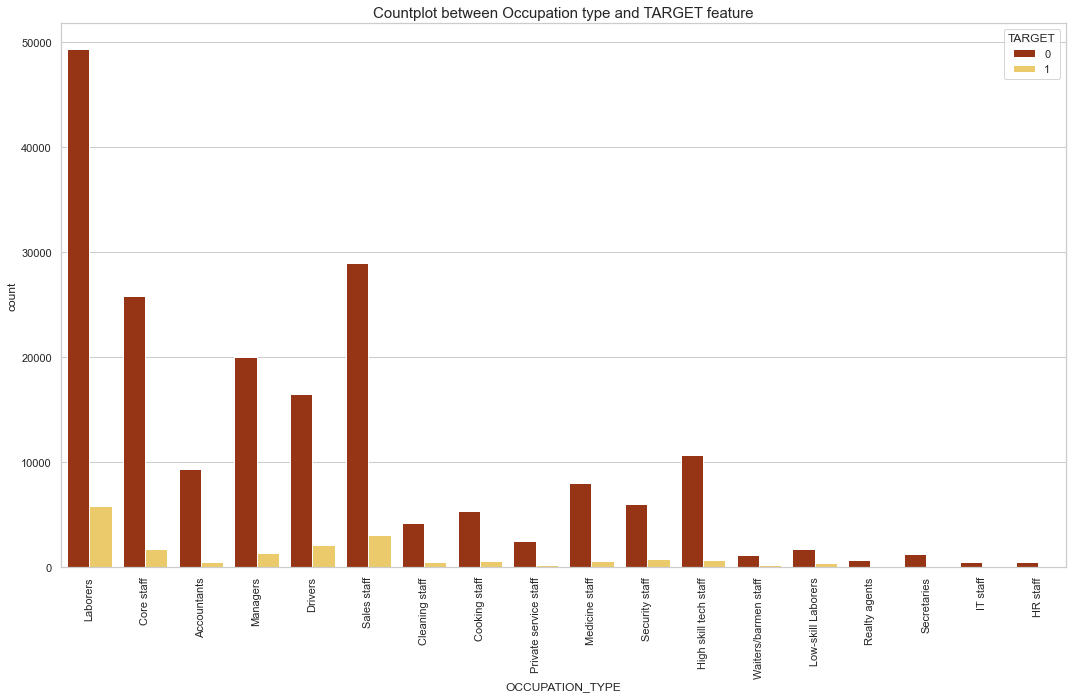

Wall time: 578 ms


In [17]:
%%time
# create countplot
plt.figure(figsize=(18,10))
sns.set_theme(style="whitegrid")
sns.countplot(data=df_credit,x='OCCUPATION_TYPE',hue='TARGET',palette='afmhot')
plt.title("Countplot between Occupation type and TARGET feature",fontdict={'fontsize':15})
plt.xticks(rotation=90)
plt.show()

<b> Observations:
The laborer occupation type has the most number of loans around 49K where as others are at an average of 20K.
Sales Staff is the second occupation that take most number of loans.
IT staff and Reality Agents tend to take less loan.

<b>

Comparison of contact information using countplot


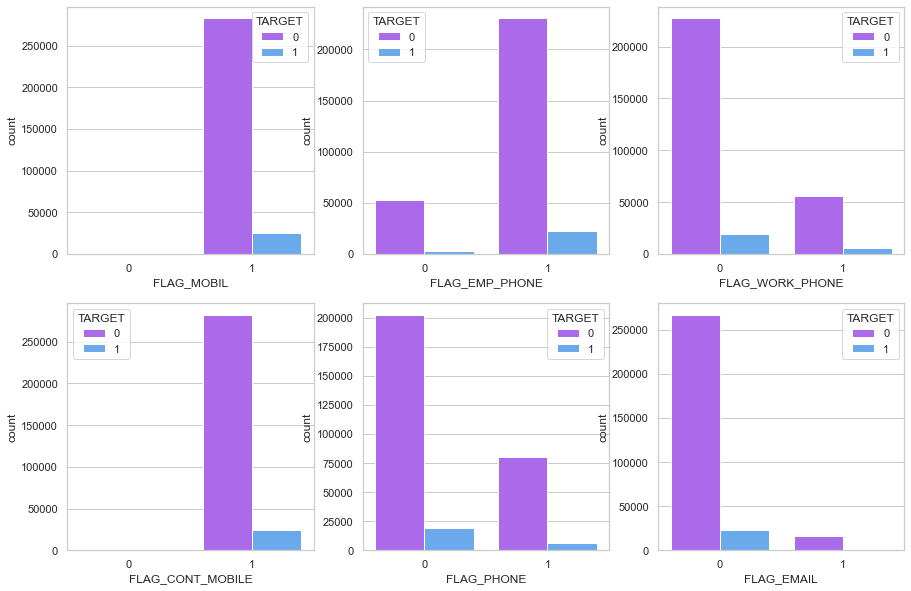

Wall time: 953 ms


In [18]:
%%time
contact_columns= ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE','FLAG_PHONE', 'FLAG_EMAIL']
print(style.BOLD+style.RED+"Comparison of contact information using countplot"+style.END)
for feature,index in zip(contact_columns,range(6)):
    plt.subplot(2,3,index+1)
    sns.set_theme(style="whitegrid")
    sns.countplot(df_credit[feature],hue=df_credit["TARGET"],palette='cool_r')
plt.show()

<b> Observations:
Personal Mobile Number is provided by everyone where as email address is something which is not mostly provided by the loanee.
Most of the mobile phones provided by people was in working and reachable condition.
People did provide their work phone number.
Most of the people tend to have mobile than a common home phone number.
<b>

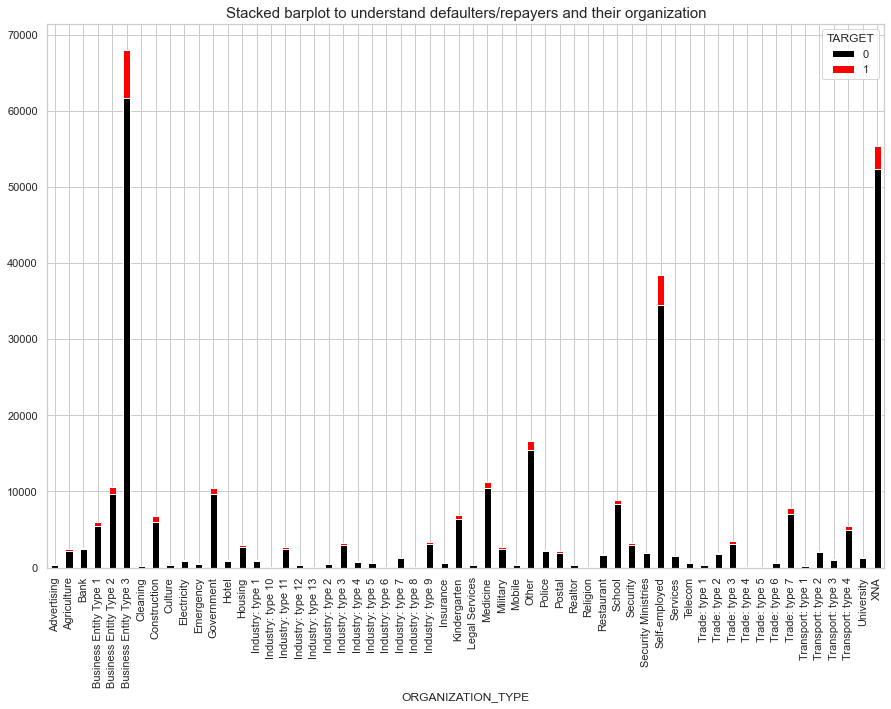

Wall time: 3.61 s


In [19]:
%%time
# create stacked barplot using crosstab
sns.set_theme(style="whitegrid")
pd.crosstab(df_credit['ORGANIZATION_TYPE'],df_credit['TARGET']).plot(kind='bar',stacked=True,color=['black','red'])
plt.title("Stacked barplot to understand defaulters/repayers and their organization",fontdict={'fontsize':15})
plt.show()

<b> Observations:
Business Entity Type 3 people is the Organization type took most number of loans.
Around 53K people data about their Organization type is not available.
Loan taken by Business Entity is more than the people working in Industry, Trade and Transport Sector

<b>

## Multivariate Analysis

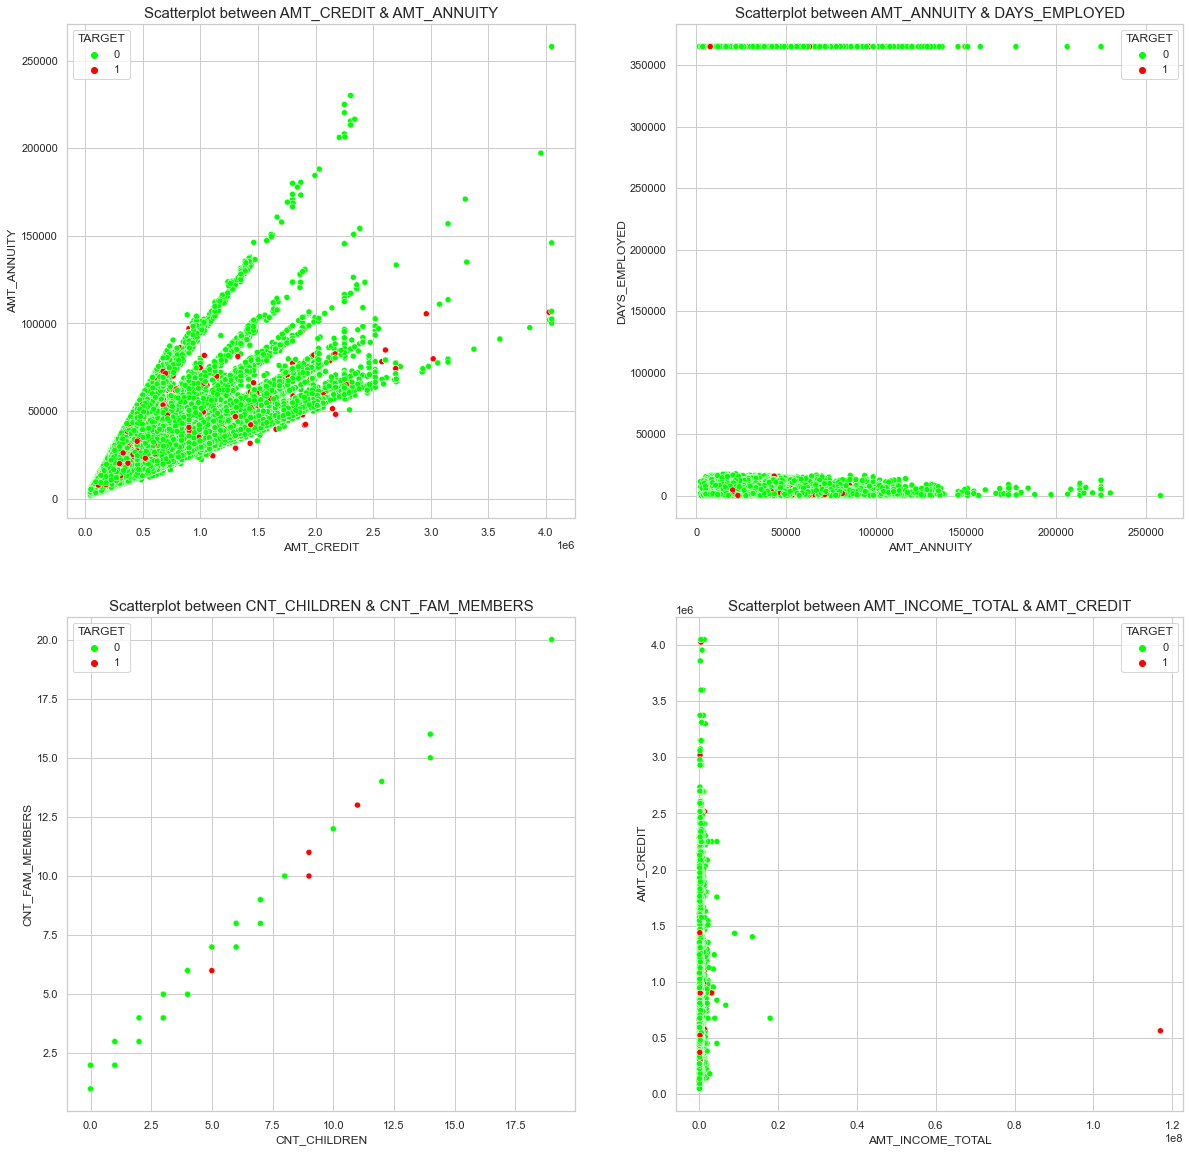

Wall time: 33.6 s


In [20]:
%%time
# create subplot
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
# create scatterplot
sns.set_theme(style="whitegrid")
sns.scatterplot(data=df_credit,x='AMT_CREDIT',y='AMT_ANNUITY',hue=df_credit['TARGET'],palette=['lime','red'])
plt.title("Scatterplot between AMT_CREDIT & AMT_ANNUITY",fontdict={'fontsize':15})

# create subplot
plt.subplot(2,2,2)
# create scatterplot
sns.set_theme(style="whitegrid")
sns.scatterplot(data=df_credit,x='AMT_ANNUITY',y='DAYS_EMPLOYED',hue=df_credit['TARGET'],palette=['lime','red'])
plt.title("Scatterplot between AMT_ANNUITY & DAYS_EMPLOYED",fontdict={'fontsize':15})

# create subplot
plt.subplot(2,2,3)
# create scatterplot
sns.set_theme(style="whitegrid")
sns.scatterplot(data=df_credit,x='CNT_CHILDREN',y='CNT_FAM_MEMBERS',hue=df_credit['TARGET'],palette=['lime','red'])
plt.title("Scatterplot between CNT_CHILDREN & CNT_FAM_MEMBERS",fontdict={'fontsize':15})

# create subplot
plt.subplot(2,2,4)
# create scatterplot
sns.set_theme(style="whitegrid")
sns.scatterplot(data=df_credit,x='AMT_INCOME_TOTAL',y='AMT_CREDIT',hue=df_credit['TARGET'],palette=['lime','red'])
plt.title("Scatterplot between AMT_INCOME_TOTAL & AMT_CREDIT",fontdict={'fontsize':15})

plt.show()

<b> Observations:
Family Count is directly proportional to the Count of children in a house.
With increase in credit amount, annuity increases     

<b>

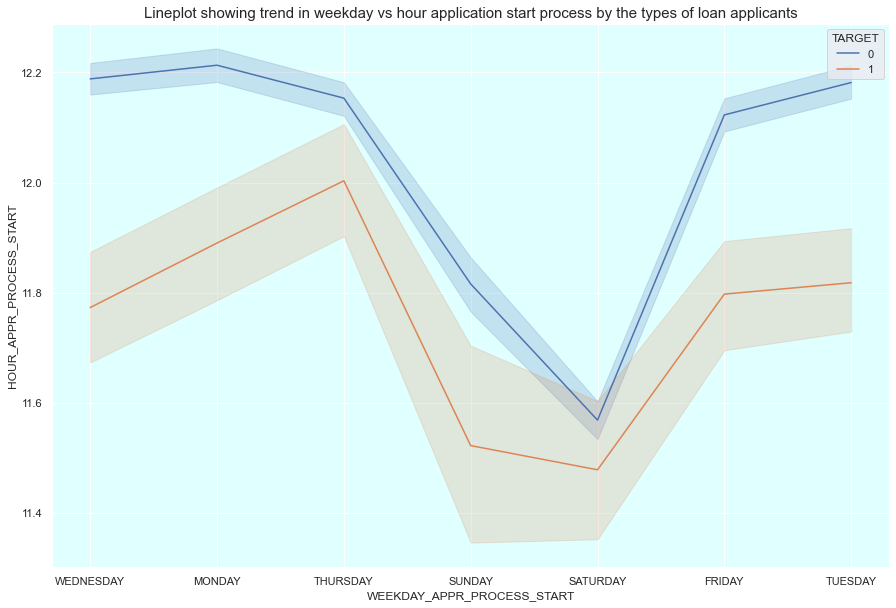

Wall time: 3.52 s


In [21]:
%%time
# create lineplot
sns.set_theme(style="darkgrid")
ax = sns.lineplot(data=df_credit, x='WEEKDAY_APPR_PROCESS_START',y='HOUR_APPR_PROCESS_START',hue='TARGET')
plt.title("Lineplot showing trend in weekday vs hour application start process by the types of loan applicants",fontdict={'fontsize':15})
ax.set_facecolor("LightCyan")
plt.show()

<b> Observations:
Clients applied for loan mostly on Thursday and weekdays overall and least on Weekends

<b>

In [22]:
# check correlation among numerical features
df_credit[numerical_columns].corr()

AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  \
AMT_ANNUITY                    1.000000    0.770138         0.775109   
AMT_CREDIT                     0.770138    1.000000         0.986968   
AMT_GOODS_PRICE                0.775109    0.986968         1.000000   
AMT_INCOME_TOTAL               0.191657    0.156870         0.159610   
AMT_REQ_CREDIT_BUREAU_DAY      0.002185    0.004238         0.004677   
AMT_REQ_CREDIT_BUREAU_HOUR     0.003861   -0.003906        -0.003237   
AMT_REQ_CREDIT_BUREAU_MON      0.039148    0.054451         0.056422   
AMT_REQ_CREDIT_BUREAU_QRT      0.010124    0.015925         0.016432   
AMT_REQ_CREDIT_BUREAU_WEEK     0.013881   -0.001275        -0.001007   
AMT_REQ_CREDIT_BUREAU_YEAR    -0.011320   -0.048448        -0.050998   
DAYS_BIRTH                    -0.009445    0.055436         0.053442   
DAYS_EMPLOYED                 -0.102851   -0.064319        -0.062265   
DAYS_ID_PUBLISH               -0.011268    0.006575         0.009267   
DAYS_LAST_PHONE_CHANGE         0.063747    0.073701         0.076313   
DAYS_REGISTRATION             -0.038514   -0.009621        -0.011565   
DEF_30_CNT_SOCIAL_CIRCLE      -0.022833   -0.021229        -0.022244   
DEF_60_CNT_SOCIAL_CIRCLE      -0.024001   -0.023767        -0.024506   
EXT_SOURCE_2                   0.125804    0.131228         0.139367   
EXT_SOURCE_3                   0.030752    0.043516         0.047717   
HOUR_APPR_PROCESS_START        0.052269    0.052738         0.062320   
OBS_30_CNT_SOCIAL_CIRCLE      -0.011987    0.000190         0.000328   
OBS_60_CNT_SOCIAL_CIRCLE      -0.011731    0.000239         0.000347   
REGION_POPULATION_RELATIVE     0.118429    0.099738         0.103520   

                            AMT_INCOME_TOTAL  AMT_REQ_CREDIT_BUREAU_DAY  \
AMT_ANNUITY                         0.191657                   0.002185   
AMT_CREDIT                          0.156870                   0.004238   
AMT_GOODS_PRICE                     0.159610                   0.004677   
AMT_INCOME_TOTAL                    1.000000                   0.002944   
AMT_REQ_CREDIT_BUREAU_DAY           0.002944                   1.000000   
AMT_REQ_CREDIT_BUREAU_HOUR          0.000709                   0.230374   
AMT_REQ_CREDIT_BUREAU_MON           0.024700                  -0.005258   
AMT_REQ_CREDIT_BUREAU_QRT           0.004859                  -0.004416   
AMT_REQ_CREDIT_BUREAU_WEEK          0.002387                   0.217412   
AMT_REQ_CREDIT_BUREAU_YEAR          0.011690                  -0.003355   
DAYS_BIRTH                         -0.027261                  -0.002255   
DAYS_EMPLOYED                      -0.063835                   0.000414   
DAYS_ID_PUBLISH                    -0.008506                   0.000999   
DAYS_LAST_PHONE_CHANGE              0.018585                  -0.002337   
DAYS_REGISTRATION                  -0.027805                   0.000508   
DEF_30_CNT_SOCIAL_CIRCLE           -0.013244                  -0.001272   
DEF_60_CNT_SOCIAL_CIRCLE           -0.013135                  -0.001822   
EXT_SOURCE_2                        0.060925                   0.000553   
EXT_SOURCE_3                       -0.030229                  -0.007190   
HOUR_APPR_PROCESS_START             0.036459                   0.002274   
OBS_30_CNT_SOCIAL_CIRCLE           -0.013099                  -0.002444   
OBS_60_CNT_SOCIAL_CIRCLE           -0.013015                  -0.002542   
REGION_POPULATION_RELATIVE          0.074796                   0.001399   

                            AMT_REQ_CREDIT_BUREAU_HOUR  \
AMT_ANNUITY                                   0.003861   
AMT_CREDIT                                   -0.003906   
AMT_GOODS_PRICE                              -0.003237   
AMT_INCOME_TOTAL                              0.000709   
AMT_REQ_CREDIT_BUREAU_DAY                     0.230374   
AMT_REQ_CREDIT_BUREAU_HOUR                    1.000000   
AMT_REQ_CREDIT_BUREAU_MON                    -0.000018   
AMT_REQ_CREDIT_BUREAU_QRT         

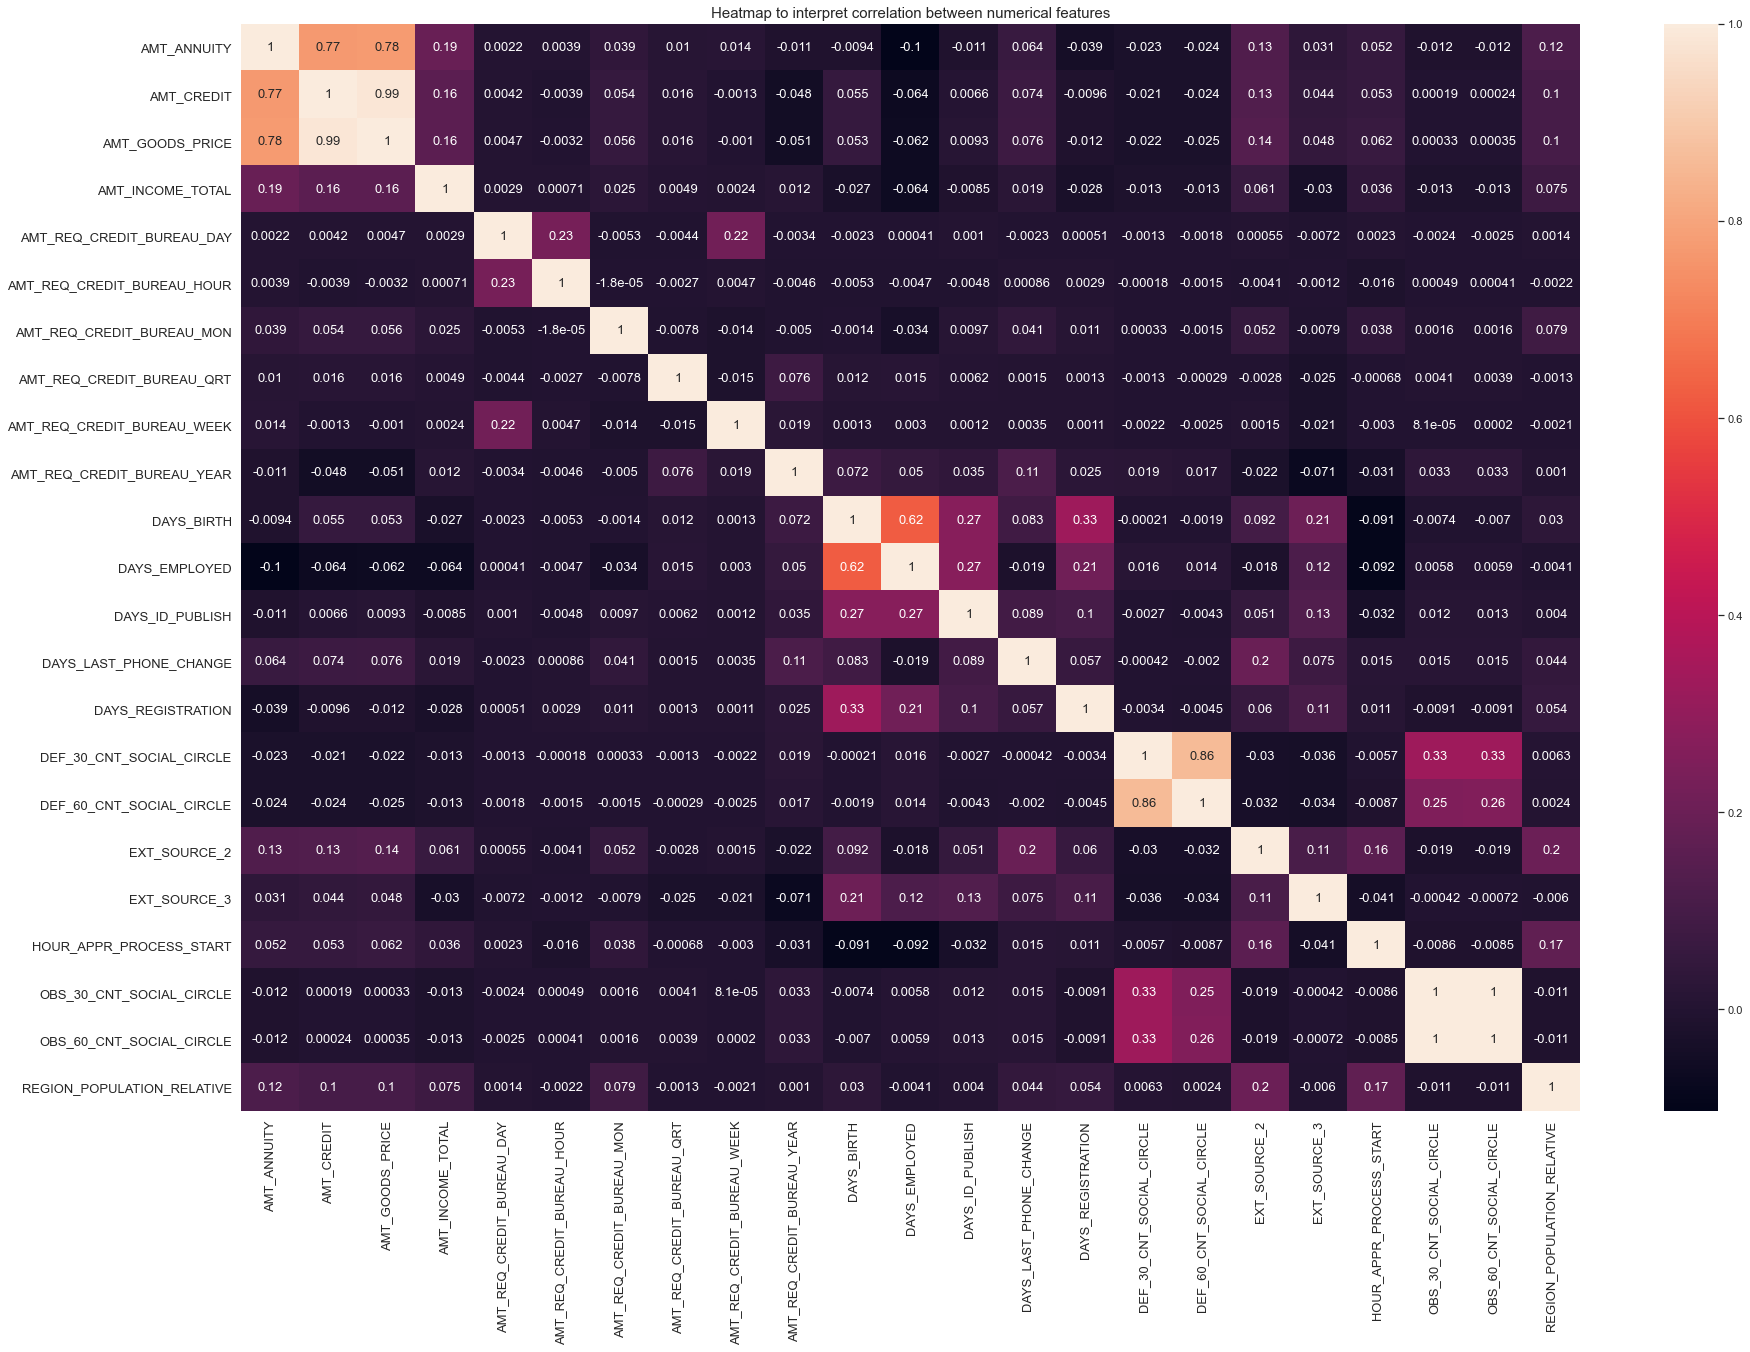

Wall time: 7.62 s


In [23]:
%%time
plt.figure(figsize=(30, 20))
sns.heatmap(df_credit[numerical_columns].corr(), annot=True, annot_kws={"size": 13})
plt.title("Heatmap to interpret correlation between numerical features", fontdict={'fontsize':15})
plt.yticks(rotation='horizontal', fontsize=13)
plt.xticks(fontsize=13)
plt.show()

<b> Observations:
    Following pair of features exhibit strong positive correlation
    
     OBS_60_CNT_SOCIAL_CIRCLE      -    OBS_30_CNT_SOCIAL_CIRCLE
     FLAG_EMP_PHONE                -    DAYS_EMPLOYED
     AMT_GOODS_PRICE               -    AMT_CREDIT
     REGION_RATING_CLIENT_W_CITY   -    REGION_RATING_CLIENT
     CNT_FAM_MEMBERS               -    CNT_CHILDREN
     DEF_60_CNT_SOCIAL_CIRCLE      -    DEF_30_CNT_SOCIAL_CIRCLE
     LIVE_REGION_NOT_WORK_REGION   -    REG_REGION_NOT_WORK_REGION
     LIVE_CITY_NOT_WORK_CITY       -    REG_CITY_NOT_WORK_CITY
     AMT_ANNUITY                   -    AMT_CREDIT
     AMT_GOODS_PRICE               -    AMT_ANNUITY
    
    Following pair of features exhibit strong negative correlation: -
    REGION_RATING_CLIENT_W_CITY    -    REGION_POPULATION_RELATIVE
    REGION_RATING_CLIENT_CLIENT    -    REGION_POPULATION_RELATIVE
<b>

# STATISTICAL TESTS

In [24]:
# select a copy of df_credit
df_statistics = df_credit.copy()

# select columns to impute with median ( skewed features )
cols_median = ['AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED','EXT_SOURCE_3','DAYS_LAST_PHONE_CHANGE']
# select columns to impute with mode ( categorical features )
cols_mode = ['NAME_TYPE_SUITE','OCCUPATION_TYPE']
    
# fill null values in median_impute_cols with median
for feature in cols_median:
    df_statistics[feature].fillna(df_statistics[feature].median(), inplace=True)
    
# fill null values in mode_impute_cols with mode 
for feature in cols_mode:
    df_statistics[feature].fillna(df_statistics[feature].mode()[0], inplace=True)

## 1.Run the test to check normality

In [25]:
# Defining Null and Alternative Hypotheses
#H0 = 'data is Normally distributed'
#H1 = 'data is not Normally distributed'
#alpha = 0.05

## Shapiro-Wilk Test

In [26]:
# normality test for the columns 
#AMT_CREDIT,AMT_INCOME_TOTAL,AMT_ANNUITY,'CNT_CHILDREN,REGION_RATING_CLIENT

from scipy.stats import shapiro
df1 = df_statistics['AMT_CREDIT']
df2 = df_statistics['AMT_INCOME_TOTAL']
df3 = df_statistics['AMT_ANNUITY']
df4 = df_statistics['CNT_CHILDREN']
df5 = df_statistics['REGION_RATING_CLIENT']


stat, p1 = shapiro(df1)
stat, p2 = shapiro(df2)
stat, p3 = shapiro(df3)
stat, p4 = shapiro(df4)
stat, p5 = shapiro(df5)
print('stat=%.3f, p1=%.3f, p2=%.3f,p3=%.3f,p4=%.3f,p5=%.3f' % (stat, p1,p2,p3,p4,p5))
if p1 > 0.05:
    print('we are accepting null hypothesis, hence AMT_CREDIT is normally distributed',)
else:
    print('we are rejecting null hypothesis,hence AMT_CREDIT is not normally distributed')
if p2 > 0.05:
    print('we are accepting null hypothesis, hence AMT_INCOME_TOTAL is normally distributed')
else:
    print('we are rejecting null hypothesis,hence AMT_INCOME_TOTAL is not normally distributed')
if p3 > 0.05:
    print('we are accepting null hypothesis, hence AMT_ANNUITY is normally distributed')
else:
    print('we are rejecting null hypothesis, hence AMT_ANNUITY is not normally distributed')
if p4 > 0.05:
    print('we are accepting null hypothesis, hence CNT_CHILDREN is  normally distributed')
else:
    print('we are rejecting null hypothesis,  hence CNT_CHILDREN is not normally distributed')
if p5 > 0.05:
    print('we are accepting null hypothesis,  hence REGION_RATING_CLIENT is  normally distributed')
else:
    print('we are rejecting null hypothesis,  hence REGION_RATING_CLIENT is  normally distributed')

stat=0.685, p1=0.000, p2=0.000,p3=0.000,p4=0.000,p5=0.000
we are rejecting null hypothesis,hence AMT_CREDIT is not normally distributed
we are rejecting null hypothesis,hence AMT_INCOME_TOTAL is not normally distributed
we are rejecting null hypothesis, hence AMT_ANNUITY is not normally distributed
we are rejecting null hypothesis,  hence CNT_CHILDREN is not normally distributed
we are rejecting null hypothesis,  hence REGION_RATING_CLIENT is  normally distributed


## D'Agostino's K^2 Normality Test

In [27]:
from scipy.stats import normaltest
df1 = df_statistics['AMT_CREDIT']
df2 = df_statistics['AMT_INCOME_TOTAL']
df3 = df_statistics['AMT_ANNUITY']
df4 = df_statistics['CNT_CHILDREN']
df5 = df_statistics['REGION_RATING_CLIENT']

stat, p1 = normaltest(df1)
stat, p2 = normaltest(df2)
stat, p3 = normaltest(df3)
stat, p4 = normaltest(df4)
stat, p5 = normaltest(df5)
print('stat=%.3f, p1=%.3f, p2=%.3f,p3=%.3f,p4=%.3f,p5=%.3f' % (stat, p1,p2,p3,p4,p5))
if p1 > 0.05:
    print('AMT_CREDIT-Probably Normally Distributed')
else:
    print('AMT_CREDIT-Probably not Normally Distributed')
    
if p2 > 0.05:
    print('AMT_INCOME_TOTAL-Probably Normally Distributed')
else:
    print('AMT_INCOME_TOTAL-Probably not Normally Distributed')
if p3 > 0.05:
    print('AMT_ANNUITY-Probably Normally Distributed')
else:
    print('AMT_ANNUITY-Probably not Normally Distributed')
if p4 > 0.05:
    print('CNT_CHILDREN-Probably Normally Distributed')
else:
    print('CNT_CHILDREN-Probably not Normally Distributed')
if p5 > 0.05:
    print('REGION_RATING_CLIENT-Probably Normally Distributed')
else:
    print('REGION_RATING_CLIENT-Probably not Normally Distributed')

stat=4706.031, p1=0.000, p2=0.000,p3=0.000,p4=0.000,p5=0.000
AMT_CREDIT-Probably not Normally Distributed
AMT_INCOME_TOTAL-Probably not Normally Distributed
AMT_ANNUITY-Probably not Normally Distributed
CNT_CHILDREN-Probably not Normally Distributed
REGION_RATING_CLIENT-Probably not Normally Distributed


## 2.Correlation Tests

## Pearson’s Correlation Coefficient

In [28]:
# Defining Null and Alternative Hypotheses
#H0 =correlation coefficient IS NOT significantly different from 0.There is not a significant relationship between the features
#H1 = correlation coefficient IS significantly different from 0.There is a significant relationship between the variables 
#alpha = 0.05

   AMT_CREDIT  AMT_ANNUITY
0    406597.5      24700.5
1   1293502.5      35698.5
2    135000.0       6750.0
3    312682.5      29686.5
4    513000.0      21865.5
0.7701267228930904


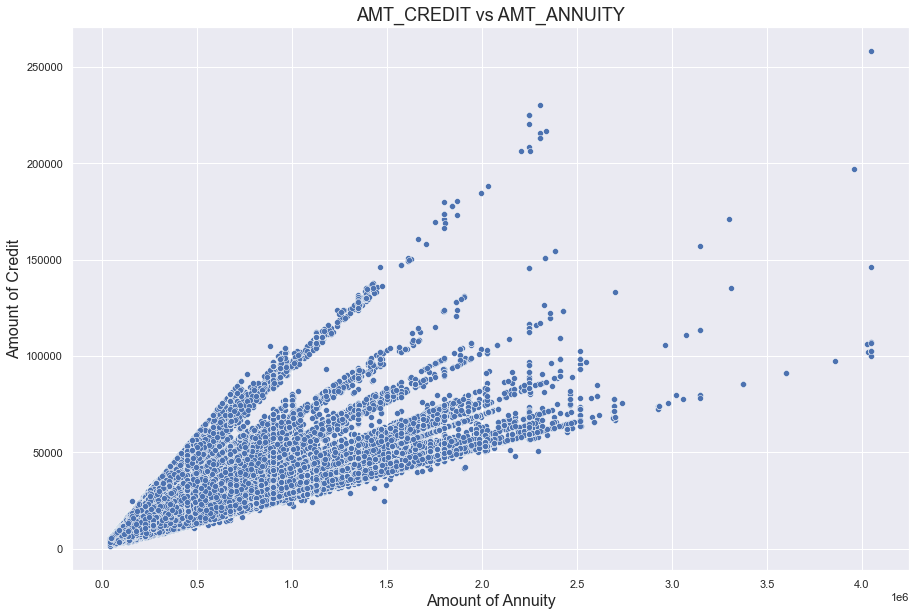

In [29]:
#Pearson’s Correlation Coefficient

df = df_statistics[['AMT_CREDIT', 'AMT_ANNUITY']]
print(df.head())

from scipy import stats
data1=df_statistics.AMT_CREDIT.values
data2=df_statistics.AMT_ANNUITY.values

correlation, p_value = stats.pearsonr(data1,data2)

print(correlation)
import matplotlib.pyplot as plt
sns.scatterplot('AMT_CREDIT','AMT_ANNUITY',data=df_statistics)
plt.title('AMT_CREDIT vs AMT_ANNUITY', fontsize=18)
plt.ylabel('Amount of Credit', fontsize=16)
plt.xlabel('Amount of Annuity', fontsize=16)
plt.show()


<b>Observation:

we can see that the relationship is not linear between the two columns.<b>

## Chi Square Test

In [30]:
#Null and alternate hypothesis
#H0:-there is not a significant relationship between the columns 
#H1:-there is a significant relationship between the columns 

stat=514939.431, p=0.000
Probably dependent


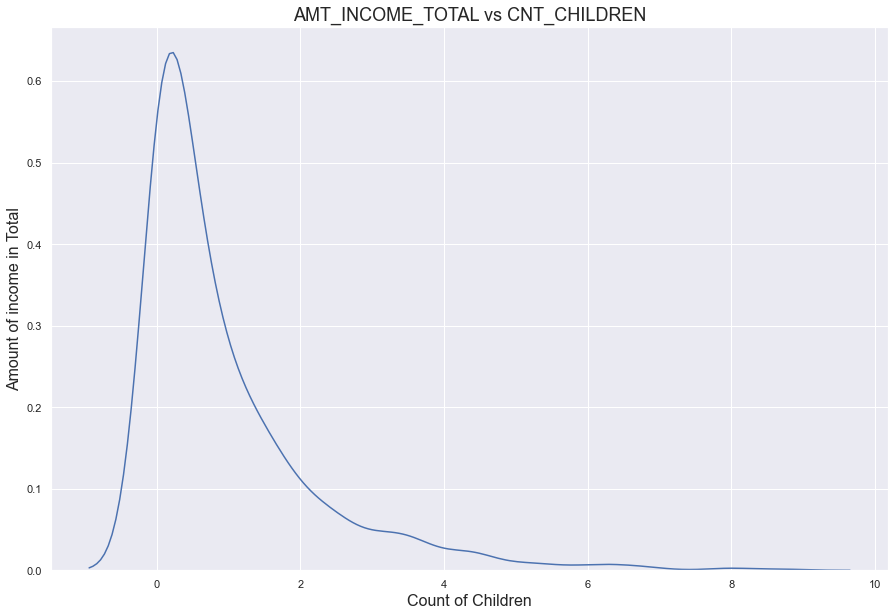

In [31]:
# the Chi-Squared Test of independence for columns-AMT_INCOME_TOTAL vs CNT_CHILDREN
import matplotlib.pyplot as plt
from numpy import random
from scipy.stats import chi2_contingency
df3 = df_statistics['AMT_INCOME_TOTAL']
df4 = df_statistics['CNT_CHILDREN']
table = [[df3],[df4]]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

sns.distplot(random.chisquare(df=1, size=1000), hist=False)


plt.title('AMT_INCOME_TOTAL vs CNT_CHILDREN',fontsize=18)
plt.ylabel('Amount of income in Total',fontsize=16)
plt.xlabel('Count of Children',fontsize=16)
plt.show()
    
    

<b>Observation:
    
    The p value obtained from chi-square test for independence is significant (p < 0.05), and therefore, we conclude that there is a significant association between Columns CNT_CHILDREN and AMT_INCOME_TOTAL

In [32]:
#the Chi-Squared Test of independence for columns-NAME_INCOME_TYPE and OCCUPATION_TYPE
from scipy.stats import chi2_contingency
contingency_data=pd.crosstab(df_statistics["NAME_INCOME_TYPE"], df_statistics["OCCUPATION_TYPE"])

stats, pvalue, dof, expected = chi2_contingency(contingency_data)

print("Stats :", stats, "Pvalue :", pvalue)

if pvalue> 0.05:
    print(" Both the categorical attributes are independent ( Fail to reject H0).")
else:
    print("Both the categorical attributes are dependent (Reject H0).")


Stats : 98842.68043941665 Pvalue : 0.0
Both the categorical attributes are dependent (Reject H0).


In [33]:
#independence test for columns-NAME_CONTRACT_TYPE  and WEEKDAY_APPR_PROCESS_START#
contingency_data2=pd.crosstab(df_statistics["NAME_CONTRACT_TYPE"],df_statistics["WEEKDAY_APPR_PROCESS_START"])
stats, pvalue, dof, expected = chi2_contingency(contingency_data2)

print("Stats :", stats, "Pvalue :", pvalue)

if pvalue> 0.05:
    print(" Both the categorical attributes are independent ( Fail to reject H0).")
else:
    print("Both the categorical attributes are dependent (Reject H0).")


Stats : 67.99048638705025 Pvalue : 1.0553487110442855e-12
Both the categorical attributes are dependent (Reject H0).


## 3.Parametric Statistical Hypothesis Tests

## Analysis of Variance Test (ANOVA)

In [34]:
# Example of the Analysis of Variance Test
from scipy.stats import f_oneway
df1 = df_statistics['AMT_CREDIT']
df2 = df_statistics['AMT_INCOME_TOTAL']
df3 = df_statistics['AMT_ANNUITY']
df4 = df_statistics['CNT_CHILDREN']
df5 = df_statistics['REGION_RATING_CLIENT']

stat, p = f_oneway(df1, df2, df3,df4,df5)

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=460478.031, p=0.000
Probably different distributions


<b>Observation:
    The p value obtained from ANOVA analysis is significant (p < 0.05), and therefore, we conclude that there are significant differences among treatments.<b>

## One sample T Test

In [35]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
df3 = df_statistics['AMT_ANNUITY']
tscore, pvalue = ttest_1samp(df3, popmean=20)
print("t Statistic: ", tscore)  
print("P Value: ", pvalue)
plt.show()

t Statistic:  1036.4371745647163
P Value:  0.0


## 4.Nonparametric Statistical Hypothesis Tests

## Mann-Whitney U Test

Checking whether the distributons of two or more independemt samples are equal or not.

In [36]:
#Null and alternate hypothesis
#H0: Same distribution (The two populations are equal).
#H1: Different distribution (The two populations are not equal).

In [37]:
# CNT_CHILDREN and REGION_RATING_CLIENT
from scipy.stats import mannwhitneyu
df4 = df_statistics['CNT_CHILDREN']
df5 = df_statistics['REGION_RATING_CLIENT']
stat, p = mannwhitneyu(df4, df5)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=6104824969.500, p=0.000
Probably different distributions


<b>Observation:
    The p-value strongly suggests that the sample distributions are different, as is expected.<b>

In [38]:
# AMT_INCOME_TOTAL and DAYS_EMPLOYED
sample5=df_statistics[1:30]["AMT_INCOME_TOTAL"]
sample6=df_statistics[1:30]["DAYS_EMPLOYED"]

tstats, pvalue = st.mannwhitneyu(sample5, sample6)

print("stats: ", tstats, "Pvalue: ", pvalue)

if pvalue>0.05:
    print("Two populations are equal (Fail to reject H0)")
else:
    print("Two populations are not equal (Reject H0)")

stats:  84.0 Pvalue:  8.546693138064218e-08
Two populations are not equal (Reject H0)


## Kruskal-Wallis H Test

Checking whether the distributons of two or more independemt samples are equal or not.

In [39]:
#alternate and null hypothesis
#H0: Same distribution (The two populations are equal).
#H1: Different distribution (The two populations are not equal).

In [40]:
#AMT_INCOME_TOTAL - CNT_CHILDREN
from scipy.stats import kruskal
df2 = df_statistics['AMT_INCOME_TOTAL']
df4 = df_statistics['CNT_CHILDREN']
stat, p = kruskal(df2, df5)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=486306.354, p=0.000
Probably different distributions


<b>Observation:
    
    The p-value is interpreted, correctly rejecting the null hypothesis that all samples have the same distribution<b>

# 2) FEATURE ENGINEERING (FE)

Cleansing the dataset
Shape before dropping columns having more than 40% missing data: (307511, 121)
Missing value Percentage


COMMONAREA_MEDI  COMMONAREA_AVG  COMMONAREA_MODE  NONLIVINGAPARTMENTS_MODE  \
0        69.872297       69.872297        69.872297                 69.432963   

   NONLIVINGAPARTMENTS_MEDI  NONLIVINGAPARTMENTS_AVG  FONDKAPREMONT_MODE  \
0                 69.432963                69.432963           68.386172   

   LIVINGAPARTMENTS_MEDI  LIVINGAPARTMENTS_MODE  LIVINGAPARTMENTS_AVG  \
0              68.354953              68.354953             68.354953   

   FLOORSMIN_AVG  FLOORSMIN_MEDI  FLOORSMIN_MODE  YEARS_BUILD_MEDI  \
0       67.84863        67.84863        67.84863         66.497784   

   YEARS_BUILD_MODE  YEARS_BUILD_AVG  OWN_CAR_AGE  LANDAREA_AVG  \
0         66.497784        66.497784     65.99081     59.376738   

   LANDAREA_MEDI  LANDAREA_MODE  BASEMENTAREA_AVG  BASEMENTAREA_MODE  \
0      59.376738      59.376738         58.515956          58.515956   

   BASEMENTAREA_MEDI  EXT_SOURCE_1  NONLIVINGAREA_MEDI  NONLIVINGAREA_AVG  \
0          58.515956     56.381073           55.179164          55.179164   

   NONLIVINGAREA_MODE  ELEVATORS_AVG  ELEVATORS_MEDI  ELEVATORS_MODE  \
0           55.179164       53.29598        53.29598        53.29598   

   WALLSMATERIAL_MODE  APARTMENTS_MODE  APARTMENTS_MEDI  APARTMENTS_AVG  \
0           50.840783        50.749729        50.749729       50.749729   

   ENTRANCES_MEDI  ENTRANCES_MODE  ENTRANCES_AVG  LIVINGAREA_MEDI  \
0       50.348768       50.348768      50.348768        50.193326   

   LIVINGAREA_MODE  LIVINGAREA_AVG  HOUSETYPE_MODE  FLOORSMAX_AVG  \
0        50.193326       50.193326       50.176091      49.760822   

   FLOORSMAX_MEDI  FLOORSMAX_MODE  YEARS_BEGINEXPLUATATION_AVG  \
0       49.760822       49.760822                    48.781019   

   YEARS_BEGINEXPLUATATION_MEDI  YEARS_BEGINEXPLUATATION_MODE  TOTALAREA_MODE  \
0                     48.781019                     48.781019       48.268517   

   EMERGENCYSTATE_MODE  OCCUPATION_TYPE  EXT_SOURCE_3  \
0            47.398304        31.345545     19.825307   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  \
0                  13.501631                   13.501631   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_DAY  \
0                   13.501631                  13.501631   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_MON  NAME_TYPE_SUITE  \
0                   13.501631                  13.501631         0.420148   

   OBS_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE  \
0                  0.332021                  0.332021   

   DEF_60_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  EXT_SOURCE_2  \
0                  0.332021                  0.332021      0.214626   

   AMT_GOODS_PRICE  AMT_ANNUITY  CNT_FAM_MEMBERS  DAYS_LAST_PHONE_CHANGE  \
0         0.090403     0.003902          0.00065                0.000325   

   AMT_CREDIT  AMT_INCOME_TOTAL  NAME_CONTRACT_TYPE  FLAG_EMAIL  FLAG_PHONE  \
0         0.0               0.0                 0.0         0.0         0.0   

   FLAG_CONT_MOBILE  FLAG_WORK_PHONE  FLAG_EMP_PHONE  FLAG_MOBIL  CODE_GENDER  \
0               0.0              0.0             0.0         0.0          0.0   

   FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  DAYS_ID_PUBLISH  \
0           0.0              0.0           0.0              0.0   

   DAYS_REGISTRATION  DAYS_EMPLOYED  DAYS_BIRTH  REGION_POPULATION_RELATIVE  \
0                0.0            0.0         0.0                         0.0   

   REGION_RATING_CLIENT  NAME_FAMILY_STATUS  NAME_EDUCATION_TYPE  \
0                   0.0                 0.0                  0.0   

   NAME_INCOME_TYPE  NAME_HOUSING_TYPE  REG_REGION_NOT_LIVE_REGION  \
0               0.0                0.0                         0.0   

   REGION_RATING_CLIENT_W_CITY  WEEKDAY_APPR_PROCESS_START  FLAG_DOCUMENT_2  \
0                          0.0                         0.0              0.0   

   FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
0              0.0              0.0          

No.of columns with more than 40% missing values: 49
Shape after dropping columns having more than 40% missing data: (307511, 72)
No.of duplicates in the data: 0
Total number of categorical features after cleansing the data:  49
Total number of numerical features after cleansing the data:  23
Logs during feature rectification process:
No.of.classes in ORGANIZATION_TYPE before clubbing levels: 58


Business Entity Type 3    XNA  Self-employed  Other  \
ORGANIZATION_TYPE                   67992  55374          38412  16683   

                   Medicine  Business Entity Type 2  Government  School  \
ORGANIZATION_TYPE     11193                   10553       10404    8893   

                   Trade: type 7  Kindergarten  Construction  \
ORGANIZATION_TYPE           7831          6880          6721   

                   Business Entity Type 1  Transport: type 4  Trade: type 3  \
ORGANIZATION_TYPE                    5984               5398           3492   

                   Industry: type 9  Industry: type 3  Security  Housing  \
ORGANIZATION_TYPE              3368              3278      3247     2958   

                   Industry: type 11  Military  Bank  Agriculture  Police  \
ORGANIZATION_TYPE               2704      2634  2507         2454    2341   

                   Transport: type 2  Postal  Security Ministries  \
ORGANIZATION_TYPE               2204    2157                 1974   

                   Trade: type 2  Restaurant  Services  University  \
ORGANIZATION_TYPE           1900        1811      1575        1327   

                   Industry: type 7  Transport: type 3  Industry: type 1  \
ORGANIZATION_TYPE              1307               1187              1039   

                   Hotel  Electricity  Industry: type 4  Trade: type 6  \
ORGANIZATION_TYPE    966          950               877            631   

                   Industry: type 5  Insurance  Telecom  Emergency  \
ORGANIZATION_TYPE               599        597      577        560   

                   Industry: type 2  Advertising  Realtor  Culture  \
ORGANIZATION_TYPE               458          429      396      379   

                   Industry: type 12  Trade: type 1  Mobile  Legal Services  \
ORGANIZATION_TYPE                369            348     317             305   

                   Cleaning  Transport: type 1  Industry: type 6  \
ORGANIZATION_TYPE       260                201               112   

                   Industry: type 10  Religion  Industry: type 13  \
ORGANIZATION_TYPE                109        85                 67   

                   Trade: type 4  Trade: type 5  Industry: type 8  
ORGANIZATION_TYPE             64             49                24

No.of.classes in ORGANIZATION_TYPE after clubbing levels: 15


Business_Entity    XNA  Self-employed  Official  Other  \
ORGANIZATION_TYPE            84529  55374          38412     31568  19680   

                   Education  Trade  Industry  Transport  Construction  \
ORGANIZATION_TYPE      17100  14315     14311       8990          6721   

                   TourismFoodSector  Realty  Security  Finance  Agriculture  
ORGANIZATION_TYPE               4352    3354      3247     3104         2454

No.of.classes in OCCUPATION_TYPE before clubbing levels: 19


Laborers  Sales staff  Core staff  Managers  Drivers  \
OCCUPATION_TYPE     55186        32102       27570     21371    18603   

                 High skill tech staff  Accountants  Medicine staff  \
OCCUPATION_TYPE                  11380         9813            8537   

                 Security staff  Cooking staff  Cleaning staff  \
OCCUPATION_TYPE            6721           5946            4653   

                 Private service staff  Low-skill Laborers  \
OCCUPATION_TYPE                   2652                2093   

                 Waiters/barmen staff  Secretaries  Realty agents  HR staff  \
OCCUPATION_TYPE                  1348         1305            751       563   

                 IT staff  
OCCUPATION_TYPE       526

No.of.classes in OCCUPATION_TYPE after clubbing levels: 11


Laborers  Sales staff  Core staff  Low_skill_staff  Managers  \
OCCUPATION_TYPE     55186        32102       27570            23413     21371   

                 Drivers  High_skill_staff  Accountants  Medicine staff  \
OCCUPATION_TYPE    18603             11906         9813            8537   

                 Others  
OCCUPATION_TYPE    2619

No.of.classes in NAME_INCOME_TYPE before clubbing levels: 8


Working  Commercial associate  Pensioner  State servant  \
NAME_INCOME_TYPE   158774                 71617      55362          21703   

                  Unemployed  Student  Businessman  Maternity leave  
NAME_INCOME_TYPE          22       18           10                5

No.of.classes in NAME_INCOME_TYPE after clubbing levels: 4


Working  Commercial associate  Pensioner  State servant
NAME_INCOME_TYPE   158774                 71627      55389          21721

Correlation between the feature SCORE_DOCUMENT_SUBMISSION and TARGET 0.03015619952371004
365243 in DAYS_EMPLOYED replaced with NaNs
No.of.observations having unavailable gender information 4
No.of.observations having unavailable family status 2
Shape of the data (307505, 60)
Null Value Imputation
Columns with standard missing values: ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CATEGORY_DEF_30_60_SOCIAL_CIRCLE', 'SCORE_EXT_SOURCE', 'RATIO_AMTCREDIT_AMTANNUITY', 'RATIO_DAYSEMPLOYED_DAYSBIRTH', 'RATIO_AMTCREDIT_AMTGOODSPRICE', 'RATIO_AMTINCOMETOTAL_DAYSEMPLOYED', 'RATIO_AMTANNUITY_AMTINCOMETOTAL', 'RATIO_LASTPHONECHANGE_DAYSBIRTH']

Total number of missing 

'Feature name is:'

'AMT_ANNUITY'

Feature contains all positive values


original       log  exp      sqrt      cbrt    boxcox  yeo-johnson
Skewness  1.579811 -0.345763  NaN  0.452116  0.172701 -0.004292    -0.004292

Skewness best reduced with: boxcox


'Feature name is:'

'AMT_CREDIT'

Feature contains all positive values


original       log  exp      sqrt      cbrt   boxcox  yeo-johnson
Skewness  1.234759 -0.338822  NaN  0.447113  0.194653 -0.02407    -0.024069

Skewness best reduced with: yeo-johnson


'Feature name is:'

'AMT_GOODS_PRICE'

Feature contains all positive values


original       log  exp      sqrt      cbrt    boxcox  yeo-johnson
Skewness  1.350132 -0.293304  NaN  0.520984  0.258207 -0.017775    -0.017774

Skewness best reduced with: yeo-johnson


'Feature name is:'

'AMT_INCOME_TOTAL'

Feature contains all positive values


original       log  exp      sqrt     cbrt    boxcox  yeo-johnson
Skewness  391.558872  0.169974  NaN  4.907222  1.32023 -0.008006          0.0

Skewness best reduced with: yeo-johnson


'Feature name is:'

'AMT_REQ_CREDIT_BUREAU_DAY'

Feature contains zero(s)


original  log         exp       sqrt       cbrt  boxcox  \
Skewness  29.081293  NaN  358.355509  15.977638  14.830648     NaN   

          yeo-johnson  
Skewness    14.266207

Skewness best reduced with: yeo-johnson


'Feature name is:'

'AMT_REQ_CREDIT_BUREAU_HOUR'

Feature contains zero(s)


original  log        exp       sqrt       cbrt  boxcox  yeo-johnson
Skewness  15.641835  NaN  89.197971  13.883663  13.727442     NaN    13.642749

Skewness best reduced with: yeo-johnson


'Feature name is:'

'AMT_REQ_CREDIT_BUREAU_MON'

Feature contains zero(s)


original  log         exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  8.371773  NaN  552.229806  2.999297  2.361103     NaN     2.047782

Skewness best reduced with: yeo-johnson


'Feature name is:'

'AMT_REQ_CREDIT_BUREAU_QRT'

Feature contains zero(s)


original  log  exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  141.400595  NaN  NaN  2.178646  1.911079     NaN     1.810353

Skewness best reduced with: yeo-johnson


'Feature name is:'

'AMT_REQ_CREDIT_BUREAU_WEEK'

Feature contains zero(s)


original  log         exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  10.007933  NaN  211.165556  6.041765  5.835547     NaN     5.749205

Skewness best reduced with: yeo-johnson


'Feature name is:'

'AMT_REQ_CREDIT_BUREAU_YEAR'

Feature contains zero(s)


original  log         exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  1.371752  NaN  538.749169  0.162879 -0.195689     NaN     0.076716

Skewness best reduced with: yeo-johnson


'Feature name is:'

'DAYS_BIRTH'

Feature contains all positive values


original       log  exp      sqrt      cbrt    boxcox  yeo-johnson
Skewness  0.115655 -0.300812  NaN -0.086192 -0.156278 -0.056069    -0.056064

Skewness best reduced with: yeo-johnson


'Feature name is:'

'DAYS_BIRTH_AS_AGE'

Feature contains all positive values


original       log        exp      sqrt      cbrt   boxcox  \
Skewness  0.115117 -0.303005  15.896779 -0.087428 -0.157799 -0.05621   

          yeo-johnson  
Skewness    -0.054303

Skewness best reduced with: yeo-johnson


'Feature name is:'

'DAYS_EMPLOYED'

Feature contains zero(s)


original  log  exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  2.295857  NaN  NaN  0.949696  0.472322     NaN     0.006045

Skewness best reduced with: yeo-johnson


'Feature name is:'

'DAYS_ID_PUBLISH'

Feature contains zero(s)


original  log  exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness -0.349332  NaN  NaN -0.883493 -1.182918     NaN    -0.408665

Skewness best reduced with: original


'Feature name is:'

'DAYS_LAST_PHONE_CHANGE'

Feature contains zero(s)


original  log  exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  0.713598  NaN  NaN -0.240435 -0.761982     NaN    -0.473804

Skewness best reduced with: sqrt


'Feature name is:'

'DAYS_REGISTRATION'

Feature contains zero(s)


original  log  exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  0.590862  NaN  NaN -0.179603 -0.530903     NaN    -0.184563

Skewness best reduced with: sqrt


'Feature name is:'

'DEF_30_CNT_SOCIAL_CIRCLE'

Feature contains zero(s)


original  log         exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  5.192485  NaN  554.528629  2.673479  2.515746     NaN     2.423645

Skewness best reduced with: yeo-johnson


'Feature name is:'

'DEF_60_CNT_SOCIAL_CIRCLE'

Feature contains zero(s)


original  log         exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  5.286445  NaN  554.528629  3.232681  3.087049     NaN     3.004265

Skewness best reduced with: yeo-johnson


'Feature name is:'

'EXT_SOURCE_2'

Feature contains zero(s)


original  log       exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness -0.800069  NaN -0.493564 -1.475729 -1.963283     NaN    -0.207997

Skewness best reduced with: yeo-johnson


'Feature name is:'

'EXT_SOURCE_3'

Feature contains all positive values


original       log       exp      sqrt      cbrt    boxcox  \
Skewness -0.537697 -5.295623 -0.109578 -1.280021 -1.778911 -0.221808   

          yeo-johnson  
Skewness    -0.053573

Skewness best reduced with: yeo-johnson


'Feature name is:'

'HOUR_APPR_PROCESS_START'

Feature contains zero(s)


original  log        exp    sqrt      cbrt  boxcox  yeo-johnson
Skewness    -0.028  NaN  43.927831 -0.5374 -0.824956     NaN    -0.013831

Skewness best reduced with: yeo-johnson


'Feature name is:'

'RATIO_AMTANNUITY_AMTINCOMETOTAL'

Feature contains zero(s)


original  log       exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  1.511643  NaN  2.794954  0.491965  0.195737     NaN     0.044421

Skewness best reduced with: yeo-johnson


'Feature name is:'

'RATIO_AMTCREDIT_AMTANNUITY'

Feature contains zero(s)


original  log         exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  0.304106  NaN  139.967821 -0.032569 -0.163054     NaN    -0.042841

Skewness best reduced with: sqrt


'Feature name is:'

'RATIO_AMTCREDIT_AMTGOODSPRICE'

Feature contains zero(s)


original  log         exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  0.823508  NaN  275.635565 -3.207615 -8.455748     NaN     0.227691

Skewness best reduced with: yeo-johnson


'Feature name is:'

'RATIO_AMTCREDIT_AMTINCOMETOTAL'

Feature contains all positive values


original       log         exp      sqrt      cbrt    boxcox  \
Skewness  1.835933 -0.266964  554.528629  0.676129  0.363503 -0.003996   

          yeo-johnson  
Skewness     0.011136

Skewness best reduced with: boxcox


'Feature name is:'

'RATIO_AMTINCOMETOTAL_DAYSBIRTH'

Feature contains all positive values


original      log  exp      sqrt      cbrt    boxcox  yeo-johnson
Skewness  403.960601 -0.06123  NaN  4.048352  0.972815  0.002143    -0.002121

Skewness best reduced with: yeo-johnson


'Feature name is:'

'RATIO_AMTINCOMETOTAL_DAYSEMPLOYED'

Feature contains zero(s)


original  log  exp      sqrt     cbrt  boxcox  yeo-johnson
Skewness  145.324626  NaN  NaN  3.358352  0.56321     NaN    -0.050127

Skewness best reduced with: yeo-johnson


'Feature name is:'

'RATIO_DAYSEMPLOYED_DAYSBIRTH'

Feature contains zero(s)


original  log      exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  1.421286  NaN  1.82928  0.171131 -0.452858     NaN     0.227648

Skewness best reduced with: sqrt


'Feature name is:'

'RATIO_DAYSIDPUBLISH_DAYSBIRTH'

Feature contains zero(s)


original  log       exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness -0.016348  NaN  0.151507 -0.712114 -1.073681     NaN    -0.024306

Skewness best reduced with: original


'Feature name is:'

'RATIO_LASTPHONECHANGE_DAYSBIRTH'

Feature contains zero(s)


original  log       exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  0.925543  NaN  1.065014 -0.170114 -0.723962     NaN      0.14766

Skewness best reduced with: yeo-johnson


'Feature name is:'

'REGION_POPULATION_RELATIVE'

Feature contains all positive values


original       log       exp      sqrt      cbrt    boxcox  \
Skewness  1.488036 -0.565093  1.551907  0.443715  0.114943 -0.010702   

          yeo-johnson  
Skewness      0.09617

Skewness best reduced with: boxcox


'Feature name is:'

'SCORE_DOCUMENT_SUBMISSION'

Feature contains zero(s)


original  log       exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness -2.331077  NaN -2.331065 -2.331065 -2.331065     NaN    -2.331077

Skewness best reduced with: sqrt


'Feature name is:'

'SCORE_EXT_SOURCE'

Feature contains zero(s)


original  log       exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness -0.634181  NaN -0.278399 -1.381751 -1.934285     NaN    -0.087224

Skewness best reduced with: yeo-johnson


'Feature name is:'

'SCORE_EXT_SOURCE'

Feature contains negative values


original  log       exp  sqrt      cbrt  boxcox  yeo-johnson
Skewness -0.087224  NaN  1.998076   NaN -0.028325     NaN    -0.008262

Skewness best reduced with: yeo-johnson


'Feature name is:'

'SCORE_REGION'

Feature contains zero(s)


original  log        exp      sqrt      cbrt  boxcox  yeo-johnson
Skewness  1.717836  NaN  13.958651  1.228885  1.157683     NaN      1.11117

Skewness best reduced with: yeo-johnson


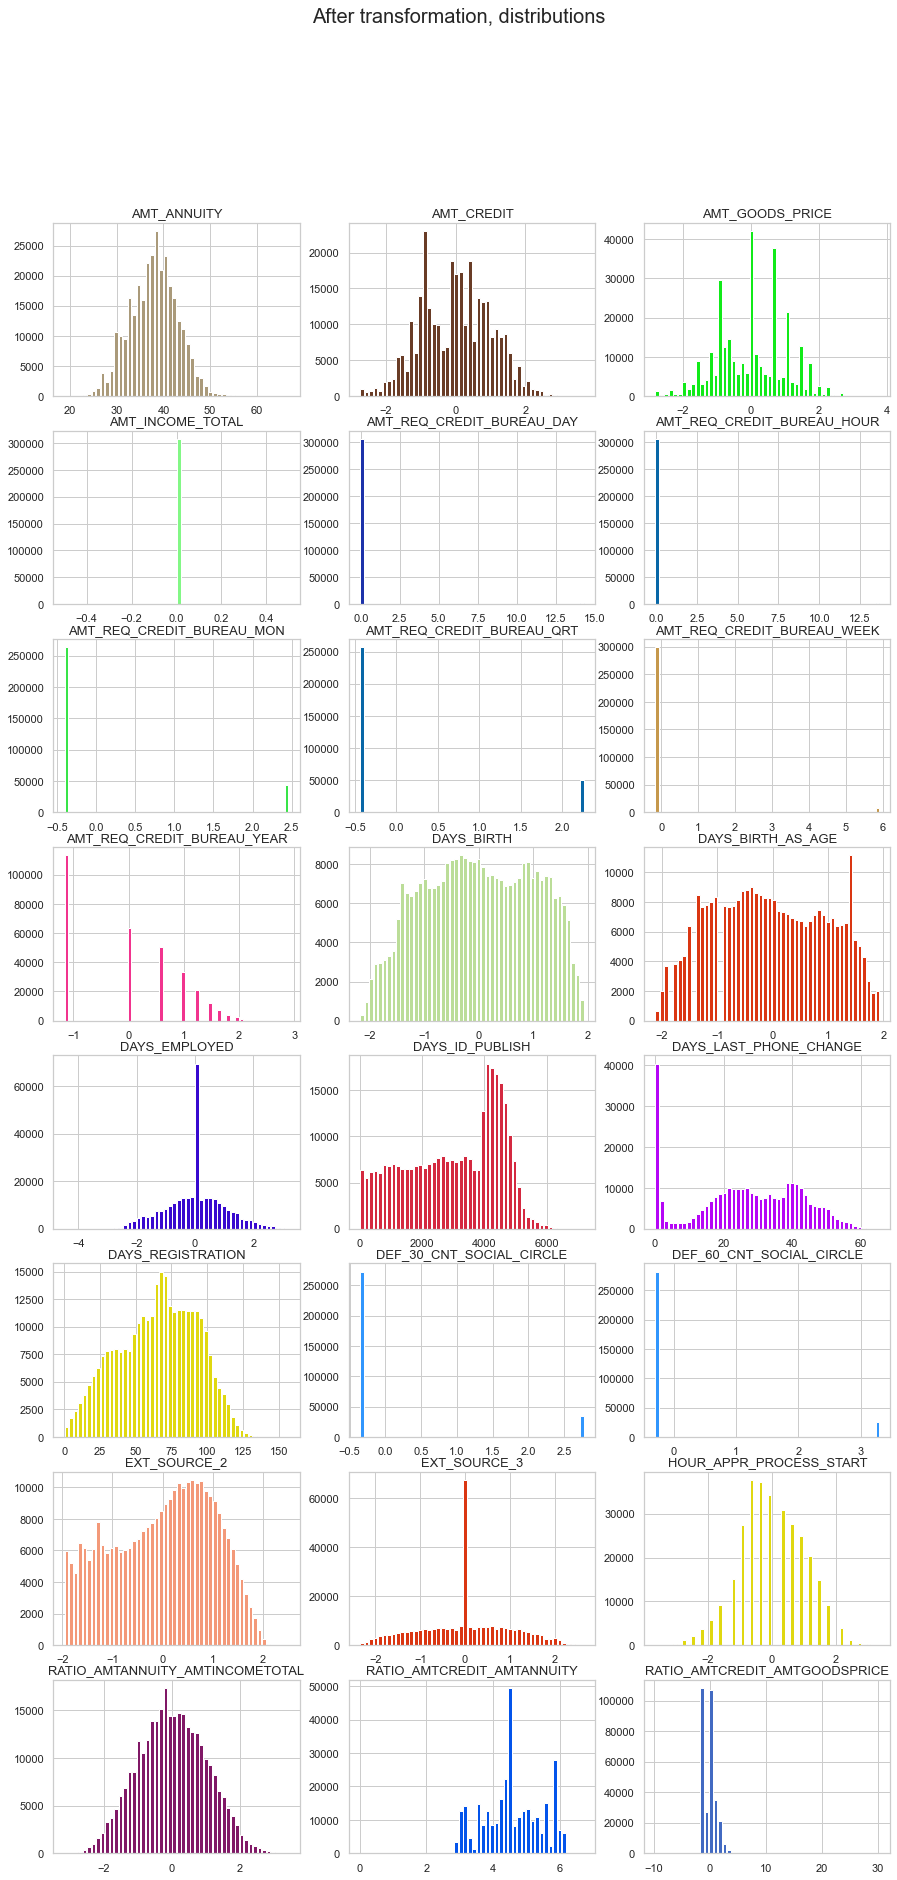

Visualizing boxplots after outlier treatment


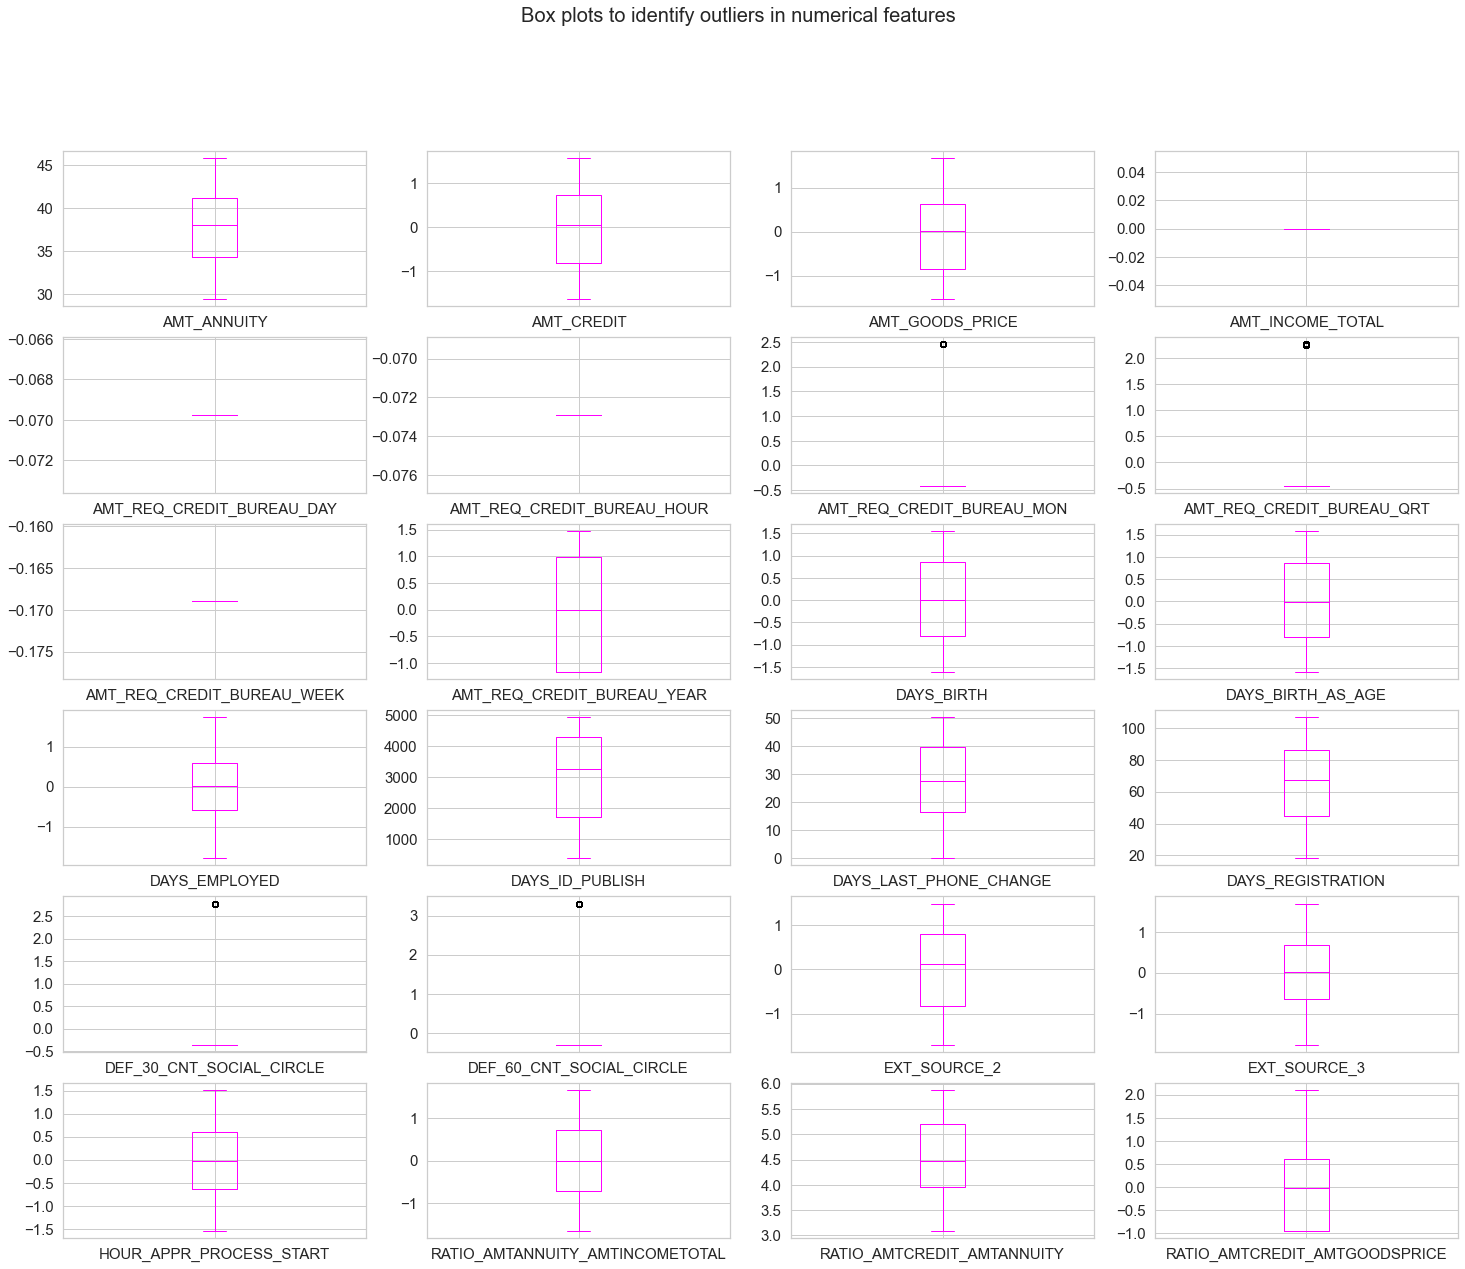

Encoding finished
Encoding Result


TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0       1                   0            1             0                1   
1       0                   0            0             0                0   
2       0                   1            1             1                1   
3       0                   0            0             0                1   
4       0                   0            1             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0               0.0   -0.284045    37.948228        -0.324484   
1             0               0.0    1.495397    41.559655         1.434248   
2             0               0.0   -1.648314    29.434695        -1.534465   
3             0               0.0   -0.635705    39.714413        -0.549760   
4             0               0.0    0.042351    36.816232         0.210496   

   NAME_EDUCATION_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                    2                   -2.438794   -1.597500      -0.939489   
1                    4                   -2.822321    0.222753      -0.336061   
2                    2                   -2.636761    0.716546      -1.796272   
3                    2                   -2.699624    0.707901       0.708295   
4                    2                   -2.285788    0.901460       0.707898   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
0          60.398675           2120.0           1               1   
1          34.438351            375.0           1               1   
2          65.268675           2531.0           1               1   
3          99.161484           2437.0           1               1   
4          65.658206           3458.0           1               1   

   FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                0                 1           1           0              1.0   
1                0                 1           1           0              2.0   
2                1                 1           1           0              1.0   
3                0                 1           0           0              2.0   
4                0                 1           0           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                -0.633698   
1                     1                            1                -0.328028   
2                     2                            2                -0.938841   
3                     2                            2                 1.515025   
4                     2                            2                -0.328028   

   EXT_SOURCE_2  EXT_SOURCE_3  DEF_30_CNT_SOCIAL_CIRCLE  \
0     -1.314384     -1.762155                  2.782683   
1      0.499139      0.018329                 -0.359329   
2      0.060010      1.327229                 -0.359329   
3      0.702602      0.018329                 -0.359329   
4     -1.099143      0.018329                 -0.359329   

   DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  \
0                  3.306658               33.674916   
1                 -0.302419               28.774989   
2                 -0.302419               28.548205   
3                 -0.302419               24.839485   
4                 -0.302419               33.256578   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                    -0.07291                  -0.069755   
1                    -0.07291                  -0.069755   
2                    -0.07291                  -0.069755   
3                    -0.07291                  -0.069755   
4                    -0.07291                  -0.069755   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                   -0.168972                  -0.407319   
1                   -0

Shape after encoding: (307505, 103)
Applying Synthetic Minority Oversampling Technique


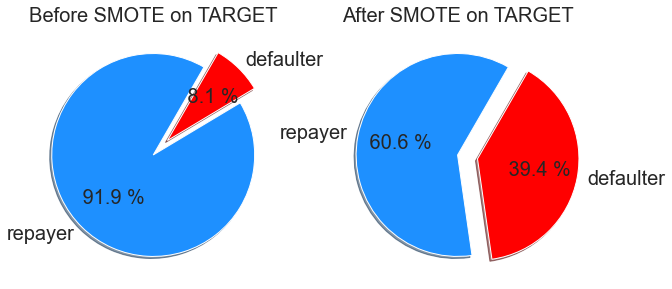

Numerical Independent Features


SCORE_EXT_SOURCE  AMT_GOODS_PRICE  DEF_30_CNT_SOCIAL_CIRCLE  \
0         -1.654763        -0.324484                  2.782683   
1          0.683199         1.434248                 -0.359329   
2          0.854598        -1.534465                 -0.359329   
3          0.920578        -0.549760                 -0.359329   
4         -1.206002         0.210496                 -0.359329   

   RATIO_LASTPHONECHANGE_DAYSBIRTH  AMT_REQ_CREDIT_BUREAU_MON  AMT_CREDIT  \
0                         1.114491                  -0.407319   -0.284045   
1                        -0.057154                  -0.407319    1.495397   
2                        -0.205097                  -0.407319   -1.648314   
3                        -0.453603                  -0.407319   -0.635705   
4                         0.072638                  -0.407319    0.042351   

   REGION_RATING_CLIENT  SCORE_REGION  DAYS_EMPLOYED  \
0                     2     -0.588637      -0.939489   
1                     1     -0.588637      -0.336061   
2                     2     -0.588637      -1.796272   
3                     2     -0.588637       0.708295   
4                     2      1.689390       0.707898   

   RATIO_AMTANNUITY_AMTINCOMETOTAL  RATIO_AMTCREDIT_AMTINCOMETOTAL  \
0                        -0.593439                        0.731086   
1                        -0.439242                        1.745502   
2                        -0.950395                        0.726760   
3                         0.626314                        0.889602   
4                         0.191933                        1.590613   

   AMT_INCOME_TOTAL  CNT_FAM_MEMBERS  DAYS_LAST_PHONE_CHANGE  DAYS_BIRTH  \
0               0.0              1.0               33.674916   -1.597500   
1               0.0              2.0               28.774989    0.222753   
2               0.0              1.0               28.548205    0.716546   
3               0.0              2.0               24.839485    0.707901   
4               0.0              1.0               33.256578    0.901460   

   AMT_REQ_CREDIT_BUREAU_YEAR  EXT_SOURCE_2  \
0                    0.002230     -1.314384   
1                   -1.164359      0.499139   
2                   -1.164359      0.060010   
3                   -1.164359      0.702602   
4                   -1.164359     -1.099143   

   RATIO_AMTINCOMETOTAL_DAYSEMPLOYED  SCORE_DOCUMENT_SUBMISSION  \
0                           1.012393                        1.0   
1                           0.779614                        1.0   
2                           0.971248                        0.0   
3                          -0.178948                        1.0   
4                          -0.231590                        1.0   

   RATIO_AMTINCOMETOTAL_DAYSBIRTH  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0                        1.382848          60.398675           2120.0   
1                        0.887706          34.438351            375.0   
2                       -1.667097          65.268675           2531.0   
3                       -0.538123          99.161484           2437.0   
4                       -0.800274          65.658206           3458.0   

   RATIO_DAYSEMPLOYED_DAYSBIRTH  HOUR_APPR_PROCESS_START  \
0                      0.259478                -0.633698   
1                      0.266199                -0.328028   
2                      0.108690                -0.938841   
3                      0.399882                 1.515025   
4                      0.390408                -0.328028   

   REGION_RATING_CLIENT_W_CITY  RATIO_AMTCREDIT_AMTGOODSPRICE  CNT_CHILDREN  \
0                            2                       0.292942             0   
1                            1                       0.190504             0   
2                            2                      -0.950395             0   
3                            2                      -0.532475             0   
4                            2                 

Categorical Independent Features


NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  FLAG_MOBIL  \
0                   0            1             0                1           1   
1                   0            0             0                0           1   
2                   1            1             1                1           1   
3                   0            0             0                1           1   
4                   0            1             0                1           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   NAME_TYPE_SUITE_dummy_Family  NAME_TYPE_SUITE_dummy_Group of people  \
0                             0                                      0   
1                             1                                      0   
2                             0                                      0   
3                             0                                      0   
4                             0                                      0   

   NAME_TYPE_SUITE_dummy_Other_A  NAME_TYPE_SUITE_dummy_Other_B  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   NAME_TYPE_SUITE_dummy_Spouse, partner  NAME_TYPE_SUITE_dummy_Unaccompanied  \
0                                      0                                    1   
1                                      0                                    0   
2                                      0                                    1   
3                                      0                                    1   
4                                      0                                    1   

   NAME_INCOME_TYPE_dummy_Pensioner  NAME_INCOME_TYPE_dummy_State servant  \
0                                 0                                     0   
1                                 0                                     1   
2                                 0                                     0   
3                                 0                                     0   
4                                 0                                     0   

   NAME_INCOME_TYPE_dummy_Working  NAME_FAMILY_STATUS_dummy_Married  \
0                               1                                 0   
1                               0                                 1   
2                               1                                 0   
3                               1                                 0   
4                               1                                 0   

   NAME_FAMILY_STATUS_dummy_Separated  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   

   NAME_FAMILY_STATUS_dummy_Single / not married  \
0                                              1   
1                                              0   
2                                              1   
3                                              0   
4                                              1   

   NAME_FAMILY_STATUS_dummy_Widow  NAME_HOUSING_TYPE_dummy_House / apartment  \
0                               0                                          1   
1                               0                                          1   
2         

Scaling Result


SCORE_EXT_SOURCE  AMT_GOODS_PRICE  DEF_30_CNT_SOCIAL_CIRCLE  \
0         -1.545038        -0.354936                  2.857940   
1          0.966819         1.681382                 -0.394927   
2          1.150966        -1.755892                 -0.394927   
3          1.221854        -0.615768                 -0.394927   
4         -1.062898         0.264481                 -0.394927   

   RATIO_LASTPHONECHANGE_DAYSBIRTH  AMT_REQ_CREDIT_BUREAU_MON  AMT_CREDIT  \
0                         1.208177                  -0.418518   -0.308877   
1                        -0.005732                  -0.418518    1.738965   
2                        -0.159012                  -0.418518   -1.878925   
3                        -0.416483                  -0.418518   -0.713580   
4                         0.128741                  -0.418518    0.066750   

   REGION_RATING_CLIENT  SCORE_REGION  DAYS_EMPLOYED  \
0             -0.035426     -0.664832      -0.977062   
1             -2.143537     -0.664832      -0.288249   
2             -0.035426     -0.664832      -1.955080   
3             -0.035426     -0.664832       0.903884   
4             -0.035426      1.704853       0.903431   

   RATIO_AMTANNUITY_AMTINCOMETOTAL  RATIO_AMTCREDIT_AMTINCOMETOTAL  \
0                        -0.698319                       -0.834986   
1                        -0.523263                        0.664676   
2                        -1.103565                       -0.841380   
3                         0.686442                       -0.600644   
4                         0.193297                        0.435695   

   AMT_INCOME_TOTAL  CNT_FAM_MEMBERS  DAYS_LAST_PHONE_CHANGE  DAYS_BIRTH  \
0               0.0        -1.335762                0.526888   -1.624250   
1               0.0        -0.185743                0.207872    0.335093   
2               0.0        -1.335762                0.193107    0.866617   
3               0.0        -0.185743               -0.048354    0.857312   
4               0.0        -1.335762                0.499652    1.065661   

   AMT_REQ_CREDIT_BUREAU_YEAR  EXT_SOURCE_2  \
0                    0.016528     -1.205719   
1                   -1.238984      0.709136   
2                   -1.238984      0.245470   
3                   -1.238984      0.923967   
4                   -1.238984     -0.978451   

   RATIO_AMTINCOMETOTAL_DAYSEMPLOYED  SCORE_DOCUMENT_SUBMISSION  \
0                           1.064205                   0.360662   
1                           0.804992                   0.360662   
2                           1.018388                  -3.018791   
3                          -0.262423                   0.360662   
4                          -0.321042                   0.360662   

   RATIO_AMTINCOMETOTAL_DAYSBIRTH  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0                        1.596171          -0.133796        -0.529456   
1                        1.013625          -1.137526        -1.710904   
2                       -1.992160           0.054497        -0.251190   
3                       -0.663896           1.364927        -0.314832   
4                       -0.972323           0.069558         0.376434   

   RATIO_DAYSEMPLOYED_DAYSBIRTH  HOUR_APPR_PROCESS_START  \
0                     -0.173792                -0.718030   
1                     -0.136092                -0.359337   
2                     -1.019642                -1.076105   
3                      0.613802                 1.803420   
4                      0.560659                -0.359337   

   REGION_RATING_CLIENT_W_CITY  RATIO_AMTCREDIT_AMTGOODSPRICE  CNT_CHILDREN  \
0                     0.003696                       0.250408      -0.53212   
1                    -2.127348                       0.133666      -0.53212   
2                     0.003696                      -1.166536      -0.53212   
3                     0.003696                      -0.690262      -0.53212   
4                     0.003696                 

Shape after scaling: (466422, 103)
**** Feature engineering completed ****
Result:


SCORE_EXT_SOURCE  AMT_GOODS_PRICE  DEF_30_CNT_SOCIAL_CIRCLE  \
0         -1.545038        -0.354936                  2.857940   
1          0.966819         1.681382                 -0.394927   
2          1.150966        -1.755892                 -0.394927   
3          1.221854        -0.615768                 -0.394927   
4         -1.062898         0.264481                 -0.394927   

   RATIO_LASTPHONECHANGE_DAYSBIRTH  AMT_REQ_CREDIT_BUREAU_MON  AMT_CREDIT  \
0                         1.208177                  -0.418518   -0.308877   
1                        -0.005732                  -0.418518    1.738965   
2                        -0.159012                  -0.418518   -1.878925   
3                        -0.416483                  -0.418518   -0.713580   
4                         0.128741                  -0.418518    0.066750   

   REGION_RATING_CLIENT  SCORE_REGION  DAYS_EMPLOYED  \
0             -0.035426     -0.664832      -0.977062   
1             -2.143537     -0.664832      -0.288249   
2             -0.035426     -0.664832      -1.955080   
3             -0.035426     -0.664832       0.903884   
4             -0.035426      1.704853       0.903431   

   RATIO_AMTANNUITY_AMTINCOMETOTAL  RATIO_AMTCREDIT_AMTINCOMETOTAL  \
0                        -0.698319                       -0.834986   
1                        -0.523263                        0.664676   
2                        -1.103565                       -0.841380   
3                         0.686442                       -0.600644   
4                         0.193297                        0.435695   

   AMT_INCOME_TOTAL  CNT_FAM_MEMBERS  DAYS_LAST_PHONE_CHANGE  DAYS_BIRTH  \
0               0.0        -1.335762                0.526888   -1.624250   
1               0.0        -0.185743                0.207872    0.335093   
2               0.0        -1.335762                0.193107    0.866617   
3               0.0        -0.185743               -0.048354    0.857312   
4               0.0        -1.335762                0.499652    1.065661   

   AMT_REQ_CREDIT_BUREAU_YEAR  EXT_SOURCE_2  \
0                    0.016528     -1.205719   
1                   -1.238984      0.709136   
2                   -1.238984      0.245470   
3                   -1.238984      0.923967   
4                   -1.238984     -0.978451   

   RATIO_AMTINCOMETOTAL_DAYSEMPLOYED  SCORE_DOCUMENT_SUBMISSION  \
0                           1.064205                   0.360662   
1                           0.804992                   0.360662   
2                           1.018388                  -3.018791   
3                          -0.262423                   0.360662   
4                          -0.321042                   0.360662   

   RATIO_AMTINCOMETOTAL_DAYSBIRTH  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0                        1.596171          -0.133796        -0.529456   
1                        1.013625          -1.137526        -1.710904   
2                       -1.992160           0.054497        -0.251190   
3                       -0.663896           1.364927        -0.314832   
4                       -0.972323           0.069558         0.376434   

   RATIO_DAYSEMPLOYED_DAYSBIRTH  HOUR_APPR_PROCESS_START  \
0                     -0.173792                -0.718030   
1                     -0.136092                -0.359337   
2                     -1.019642                -1.076105   
3                      0.613802                 1.803420   
4                      0.560659                -0.359337   

   REGION_RATING_CLIENT_W_CITY  RATIO_AMTCREDIT_AMTGOODSPRICE  CNT_CHILDREN  \
0                     0.003696                       0.250408      -0.53212   
1                    -2.127348                       0.133666      -0.53212   
2                     0.003696                      -1.166536      -0.53212   
3                     0.003696                      -0.690262      -0.53212   
4                     0.003696                 

Shape of dataset: (466422, 103)
Wall time: 1min 12s


In [20]:
%%time
''' ## CUSTOM FUNCTIONS '''

# define function to rectify the features
def rectify_features(df):
    print(style.BOLD+style.RED+"Logs during feature rectification process:"+style.END)                                                  
    ## Club classes into relevant organization type for the feature ORGANIZATION_TYPE 
    print("No.of.classes in ORGANIZATION_TYPE before clubbing levels:",len(df.ORGANIZATION_TYPE.unique()))
    display(pd.DataFrame(df.ORGANIZATION_TYPE.value_counts()).T)
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].str.contains("Business Entity"),"Business_Entity", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].str.contains("Industry"), "Industry", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].str.contains("Trade"),"Trade", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].str.contains("Transport"),"Transport", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["School", "Kindergarten", "University"]),"Education", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Emergency","Police", "Medicine","Government", "Postal",
                                       "Military", "Security Ministries", "Legal Services"]),"Official", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Bank", "Insurance"]),"Finance", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Realtor", "Housing"]), "Realty", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Hotel", "Restaurant","Services"]), "TourismFoodSector", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Cleaning","Electricity", "Telecom", "Mobile",
                                        "Advertising","Religion", "Culture"]),"Other", df["ORGANIZATION_TYPE"])
    print("No.of.classes in ORGANIZATION_TYPE after clubbing levels:",len(df.ORGANIZATION_TYPE.unique()))
    display(pd.DataFrame(df.ORGANIZATION_TYPE.value_counts()).T)
    ##----------------------------------------------------------------------------------------------------------------------------                                                  
    ## Club classes into relevant occupation type for the feature OCCUPATION_TYPE 
    print("No.of.classes in OCCUPATION_TYPE before clubbing levels:",len(df.OCCUPATION_TYPE.unique()))
    display(pd.DataFrame(df.OCCUPATION_TYPE.value_counts()).T)
    df["OCCUPATION_TYPE"] = np.where(df["OCCUPATION_TYPE"].isin(["Low-skill Laborers", "Cooking staff", "Security staff", 
                                     "Private service staff", "Cleaning staff", "Waiters/barmen staff"]), "Low_skill_staff", df["OCCUPATION_TYPE"])
    df["OCCUPATION_TYPE"] = np.where(df["OCCUPATION_TYPE"].isin(["IT staff", "High skill tech staff"]), "High_skill_staff", df["OCCUPATION_TYPE"])
    df["OCCUPATION_TYPE"] = np.where(df["OCCUPATION_TYPE"].isin(["Secretaries", "HR staff","Realty agents"]), "Others", df["OCCUPATION_TYPE"])
    print("No.of.classes in OCCUPATION_TYPE after clubbing levels:",len(df.OCCUPATION_TYPE.unique()))
    display(pd.DataFrame(df.OCCUPATION_TYPE.value_counts()).T)
    ##----------------------------------------------------------------------------------------------------------------------------        
    ## Club classes into relevant income type for the feature NAME_INCOME_TYPE
    print("No.of.classes in NAME_INCOME_TYPE before clubbing levels:",len(df.NAME_INCOME_TYPE.unique()))
    display(pd.DataFrame(df.NAME_INCOME_TYPE.value_counts()).T)
    df['NAME_INCOME_TYPE'].replace('Businessman','Commercial associate', inplace=True)
    df['NAME_INCOME_TYPE'].replace('Maternity leave','Pensioner', inplace=True)
    df['NAME_INCOME_TYPE'].replace('Student','State servant', inplace=True)
    df['NAME_INCOME_TYPE'].replace('Unemployed','Pensioner', inplace=True)
    print("No.of.classes in NAME_INCOME_TYPE after clubbing levels:",len(df.NAME_INCOME_TYPE.unique()))
    display(pd.DataFrame(df.NAME_INCOME_TYPE.value_counts()).T)
    ##----------------------------------------------------------------------------------------------------------------------------   
    ## Club classes into relevant education type for the feature NAME_EDUCATION_TYPE
    df["NAME_EDUCATION_TYPE"] = np.where(df["NAME_EDUCATION_TYPE"] == "Academic degree",
                                         "Higher education", df["NAME_EDUCATION_TYPE"])   
    ##----------------------------------------------------------------------------------------------------------------------------                
    ## Club flag docuument features with some percentage into a single variable representing the document submission score
    ## Select flag document features which show less submission percentage in piechart
    drop_flags = ['FLAG_DOCUMENT_12','FLAG_DOCUMENT_11','FLAG_DOCUMENT_19','FLAG_DOCUMENT_5','FLAG_DOCUMENT_20',
                          'FLAG_DOCUMENT_15','FLAG_DOCUMENT_7','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_18',
                          'FLAG_DOCUMENT_2','FLAG_DOCUMENT_21','FLAG_DOCUMENT_13','FLAG_DOCUMENT_16','FLAG_DOCUMENT_14',
                          'FLAG_DOCUMENT_9','FLAG_DOCUMENT_17']
    # drop columns in drop_flags
    for feature in drop_flags:
        if feature in df.columns:
            df.drop(feature, axis = 1, inplace = True)
    # select features which show some percentage to club them
    sum_flags = ['FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8']
    df['SCORE_DOCUMENT_SUBMISSION'] = df[sum_flags].sum(axis=1)
    df.drop(sum_flags, axis=1, inplace=True)
    print("Correlation between the feature SCORE_DOCUMENT_SUBMISSION and TARGET",df.SCORE_DOCUMENT_SUBMISSION.corr(df.TARGET))
    ##----------------------------------------------------------------------------------------------------------------------------                
    ## Club classes into relevant category for the features DEF_30_CNT_SOCIAL_CIRCLE and DEF_60_CNT_SOCIAL_CIRCLE
    df.loc[(df['DEF_30_CNT_SOCIAL_CIRCLE'] > 0) & (df['DEF_60_CNT_SOCIAL_CIRCLE'] > 0),
           'CATEGORY_DEF_30_60_SOCIAL_CIRCLE'] = 'DEF_30_60'
    df.loc[(df['DEF_30_CNT_SOCIAL_CIRCLE'] > 0) & (df['DEF_60_CNT_SOCIAL_CIRCLE'] == 0),
           'CATEGORY_DEF_30_60_SOCIAL_CIRCLE'] = 'DEF_30'
    df.loc[(df['DEF_30_CNT_SOCIAL_CIRCLE'] == 0) & (df['DEF_60_CNT_SOCIAL_CIRCLE'] > 0),
           'CATEGORY_DEF_30_60_SOCIAL_CIRCLE'] = 'DEF_60'
    df.loc[(df['DEF_30_CNT_SOCIAL_CIRCLE'] == 0) & (df['DEF_60_CNT_SOCIAL_CIRCLE'] == 0),
           'CATEGORY_DEF_30_60_SOCIAL_CIRCLE'] = 'None'
    ##----------------------------------------------------------------------------------------------------------------------------            
    ## Club Region based columns into single feature to interpret their residential score
    region_cols = ["REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", 
            "REG_CITY_NOT_LIVE_CITY","REG_CITY_NOT_WORK_CITY","LIVE_CITY_NOT_WORK_CITY"]
    df["SCORE_REGION"] = df[region_cols].sum(axis = 1)
    df.drop(region_cols, axis = 1, inplace = True)
    ##----------------------------------------------------------------------------------------------------------------------------
    ## Club EXT_SOURCE related columns into single feature as their average score
    ext_cols = ['EXT_SOURCE_2', 'EXT_SOURCE_3']
    df["SCORE_EXT_SOURCE"] = df[ext_cols].mean(axis=1)
    ##----------------------------------------------------------------------------------------------------------------------------
    ## From histogram and boxplot, DAYS_EMPLOYED contains values > 300000 days (i.e. more than 800 years),
    ## which doesn't hold true in real world. So, we consider them as NaNs
    max_value = df['DAYS_EMPLOYED'].max()
    print(f"{max_value} in DAYS_EMPLOYED replaced with NaNs")
    df['DAYS_EMPLOYED'].replace(max_value, np.nan, inplace=True)
    ##----------------------------------------------------------------------------------------------------------------------------            
    ## Gender distribution pie-chart shows that negligible no.of applicant's gender information is not available
    ## We can eliminate those observations
    mask = df['CODE_GENDER'] == 'XNA'
    print("No.of.observations having unavailable gender information", len(df[mask]))
    df = df[~(mask)]
    ##----------------------------------------------------------------------------------------------------------------------------            
    ## Barplot of NAME_FAMILY_STATUS shows 'Unknown' with count around 0. Let's exlude the unknown rows
    mask = df['NAME_FAMILY_STATUS'] == 'Unknown'
    print("No.of.observations having unavailable family status", len(df[mask]))
    df = df[~(mask)]
    ##----------------------------------------------------------------------------------------------------------------------------            
    ## Dataset contains applicant's birth in no.of.days, we calculate their ages and create a categorical feature
    df["DAYS_BIRTH_AS_AGE"] = round(df["DAYS_BIRTH"]/ 365)
    
    df.loc[df["DAYS_BIRTH_AS_AGE"] <= 35 ,"CATEGORY_AGE"] = "Young"
    df.loc[(df["DAYS_BIRTH_AS_AGE"] > 35)&(df["DAYS_BIRTH_AS_AGE"] <= 55) ,"CATEGORY_AGE"] = "Middle_Age"
    df.loc[(df["DAYS_BIRTH_AS_AGE"] > 55),"CATEGORY_AGE"] = "Old"
    ##----------------------------------------------------------------------------------------------------------------------------            
    ## Create a categorical feature of income with the reference of histogram
    df.loc[df["AMT_INCOME_TOTAL"] <= 100000 ,"CATEGORY_INCOME"] = "Low_Income"
    df.loc[(df["AMT_INCOME_TOTAL"] > 100000)&(df["AMT_INCOME_TOTAL"] <= 200000) ,"CATEGORY_INCOME"] = "Middle_Income"
    df.loc[(df["AMT_INCOME_TOTAL"] > 200000),"CATEGORY_INCOME"] = "High_Income"
    ##----------------------------------------------------------------------------------------------------------------------------            
    ## Let's create new features out of the independent variables that can be represented as percentage or proportion
    ## (i.e., proportion(col1/col2) equivalent to proportion(marks_scored/total_marks) 
    ## Proportion value between 0 to 1 indicates that denominator has more weight than numerator
    ## Similarly, proportion value greater than 1 implies numerator has more weight than denominator
    ## Otheriwise, if proportion value = 1 both the numerator and denominator have equal weightage
    df['RATIO_AMTCREDIT_AMTANNUITY'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['RATIO_AMTCREDIT_AMTINCOMETOTAL'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['RATIO_DAYSEMPLOYED_DAYSBIRTH'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['RATIO_AMTCREDIT_AMTGOODSPRICE'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['RATIO_AMTINCOMETOTAL_DAYSEMPLOYED'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    # remove infinite values from RATIO_AMTINCOMETOTAL_DAYSEMPLOYED
    df['RATIO_AMTINCOMETOTAL_DAYSEMPLOYED'].replace([np.inf,-np.inf], np.nan, inplace=True)
    
    df['RATIO_AMTANNUITY_AMTINCOMETOTAL'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['RATIO_AMTINCOMETOTAL_DAYSBIRTH'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    df['RATIO_LASTPHONECHANGE_DAYSBIRTH'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['RATIO_DAYSIDPUBLISH_DAYSBIRTH'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    #----------------------------------------------------------------------------------------------------------------------------            
    ## drop features with perfect correlation
    df.drop(['OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE'], axis = 1, inplace = True)
    #----------------------------------------------------------------------------------------------------------------------------            
    # update numerical and categorical columns lists
    categorize_features(df)
    print("Shape of the data",df.shape)
    return df
##----------------------------------------------------------------------------------------------------------------------------               
# define function to treat missing values
def treat_null_values(df):
    print(style.BOLD+style.RED+"Null Value Imputation"+style.END)
    print("Columns with standard missing values:",df.columns[df.isna().any()].tolist())
    print("\nTotal number of missing values before treatment: ",df.isna().sum().sum())
    # Null value percentage from bargraph, shows that there are features with equal or almost equal percentage
    # we shall impute them with zeroes
    zero_impute_cols =['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                        'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR',
                        'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE','EXT_SOURCE_2','SCORE_EXT_SOURCE', 
                        'RATIO_AMTCREDIT_AMTANNUITY','RATIO_DAYSEMPLOYED_DAYSBIRTH','RATIO_AMTCREDIT_AMTGOODSPRICE',
                        'RATIO_AMTINCOMETOTAL_DAYSEMPLOYED', 'RATIO_AMTANNUITY_AMTINCOMETOTAL', 'RATIO_LASTPHONECHANGE_DAYSBIRTH']
    # select columns to impute with mean ( normal distribution => None )
    mean_impute_cols = [''] 
    # select columns to impute with median ( skewed distribution )
    median_impute_cols = ['AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED','EXT_SOURCE_3','DAYS_LAST_PHONE_CHANGE']
    # select columns to impute with mode ( categorical features )
    mode_impute_cols = ['NAME_TYPE_SUITE','OCCUPATION_TYPE','CATEGORY_AGE','CATEGORY_INCOME','CATEGORY_DEF_30_60_SOCIAL_CIRCLE']
    
    # fill null values in median_impute_cols with median
    for feature in median_impute_cols:
        df[feature].fillna(df[feature].median(), inplace=True)
    
    # fill null values in zero_impute_cols with '0' 
    for feature in zero_impute_cols:
        df[feature].fillna(0, inplace=True)
    
    # fill null values in mode_impute_cols with mode 
    for feature in mode_impute_cols:
        df[feature].fillna(df[feature].mode()[0], inplace=True)
    print("Columns with standard missing values:",df.columns[df.isna().any()].tolist())
    print("Total number of missing values after treatment: ",df.isna().sum().sum(),'\n')
    print("Shape of the data",df.shape)
    return df
##---------------------------------------------------------------------------------------------------------------------------- 
# define function to apply transformation
def transform_data(df, transform=False):
    # log_trans_features = ['AMT_INCOME_TOTAL','AMT_CREDIT']
    if(transform):
        print(style.BOLD+style.RED+"Transformaton:"+style.END)
        for feature in numerical_columns:
            display("Feature name is:",feature)
            transformer = PowerTransformer(method = 'yeo-johnson')
            skew_series = pd.Series(index=['original','log','exp','sqrt','cbrt','boxcox'])
            skew_series['original'] = df[feature].skew()
            df_trans = pd.DataFrame()
            if(len(df[df[feature]==0])):
                print("Feature contains zero(s)")
                skew_series['log'] = None
                skew_series['exp'] = st.skew(np.exp(df[feature]))
                skew_series['sqrt'] =  st.skew(np.sqrt(df[feature]))
                skew_series['cbrt'] = st.skew(np.cbrt(df[feature]))
                skew_series['boxcox'] = None
                x=transformer.fit_transform(df[[feature]])
                skew_series['yeo-johnson']=pd.DataFrame(x).skew()[0]
            elif(len(df[df[feature]<0])):
                print("Feature contains negative values")
                skew_series['log'] = None
                skew_series['exp'] = st.skew(np.exp(df[feature]))
                skew_series['sqrt'] =  st.skew(np.sqrt(df[feature]))
                skew_series['cbrt'] = st.skew(np.cbrt(df[feature]))
                skew_series['boxcox'] = None
                x=transformer.fit_transform(df[[feature]])
                skew_series['yeo-johnson']=pd.DataFrame(x).skew()[0]
            elif(len(df[df[feature]>0])):
                print("Feature contains all positive values")
                skew_series['log'] =  st.skew(np.log(df[feature]))
                skew_series['exp'] = st.skew(np.exp(df[feature]))
                skew_series['sqrt'] =  st.skew(np.sqrt(df[feature]))
                skew_series['cbrt'] = st.skew(np.cbrt(df[feature]))
                skew_series['boxcox'] = st.skew(st.boxcox(df[feature])[0])
                x=transformer.fit_transform(df[[feature]])
                skew_series['yeo-johnson']=pd.DataFrame(x).skew()[0]
            else:
                print("Invalid values found! check value counts")
            df_trans.insert(loc=0, column='Skewness', value=skew_series)
            display(df_trans.T)
            best_trans = df_trans[np.abs(df_trans['Skewness'])==np.abs(df_trans['Skewness']).min()].index[0]
            print('Skewness best reduced with:',best_trans)
            if(best_trans=='log'):
                df[feature]=np.log(df[feature])
            if(best_trans=='exp'):
                df[feature]=np.exp(df[feature])
            if(best_trans=='sqrt'):
                df[feature]=np.sqrt(df[feature])
            if(best_trans=='cbrt'):
                df[feature]=np.cbrt(df[feature])
            if(best_trans=='boxcox'):
                df[feature]=st.boxcox(df[feature])[0]
            if(best_trans=='yeo-johnson'):
                df[feature]=transformer.fit_transform(df[[feature]])
                
    # create histograms for each numerical feature
    fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(15,30))
    for feature, ax in zip(numerical_columns, axs.flatten()):
        sns.set_theme(style="whitegrid")
        ax.hist(df[feature], bins=50, rwidth=0.8, color= random.choice(color_codes))
        ax.set_title(feature,fontsize=13)
        plt.suptitle("After transformation, distributions",fontsize=20)
    plt.show()
    return df
##----------------------------------------------------------------------------------------------------------------------------         
# define function to treat outliers
def treat_outliers(df, plot=False):
    print(style.BOLD+style.RED+"Visualizing boxplots after outlier treatment"+style.END)

    # apply flooring and capping
    for feature in numerical_columns:
        lowerlimit = df[feature].quantile(0.05)
        upperlimit = df[feature].quantile(0.95)
        df[feature] = np.where(df[feature] < lowerlimit, lowerlimit,df[feature])
        df[feature] = np.where(df[feature] > upperlimit, upperlimit,df[feature])
    
    # check outliers presence using boxplot
    if(plot==True):
        fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(25,20))
        # create boxplot for each numerical column
        for feature, ax in zip(numerical_columns, axs.flatten()):
            df[feature].plot(kind='box',ax =ax, color='magenta',grid=True,fontsize=15)
        plt.suptitle("Box plots to identify outliers in numerical features",fontsize=20)
        plt.show()
    return df

##----------------------------------------------------------------------------------------------------------------------------
# define function to encode features
def encode_variables(df):
    # select label encode columns ( columns which have binary values )
    label_encode_columns = ['FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_CONTRACT_TYPE','CODE_GENDER']
    # select ordinal encode columns
    ordinal_encode_columns = ['NAME_EDUCATION_TYPE']
    # select dummy encode columns
    global dummy_encode_columns
    dummy_encode_columns = ['NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS',
                           'NAME_HOUSING_TYPE','WEEKDAY_APPR_PROCESS_START','OCCUPATION_TYPE',
                            'ORGANIZATION_TYPE','CATEGORY_AGE','CATEGORY_INCOME','CATEGORY_DEF_30_60_SOCIAL_CIRCLE']
    ##----------------------------------------------------------------------------------------------------------------------------   
    ''' LABEL ENCODING '''
    # create an instance of LabelEncoder
    le = LabelEncoder()
    # encode each feature
    for feature in label_encode_columns:
        df[feature] = le.fit_transform(df[feature])
    ##----------------------------------------------------------------------------------------------------------------------------  
    ''' ORDINAL ENCODING '''
    # create education type dictionary for ordinal encoding
    education_dict = {'Lower secondary':1,'Secondary / secondary special':2,'Incomplete higher':3,
                      'Higher education':4,"Academic degree":5}
    # perform ordinal encoding
    df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].map(education_dict)
    ##----------------------------------------------------------------------------------------------------------------------------
    ''' DUMMY ENCODING '''
    # apply get_dummies on features
    df_dummy= pd.get_dummies(df[dummy_encode_columns], drop_first=True, prefix_sep='_dummy_')
    ##----------------------------------------------------------------------------------------------------------------------------
    # drop original columns which were dummy encoded
    df.drop(dummy_encode_columns, axis=1, inplace=True)

    # concat dummy encoded dataframe and df
    df = pd.concat([df,df_dummy], axis=1)
    print(style.BOLD+style.RED+"Encoding finished"+style.END)
    
    # update numerical and categorical columns lists
    categorize_features(df)
    print("Encoding Result")
    display(df.head())
    print("Shape after encoding:", df.shape)
    return df
##----------------------------------------------------------------------------------------------------------------------------
# define function to perform SMOTE
def apply_SMOTE(df):
    print(style.BOLD+style.RED+"Applying Synthetic Minority Oversampling Technique"+style.END)
    # set figuresize
    plt.figure(figsize=(10,6))  
    # create pie chart
    plt.subplot(1, 2, 1)
    plt.pie(df['TARGET'].value_counts(),autopct ='% 1.1f %%',shadow = True, explode = [0,0.2], labels = ['repayer','defaulter'], startangle = 60, textprops={'fontsize': 20},colors=['dodgerblue','red'])
    plt.title("Before SMOTE on TARGET", fontdict={'fontsize':20})
    
    X = df.drop('TARGET', axis=1)
    y = df['TARGET']

    # create instance of smote
    smot = SMOTE(sampling_strategy=0.65,random_state=10)

    # fit and resample
    X_smot, y_smot = smot.fit_resample(X,y)
    
    # concat independent and dependent variables from SMOTE results
    df = pd.concat([X_smot, y_smot], axis=1)
    
    # create pie chart
    plt.subplot(1, 2, 2)
    plt.pie(df['TARGET'].value_counts(),autopct ='% 1.1f %%',shadow = True, explode = [0,0.2], labels = ['repayer','defaulter'], startangle = 60, textprops={'fontsize': 20},colors=['dodgerblue','red'])
    plt.title("After SMOTE on TARGET", fontdict={'fontsize':20})
    plt.show()

    # select target variable after smote for later use
    global target_after_smote
    target_after_smote = y_smot
    return df
##----------------------------------------------------------------------------------------------------------------------------
# define function to scale data
''' Scale numerical data'''
def scale_data(df, scale_only_numeric_cols=False):
    # df => source dataframe to select features for scaling
    # scale_only_numeric_feats => boolean to apply scaling on numerical features or all independent features
    
    # initialize the standard scalar
    scaler = StandardScaler()
    
    if(scale_only_numeric_cols):
        # create list to select binary columns to start with string
        binary_like_list = ['NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_CONTRACT_TYPE','NAME_FAMILY_STATUS',
                           'NAME_HOUSING_TYPE','WEEKDAY_APPR_PROCESS_START','OCCUPATION_TYPE',
                            'ORGANIZATION_TYPE','CATEGORY_','TARGET','FLAG_','CODE_GENDER']
        # select columns with binary values 
        binary_columns = [feature for feature in df.columns for string in binary_like_list if feature.startswith(string)]

        # select columns with non-binary values 
        non_binary_columns = set(df.columns)-set(binary_columns)
    
        # filter the numerical features in the dataset
        df_num = df[non_binary_columns]

        # check first five observations of non-binary columns
        print("Numerical Independent Features")
        display(df_num.head())

        # select dummy encoded data
        df_cat = df[binary_columns]

        # check first five observations of binary columns
        print("Categorical Independent Features")
        display(df_cat.head())

        # scale all the numerical columns
        num_scaled = scaler.fit_transform(df_num)

        # create a dataframe of scaled numerical variables
        global df_numerical_scaled
        df_numerical_scaled = pd.DataFrame(num_scaled, columns = df_num.columns)
        df_scale_result = pd.concat([df_numerical_scaled, df_cat], axis = 1)
        print("Scaling Result")
        display(df_scale_result.head())
        print('Shape after scaling:', df_scale_result.shape)
        return df_scale_result
    else:
        # select all independent features
        df_features  = df.drop('TARGET', axis=1)
        
        # scale all the numerical columns
        num_scaled = scaler.fit_transform(df_features)

        # create a dataframe of scaled numerical variables
        df_scaled = pd.DataFrame(num_scaled, columns = df_features.columns)
        
        # concat TARGET variable
        target = df['TARGET']
        df_scale_result = pd.concat([df_scaled, target], axis = 1)
        print("Scaling Result")
        display(df_scale_result.head())
        print('Shape after scaling:', df_scale_result.shape)
        return df_scale_result
##----------------------------------------------------------------------------------------------------------------------------
# define function to perform feature engineering process
# df  : input dataframe to perform feature engineering
def do_feature_engineering(df): 
    df = cleanse_dataset(df)
    df = rectify_features(df)
    df = treat_null_values(df)
    df = transform_data(df,transform=True)
    df = treat_outliers(df, plot=True)
    df = encode_variables(df)
    df = apply_SMOTE(df)
    df = scale_data(df,scale_only_numeric_cols=True)
    
    # update numerical and categorical columns lists
    categorize_features(df)
    print(style.BOLD+style.RED+"**** Feature engineering completed ****"+style.END)
    return df
##---------------------------------------------------------------------------------------------------------------------------- 
# call the function to perform feature engineering
# initialize 'df_application' with raw data
df_application = fetch_raw_data()
df_application = do_feature_engineering(df_application)
# display first five observations
print("Result:")
display(df_application.head())
print('Shape of dataset:', df_application.shape)

# 3) FEATURE SELECTION

In [4]:
%%time
''' Low Variance Removal => Remove low variance columns'''
def perform_VaianceThreshold(df_VT, df_VT_fit):
    ## df_VT => dataframe from which low variance columns to be dropped 
    ## df_VT_fit => dataframe to fit into VarianceThreshold() object
    var_thres=VarianceThreshold(threshold=0.1)
    var_thres.fit(df_VT_fit)

    global VT_dropped_cols
    VT_dropped_cols = []
    for col in df_VT_fit.columns:
        if col not in df_VT_fit.columns[var_thres.get_support()]:
            VT_dropped_cols.append(col)

    df_VT.drop(VT_dropped_cols, axis=1, inplace=True)
    print("Columns dropped with Low Variance:",VT_dropped_cols)
    return df_VT
    
# call the function perform_VaianceThreshold()
df_application_VT_scaled = perform_VaianceThreshold(df_application, df_numerical_scaled)
print('Shape of dataset:', df_application_VT_scaled.shape)

Columns dropped with Low Variance: ['AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK']
Shape of dataset: (466422, 99)
Wall time: 301 ms


In [6]:
%%time
''' VIF => Remove features with muticollinearity''' 
def perform_VIF(df):
    # df => source dataframe to apply VIF on
    print('Shape of the dataset before VIF:',df.shape)
    global df_numeric_features_vif
    df_numeric_features_vif = df.drop("TARGET", axis=1)

    # for each numeric variable, calculate VIF and save it in a dataframe 'vif'

    # use for loop to iterate the VIF function 
    for ind in range(len(df_numeric_features_vif.columns)):
    
        # create an empty dataframe
        vif = pd.DataFrame()

        # calculate VIF using list comprehension
        vif["VIF_Factor"] = [variance_inflation_factor(df_numeric_features_vif.values, i) for i in range(df_numeric_features_vif.shape[1])]

        # create a column of variable names
        vif["Features"] = df_numeric_features_vif.columns

        # filter the variables with VIF greater than 2.5 and store it in a dataframe 'multi' 
        multi = vif[vif['VIF_Factor'] > 2.5]
    
        # if dataframe 'multi' is not empty, then sort the dataframe by VIF values
        if(multi.empty == False):
            df_sorted = multi.sort_values(by = 'VIF_Factor', ascending = False)
        else:
            print(vif)
            break
    
        # use if-else to drop the variable with the highest VIF  
        if (df_sorted.empty == False):
            df_numeric_features_vif = df_numeric_features_vif.drop(df_sorted.Features.iloc[0], axis=1)
        else:
            print(vif)

    # select TAEGET variable
    target = df['TARGET']
    # create vif result dataframe
    df_VIF_result = pd.concat([df_numeric_features_vif,target], axis=1)
    # export to CSV 
    df_VIF_result.to_csv('df_VIF_num_scaled.csv',index = False) 
    return df_VIF_result

# boolean to perform VIF only when the VIF dataset is not available
# set the vaue to True to execute perform_VIF()
dataset_notavailable = False 
if(dataset_notavailable):
    # pass doVIF=True as parameter only if VIF has to be performed
    df_application_VIF = perform_VIF(df_application_VT_scaled)
else:
    df_application_VIF = pd.read_csv('df_VIF_num_scaled.csv')
    
print("Shape of dataset after VIF:",df_application_VIF.shape)
    
# display first five observations
display(df_application_VIF.head())

Shape of dataset after VIF: (466422, 73)


SCORE_REGION  NAME_EDUCATION_TYPE  HOUR_APPR_PROCESS_START  \
0     -0.664832            -0.497960                -0.718030   
1     -0.664832             2.051877                -0.359337   
2     -0.664832            -0.497960                -1.076105   
3     -0.664832            -0.497960                 1.803420   
4      1.704853            -0.497960                -0.359337   

   RATIO_DAYSIDPUBLISH_DAYSBIRTH  DAYS_REGISTRATION  \
0                       0.323459          -0.133796   
1                      -1.699970          -1.137526   
2                      -0.601577           0.054497   
3                      -0.648842           1.364927   
4                      -0.189713           0.069558   

   RATIO_AMTANNUITY_AMTINCOMETOTAL  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        -0.698319                  -0.455162   
1                        -0.523263                  -0.455162   
2                        -1.103565                  -0.455162   
3                         0.686442                  -0.455162   
4                         0.193297                  -0.455162   

   REGION_POPULATION_RELATIVE  EXT_SOURCE_2  EXT_SOURCE_3  \
0                    0.139652     -1.205719     -1.727763   
1                   -1.829663      0.709136      0.198479   
2                   -0.876860      0.245470      1.614530   
3                   -1.199647      0.923967      0.198479   
4                    0.925302     -0.978451      0.198479   

   RATIO_DAYSEMPLOYED_DAYSBIRTH  AMT_REQ_CREDIT_BUREAU_MON  \
0                     -0.173792                  -0.418518   
1                     -0.136092                  -0.418518   
2                     -1.019642                  -0.418518   
3                      0.613802                  -0.418518   
4                      0.560659                  -0.418518   

   RATIO_AMTCREDIT_AMTGOODSPRICE  CNT_CHILDREN  REGION_RATING_CLIENT_W_CITY  \
0                       0.250408      -0.53212                     0.003696   
1                       0.133666      -0.53212                    -2.127348   
2                      -1.166536      -0.53212                     0.003696   
3                      -0.690262      -0.53212                     0.003696   
4                      -1.166536      -0.53212                     0.003696   

   DEF_30_CNT_SOCIAL_CIRCLE  RATIO_AMTINCOMETOTAL_DAYSEMPLOYED  \
0                  2.857940                           1.064205   
1                 -0.394927                           0.804992   
2                 -0.394927                           1.018388   
3                 -0.394927                          -0.262423   
4                 -0.394927                          -0.321042   

   RATIO_AMTCREDIT_AMTANNUITY  AMT_REQ_CREDIT_BUREAU_YEAR  \
0                   -0.624016                    0.016528   
1                    1.733444                   -1.238984   
2                   -0.086596                   -1.238984   
3                   -1.675520                   -1.238984   
4                    0.394708                   -1.238984   

   SCORE_DOCUMENT_SUBMISSION  DAYS_LAST_PHONE_CHANGE  CODE_GENDER  \
0                   0.360662                0.526888            1   
1                   0.360662                0.207872            0   
2                  -3.018791                0.193107            1   
3                   0.360662               -0.048354            0   
4                   0.360662                0.499652            1   

   FLAG_OWN_CAR  FLAG_OWN_REALTY  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  \
0             0                1                0           1           0   
1             0                0                0           1           0   
2             1                1                1           1           0   
3             0                1                0           0           0   
4             0                1                0           0           0   

   NAME_TYPE_SUITE_dummy_Family  

Wall time: 4.43 s


# 4) MODELLING

## LOGISTIC REGRESSION

In [2]:
# read the dataset
df_application_VIF = pd.read_csv('df_VIF_num_scaled.csv')

#### Obtain top 30 significant features

In [3]:
%%time
''' RFE '''
# select independent variables
X = df_application_VIF.drop('TARGET', axis = 1)
 
# select dependent variable
y = df_application_VIF['TARGET']

# split data into train subset and test subset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.2)

# initiate logistic regression model to use in feature selection
rfe_logreg = LogisticRegression()

# build the RFE model
rfe_model = RFE(estimator = rfe_logreg, n_features_to_select=30)

# fit the RFE model on the training dataset using fit()
rfe_model = rfe_model.fit(X_train, y_train)

# create a series containing feature and its corresponding rank obtained from RFE
feat_index = pd.Series(data = rfe_model.ranking_, index = X_train.columns)

# select the features with rank = 1
best_features_LR = list(feat_index[feat_index==1].index)

# print the significant features obtained from RFE
print("Top features selected by LogisticRegression:", best_features_LR, sep='\n')

Top features selected by LogisticRegression:
['FLAG_EMAIL', 'NAME_TYPE_SUITE_dummy_Family', 'NAME_TYPE_SUITE_dummy_Other_A', 'NAME_TYPE_SUITE_dummy_Spouse, partner', 'NAME_FAMILY_STATUS_dummy_Separated', 'NAME_FAMILY_STATUS_dummy_Widow', 'NAME_HOUSING_TYPE_dummy_Municipal apartment', 'NAME_HOUSING_TYPE_dummy_Office apartment', 'WEEKDAY_APPR_PROCESS_START_dummy_MONDAY', 'WEEKDAY_APPR_PROCESS_START_dummy_SATURDAY', 'WEEKDAY_APPR_PROCESS_START_dummy_SUNDAY', 'WEEKDAY_APPR_PROCESS_START_dummy_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_dummy_TUESDAY', 'WEEKDAY_APPR_PROCESS_START_dummy_WEDNESDAY', 'OCCUPATION_TYPE_dummy_High_skill_staff', 'OCCUPATION_TYPE_dummy_Managers', 'OCCUPATION_TYPE_dummy_Others', 'ORGANIZATION_TYPE_dummy_Construction', 'ORGANIZATION_TYPE_dummy_Education', 'ORGANIZATION_TYPE_dummy_Finance', 'ORGANIZATION_TYPE_dummy_Industry', 'ORGANIZATION_TYPE_dummy_Official', 'ORGANIZATION_TYPE_dummy_Other', 'ORGANIZATION_TYPE_dummy_Realty', 'ORGANIZATION_TYPE_dummy_Security', 'ORGANIZAT

#### Build logit model using the variables obtained from RFE.

In [4]:
%%time
# select best independent features
X = df_application_VIF.drop('TARGET', axis = 1)[best_features_LR]

# add a constant column to the dataframe
X = sm.add_constant(X)

# select target variable
y = df_application_VIF['TARGET']

# split data into train subset and test subset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.2)

# build the model on train data (X_train and y_train)
logreg = sm.Logit(y_train, X_train).fit()

# print the summary of the model
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.375987
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               373137
Model:                          Logit   Df Residuals:                   373106
Method:                           MLE   Df Model:                           30
Date:                Thu, 04 Nov 2021   Pseudo R-squ.:                  0.4391
Time:                        22:55:50   Log-Likelihood:            -1.4029e+05
converged:                       True   LL-Null:                   -2.5013e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                     

In [5]:
%%time
# 'aic' retuns the AIC value for the model
print('AIC:', logreg.aic)

AIC: 280651.1209686509
Wall time: 1.99 ms


#### Find out the best cut-off value

In [8]:
%%time
# create an empty dataframe to store the scores for various algorithms
score_card = pd.DataFrame(columns=['Probability Cutoff', 'AUC Score', 'Precision Score', 'Recall Score',
                                       'Accuracy Score', 'Kappa Score', 'f1-score'])

# append the result table for all performance scores
def update_score_card(model, cutoff):
    
    # let 'y_pred_prob' be the predicted values of y
    y_pred_prob = logreg.predict(X_test[['const']+best_features_LR])

    # convert probabilities to 0 and 1 using 'if_else'
    y_pred = [ 0 if x < cutoff else 1 for x in y_pred_prob]
    
    # assign 'score_card' as global variable
    global score_card

    # append the results to the dataframe 'score_card'
    # 'ignore_index = True' do not consider the index labels
    score_card = score_card.append({'Probability Cutoff': cutoff,
                                    'AUC Score' : metrics.roc_auc_score(y_test, y_pred),
                                    'Precision Score': metrics.precision_score(y_test, y_pred),
                                    'Recall Score': metrics.recall_score(y_test, y_pred),
                                    'Accuracy Score': metrics.accuracy_score(y_test, y_pred),
                                    'Kappa Score':metrics.cohen_kappa_score(y_test, y_pred),
                                    'f1-score': metrics.f1_score(y_test, y_pred)}, 
                                    ignore_index = True)

Wall time: 1.99 ms


In [9]:
# consider a list of values for cut-off
cutoff = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# use the for loop to compute performance measures for each value of the cut-off
for value in cutoff:
    update_score_card(logreg, value)

In [13]:
%%time
# print the score card 
print('Score Card for Logistic regression:')

# sort the dataframe based on the probability cut-off values ascending order
score_card = score_card.sort_values('Probability Cutoff').reset_index(drop = True)

# color the cell in the columns 'AUC Score','Precision Score', 'Accuracy Score','Recall Score', 'Kappa Score', 'f1-score' having maximum values 
score_card.style.highlight_max(color = 'lightblue', subset = ['AUC Score','Precision Score','Accuracy Score','Recall Score', 'Kappa Score', 'f1-score'])

Score Card for Logistic regression:
Wall time: 999 µs


**Do predictions on the test set.**

In [17]:
%%time
# let 'y_pred_prob' be the predicted values of y
y_pred_prob = logreg.predict(X_test[['const']+best_features_LR])

# print the y_pred_prob
y_pred_prob.head()

Wall time: 32.9 ms


419907    0.889392
162210    0.125866
147737    0.012431
207924    0.037456
26261     0.051040
dtype: float64

In [18]:
%%time
# convert probabilities to 0 and 1 using 'if_else'
y_pred = [ 0 if x < 0.5 else 1 for x in y_pred_prob]

Wall time: 20.9 ms


In [19]:
%%time
# print the first five observations of y_pred
y_pred[0:5]

Wall time: 0 ns


[1, 0, 0, 0, 0]

#### Plot the confusion matrix.

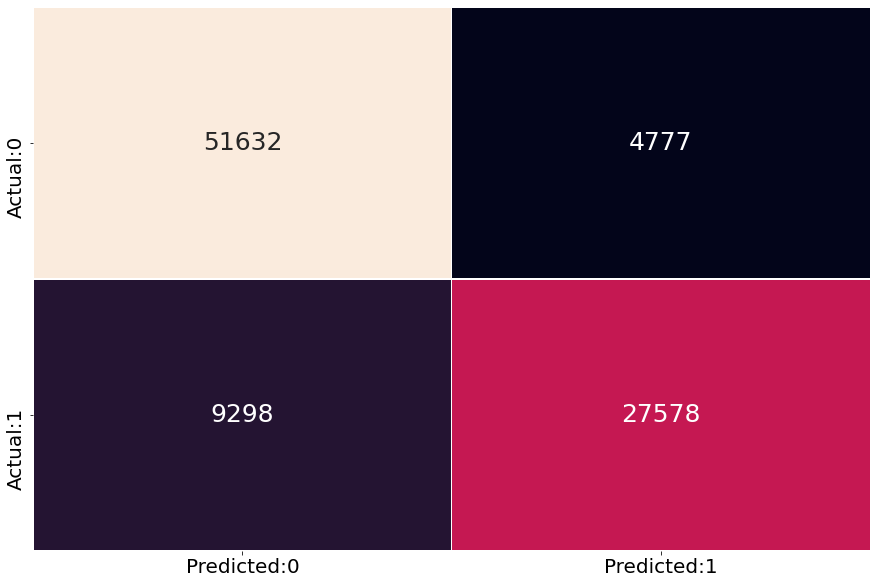

Wall time: 282 ms


In [20]:
%%time
# create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# label the confusion matrix  
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

# plot a heatmap to visualize the confusion matrix
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

# set the font size of x-axis ticks using 'fontsize'
plt.xticks(fontsize = 20)

# set the font size of y-axis ticks using 'fontsize'
plt.yticks(fontsize = 20)

# display the plot
plt.show()

#### Compute the performance measures.

In [21]:
%%time
# True Negatives are denoted by 'TN'
# Actual 'O' values which are classified correctly
TN = cm[0,0]

# True Positives are denoted by 'TP'
# Actual '1' values which are classified correctly
TP = cm[1,1]

# False Positives are denoted by 'FP'
# it is the type 1 error
# Actual 'O' values which are classified wrongly as '1'
FP = cm[0,1]

# False Negatives are denoted by 'FN'
# it is the type 2 error
# Actual '1' values which are classified wrongly as '0'
FN = cm[1,0]


# calculate the precision value
precision = TP / (TP+FP)
print('precision:',precision)

# calculate the recall value
recall = TP / (TP+FN)
# print the value
print('recall:',recall)

# calculate the specificity value
specificity = TN / (TN+FP)
# print the value
print('specificity:',specificity)

# calculate the FPR value (1-Specificity)
FPR = FP / (FP+TN)
# print the value
print('False positive rate:',FPR)

precision: 0.8523566682120228
recall: 0.7478576852153161
specificity: 0.9153149320143948
False positive rate: 0.08468506798560513


In [22]:
%%time
# performance measures obtained by classification_report()
result = classification_report(y_test, y_pred)

# print the result
print(result)

              precision    recall  f1-score   support

           0       0.85      0.92      0.88     56409
           1       0.85      0.75      0.80     36876

    accuracy                           0.85     93285
   macro avg       0.85      0.83      0.84     93285
weighted avg       0.85      0.85      0.85     93285

Wall time: 176 ms


In [23]:
%%time
# compute the kappa value
kappa = cohen_kappa_score(y_test, y_pred)

# print the kappa value
print('kappa value:',kappa)

kappa value: 0.6775548296780214
Wall time: 127 ms


#### Plot the ROC curve.

Wall time: 135 ms


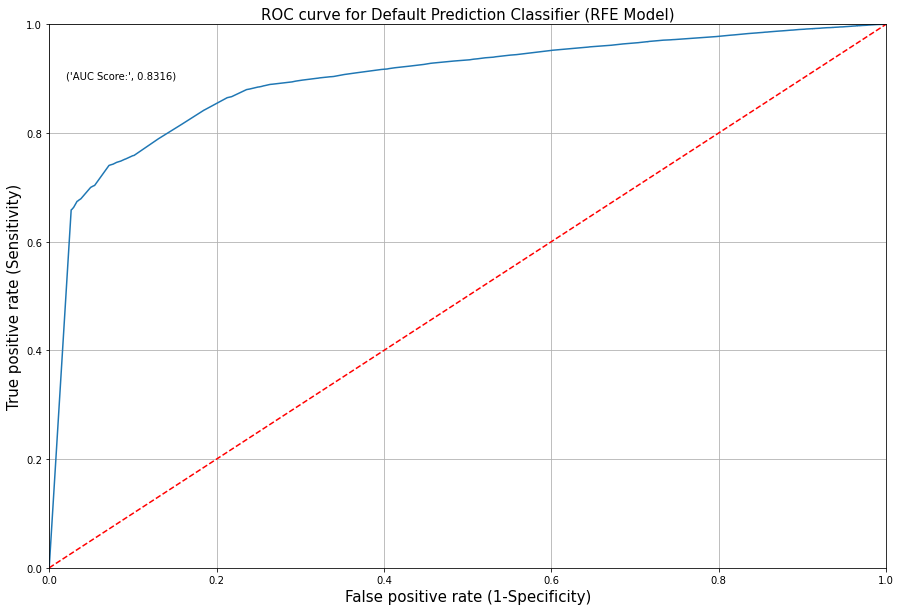

In [32]:
%%time
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# plot the ROC curve
plt.plot(fpr, tpr)

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Default Prediction Classifier (RFE Model)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, y_pred),4)))
                               
# plot the grid
plt.grid(True)

#### Build the model using significant features obtained from RFE

In [25]:
%%time
# instantiate the 'LogisticRegression'
model_LR = LogisticRegression(random_state=10)

# fit the model using fit() on train data
model_LR = model_LR.fit(X_train[best_features_LR] , y_train)

Wall time: 2.48 s


#### Tune the Hyperparameters using GridSearchCV (Logistic Regression)

In [18]:
%%time
# create a dictionary with hyperparameters and its values
tuned_paramaters = [{'penalty': ['l1', 'l2'], 
                     'C': np.logspace(0, 4, 10)}]
 
# use GridSearchCV() to find the optimal value of the hyperparameters
grid_logreg = GridSearchCV(estimator = model_LR, 
                         param_grid = tuned_paramaters, 
                         cv = 5,
                         verbose=0,
                         n_jobs=-1)

# fit the model on X_train and y_train using fit()
grid_model_logreg = grid_logreg.fit(X_train[best_features_LR], y_train)

# get the best parameters
print('Best parameters for decision tree classifier: ', grid_model_logreg.best_params_, '\n')

Best parameters for decision tree classifier:  {'C': 1.0, 'penalty': 'l2'} 

Wall time: 1min 1s


#### Build the model using the tuned hyperparameters.

In [19]:
%%time
# instantiate the 'LogisticRegression'
model_LR = LogisticRegression( penalty = grid_model_logreg.best_params_.get('penalty'),
                                C = grid_model_logreg.best_params_.get('C'))

# fit the model using fit() on train data
model_LR = model_LR.fit(X_train[best_features_LR],y_train)

Wall time: 3.24 s


#### Model Performance

In [20]:
%%time
print('Training set score: ' + str(model_LR.score(X_train[best_features_LR], y_train)))
print('Test set score: ' + str(model_LR.score(X_test[best_features_LR], y_test))) 

Training set score: 0.8499157146034835
Test set score: 0.8487430991048937
Wall time: 205 ms


#### Model Evaluation

In [21]:
%%time
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_LR, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Mean ROC AUC:", np.mean(scores))

Mean ROC AUC: 0.8993102845577502
Wall time: 1min 4s


# ---------------------------------------------------------------------------------------------------------------

## DECISION TREE

In [30]:
# read the dataset
df_application_VIF = pd.read_csv('df_VIF_num_scaled.csv')

#### Obtain top 30 significant features

In [31]:
%%time
''' RFE '''
# select independent variables
X = df_application_VIF.drop('TARGET', axis = 1)
 
# select dependent variable
y = df_application_VIF['TARGET']

# split data into train subset and test subset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.2)

# initiate DecisionTreeClassifier model to use in feature selection
rfe_DT = DecisionTreeClassifier()

# build the RFE model
rfe_model = RFE(estimator = rfe_DT, n_features_to_select=30)

# fit the RFE model on the training dataset using fit()
rfe_model = rfe_model.fit(X_train, y_train)

# create a series containing feature and its corresponding rank obtained from RFE
feat_index = pd.Series(data = rfe_model.ranking_, index = X_train.columns)

# select the features with rank = 1
best_features_DT = feat_index[feat_index==1].index

# print the significant features obtained from RFE
print("Top features selected by DecisionTreeClassifier:", best_features_DT, sep='\n')

Top features selected by DecisionTreeClassifier:
Index(['SCORE_REGION', 'NAME_EDUCATION_TYPE', 'HOUR_APPR_PROCESS_START',
       'RATIO_DAYSIDPUBLISH_DAYSBIRTH', 'DAYS_REGISTRATION',
       'RATIO_AMTANNUITY_AMTINCOMETOTAL', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'REGION_POPULATION_RELATIVE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'RATIO_DAYSEMPLOYED_DAYSBIRTH', 'AMT_REQ_CREDIT_BUREAU_MON',
       'RATIO_AMTCREDIT_AMTGOODSPRICE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'RATIO_AMTINCOMETOTAL_DAYSEMPLOYED', 'RATIO_AMTCREDIT_AMTANNUITY',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'SCORE_DOCUMENT_SUBMISSION',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_OWN_CAR',
       'WEEKDAY_APPR_PROCESS_START_dummy_SATURDAY',
       'WEEKDAY_APPR_PROCESS_START_dummy_THURSDAY',
       'WEEKDAY_APPR_PROCESS_START_dummy_TUESDAY',
       'WEEKDAY_APPR_PROCESS_START_dummy_WEDNESDAY',
       'OCCUPATION_TYPE_dummy_Low_skill_staff',
       'OCCUPATION_TYPE_dummy_Sales staff', 'ORGANIZATION_TYPE_dummy_Official',
       'CATEGORY

#### Build the model using significant features obtained from RFE

In [32]:
%%time
# select independent variables
X = df_application_VIF.drop('TARGET', axis = 1)
 
# select dependent variable
y = df_application_VIF['TARGET']

# split data into train subset and test subset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.2)

# instantiate the 'DecisionTreeClassifier'
model_DT = DecisionTreeClassifier(random_state=10)

# fit the model using fit() on train data
model_DT = model_DT.fit(X_train[best_features_DT] , y_train)

Wall time: 11.5 s


#### Tune the Hyperparameters using GridSearchCV (Decision Tree)

In [33]:
%%time
# create a dictionary with hyperparameters and its values
tuned_paramaters = [{'criterion': ['entropy', 'gini'], 
                     'max_depth': range(2, 10),
                     'max_features': ["sqrt", "log2"]}]
 
# use GridSearchCV() to find the optimal value of the hyperparameters
grid_tree = GridSearchCV(estimator = model_DT, 
                         param_grid = tuned_paramaters, 
                         cv = 5,
                         verbose=0,
                         n_jobs=-1)

# fit the model on X_train and y_train using fit()
grid_model_tree = grid_tree.fit(X_train[best_features_DT], y_train)

# get the best parameters
print('Best parameters for decision tree classifier: ', grid_model_tree.best_params_, '\n')

Best parameters for decision tree classifier:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt'} 

Wall time: 48.9 s


#### Build the model using the tuned hyperparameters.

In [34]:
%%time
# instantiate the 'DecisionTreeClassifier'
model_DT = DecisionTreeClassifier(criterion = grid_model_tree.best_params_.get('criterion'),
                                  max_depth = grid_model_tree.best_params_.get('max_depth'),
                                  max_features = grid_model_tree.best_params_.get('max_features'))

# fit the model using fit() on train data
model_DT = model_DT.fit(X_train[best_features_DT],y_train)

Wall time: 1.11 s


#### Visualize top 30 Important Features

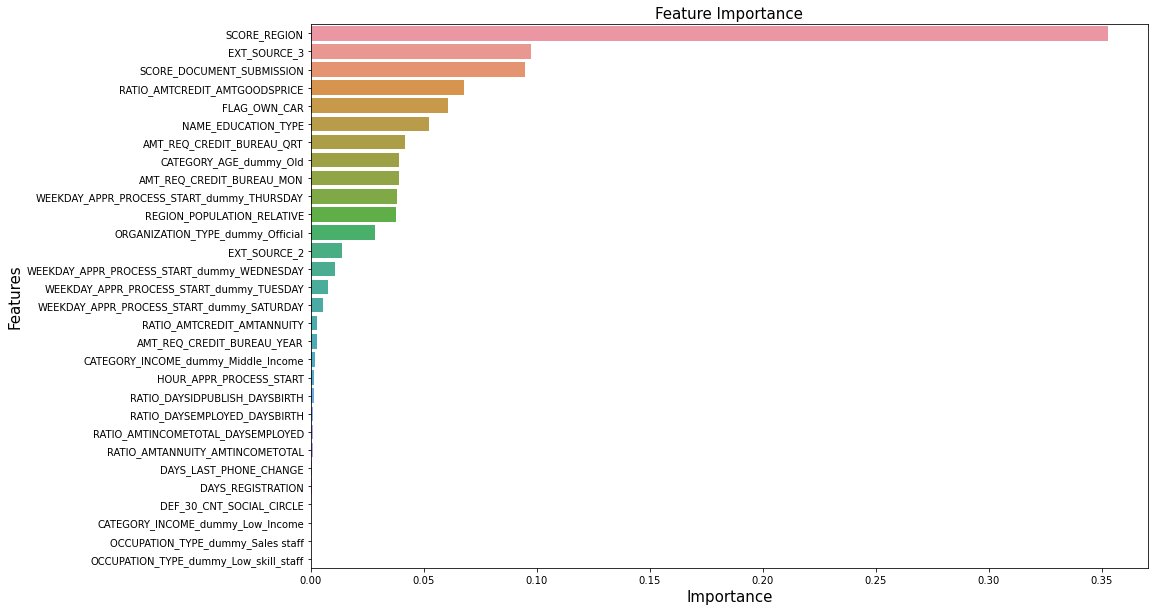

Wall time: 527 ms


In [35]:
%%time
# create a dataframe that stores the feature names and their importance
# 'feature_importances_' returns the features based on the gini importance
important_features = pd.DataFrame({'Features': X_train[best_features_DT].columns, 
                                   'Importance': model_DT.feature_importances_})

# sort the dataframe in the descending order according to the feature importance
important_features = important_features.sort_values('Importance', ascending = False)

# create a barplot to visualize the features based on their importance
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

# display the plot
plt.show()

#### Plot the decision tree

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.483503 to fit

Wall time: 6.42 s


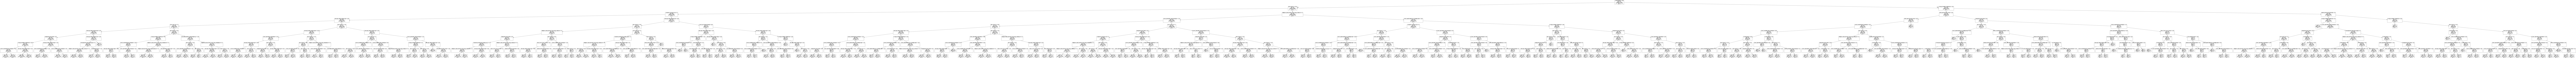

In [36]:
%%time
# save the column names in 'labels'
labels = X_train[best_features_DT].columns

# export a decision tree in DOT format
dot_data = tree.export_graphviz(model_DT, feature_names = labels, class_names = ["0","1"])  

# plot the decision tree using DOT format in 'dot_data'
graph = pydotplus.graph_from_dot_data(dot_data)  

# display the decision tree
Image(graph.create_png())

# double-click on the image below to get an expanded view

#### Model Performance

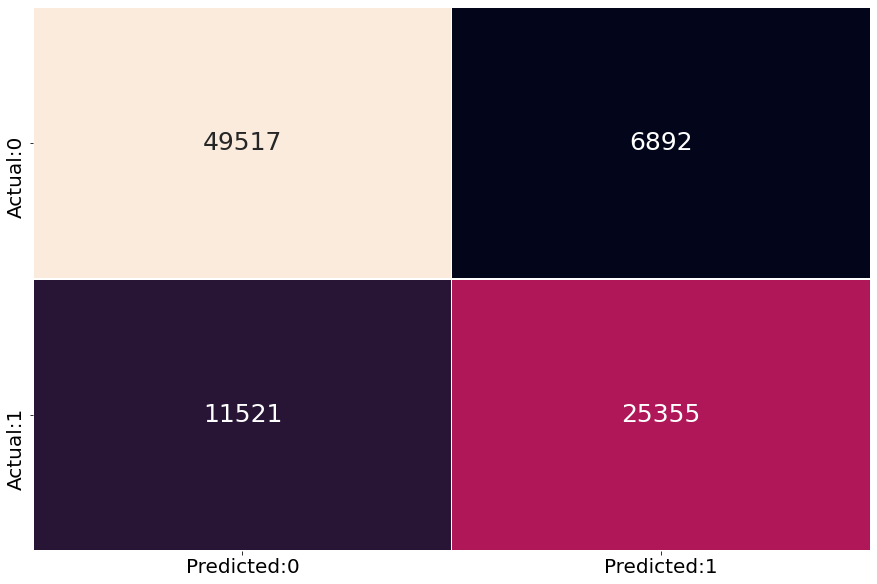

Wall time: 219 ms


In [37]:
%%time
y_pred = model_DT.predict(X_test[best_features_DT])
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [38]:
%%time
# performance measures obtained by classification_report()
result = classification_report(y_test, y_pred)
print(result)

              precision    recall  f1-score   support

           0       0.81      0.88      0.84     56409
           1       0.79      0.69      0.73     36876

    accuracy                           0.80     93285
   macro avg       0.80      0.78      0.79     93285
weighted avg       0.80      0.80      0.80     93285

Wall time: 135 ms


In [39]:
%%time
# compute the kappa value
kappa = cohen_kappa_score(y_test, y_pred)

# print the kappa value
print('kappa value:',kappa)

kappa value: 0.5779566329477557
Wall time: 76.8 ms


In [40]:
%%time
print('Training set score: ' + str(model_DT.score(X_train[best_features_DT],y_train)))
print('Test set score: ' + str(model_DT.score(X_test[best_features_DT],y_test))) 

Training set score: 0.8048652371649019
Test set score: 0.8026156402422683
Wall time: 205 ms


#### Model Evaluation

In [41]:
%%time
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_DT, X_train[best_features_DT], y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Mean ROC AUC:", np.mean(scores))

Mean ROC AUC: 0.8681984902061501
Wall time: 14.8 s


# ---------------------------------------------------------------------------------------------------------------

## RANDOM FOREST

In [4]:
# read the dataset
df_application_VIF = pd.read_csv('df_VIF_num_scaled.csv')

#### Obtain top 30 significant features

In [5]:
%%time
''' RFE '''
# select independent variables
X = df_application_VIF.drop('TARGET', axis = 1)
 
# select dependent variable
y = df_application_VIF['TARGET']

# split data into train subset and test subset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.2)

# initiate RandomForestClassifier model to use in feature selection
rfe_RF = RandomForestClassifier()

# build the RFE model
rfe_model = RFE(estimator = rfe_RF, n_features_to_select=30)

# fit the RFE model on the training dataset using fit()
rfe_model = rfe_model.fit(X_train, y_train)

# create a series containing feature and its corresponding rank obtained from RFE
feat_index = pd.Series(data = rfe_model.ranking_, index = X_train.columns)

# select the features with rank = 1
best_features_RF = feat_index[feat_index==1].index

# print the significant features obtained from RFE
print("Top features selected by RandomForestClassifier:", best_features_RF, sep='\n')

Top features selected by RandomForestClassifier:
Index(['SCORE_REGION', 'NAME_EDUCATION_TYPE', 'HOUR_APPR_PROCESS_START',
       'RATIO_DAYSIDPUBLISH_DAYSBIRTH', 'DAYS_REGISTRATION',
       'RATIO_AMTANNUITY_AMTINCOMETOTAL', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'REGION_POPULATION_RELATIVE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'RATIO_DAYSEMPLOYED_DAYSBIRTH', 'AMT_REQ_CREDIT_BUREAU_MON',
       'RATIO_AMTCREDIT_AMTGOODSPRICE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'RATIO_AMTINCOMETOTAL_DAYSEMPLOYED', 'RATIO_AMTCREDIT_AMTANNUITY',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'SCORE_DOCUMENT_SUBMISSION',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_OWN_CAR', 'FLAG_PHONE',
       'WEEKDAY_APPR_PROCESS_START_dummy_MONDAY',
       'WEEKDAY_APPR_PROCESS_START_dummy_SATURDAY',
       'WEEKDAY_APPR_PROCESS_START_dummy_THURSDAY',
       'WEEKDAY_APPR_PROCESS_START_dummy_TUESDAY',
       'WEEKDAY_APPR_PROCESS_START_dummy_WEDNESDAY',
       'ORGANIZATION_TYPE_dummy_Official', 'CATEGORY_AGE_dummy_Old',
       'CAT

#### Build the model using significant features obtained from RFE

In [6]:
%%time
# select independent variables
X = df_application_VIF.drop('TARGET', axis = 1)
 
# select dependent variable
y = df_application_VIF['TARGET']

# split data into train subset and test subset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.2)

# instantiate the 'RandomForestClassifier'
model_RF = RandomForestClassifier(random_state=10)

# fit the model using fit() on train data
model_RF = model_RF.fit(X_train[best_features_RF] , y_train)

Wall time: 2min 20s


#### Tune the Hyperparameters using GridSearchCV (Random Forest)

In [7]:
%%time
# create a dictionary with hyperparameters and its values
tuned_paramaters = [{'criterion': ['gini'],
                     'n_estimators': [10, 30, 50, 70, 90],
                     'max_depth': range(2, 10),
                     'max_features': ["sqrt", "log2"]}]
 
# use GridSearchCV() to find the optimal value of the hyperparameters
grid_forest = GridSearchCV(estimator = model_RF, 
                         param_grid = tuned_paramaters, 
                         cv = 5,
                         verbose=0,
                         n_jobs=-1)

# fit the model on X_train and y_train using fit()
grid_model_forest = grid_forest.fit(X_train[best_features_RF], y_train)

# get the best parameters
print('Best parameters for random forest classifier: ', grid_model_forest.best_params_, '\n')

Best parameters for random forest classifier:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 70} 

Wall time: 58min 51s


#### Build the model using the tuned hyperparameters.

In [8]:
%%time
# instantiate the 'RandomForestClassifier'
model_RF = RandomForestClassifier(criterion = grid_model_forest.best_params_.get('criterion'),
                                  n_estimators = grid_model_forest.best_params_.get('n_estimators'),
                                  max_depth = grid_model_forest.best_params_.get('max_depth'),
                                  max_features = grid_model_forest.best_params_.get('max_features'))

# fit the model using fit() on train data
model_RF = model_RF.fit(X_train[best_features_RF],y_train)

Wall time: 41.9 s


#### Visualize top 30 Important Features

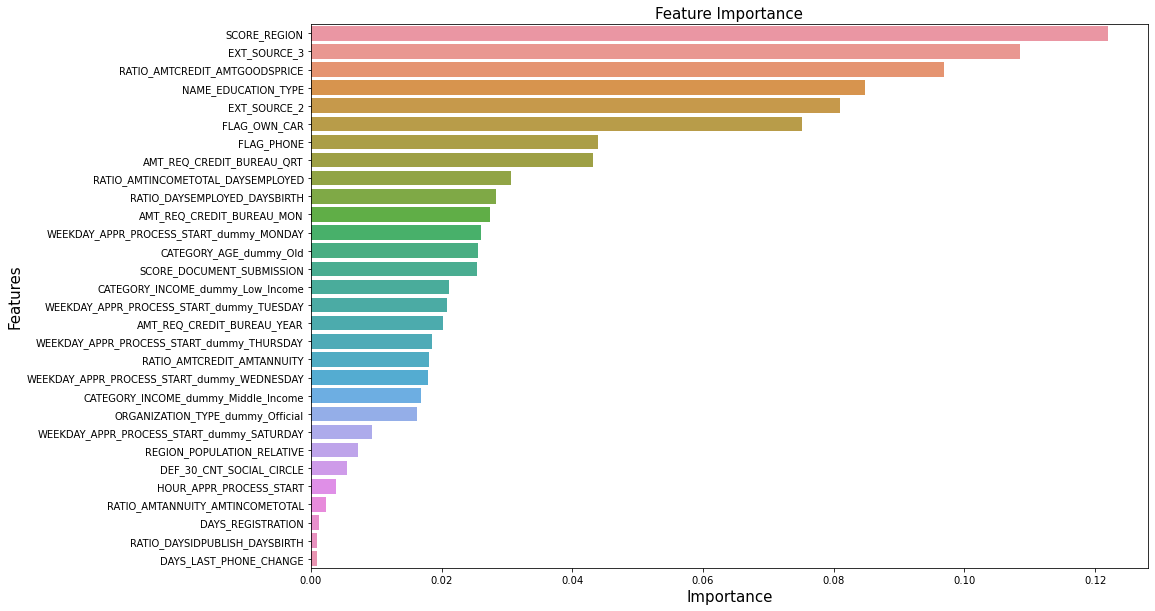

Wall time: 607 ms


In [9]:
%%time
# create a dataframe that stores the feature names and their importance
# 'feature_importances_' returns the features based on the gini importance
important_features = pd.DataFrame({'Features': X_train[best_features_RF].columns, 
                                   'Importance': model_RF.feature_importances_})

# sort the dataframe in the descending order according to the feature importance
important_features = important_features.sort_values('Importance', ascending = False)

# create a barplot to visualize the features based on their importance
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

# display the plot
plt.show()

#### Model Performance

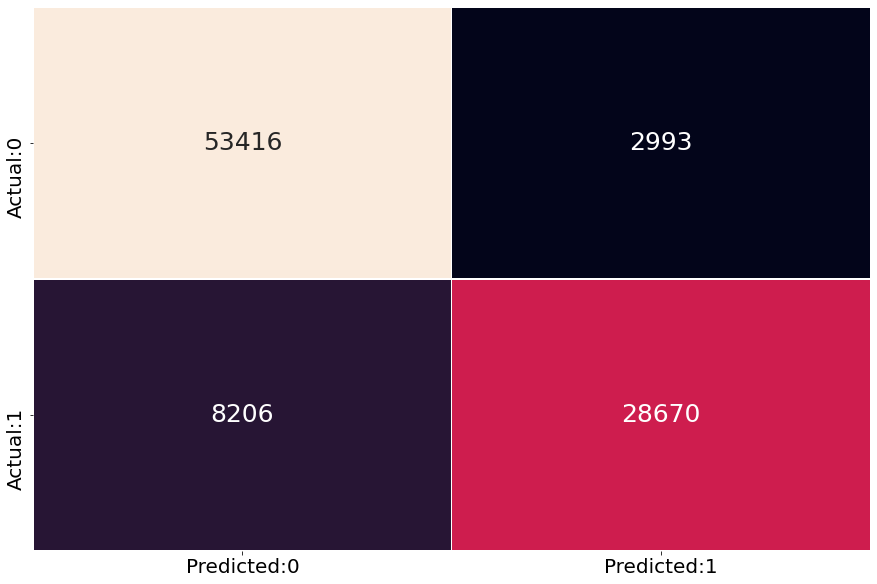

Wall time: 928 ms


In [27]:
%%time
y_pred = model_RF.predict(X_test[best_features_RF])
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [28]:
%%time
# performance measures obtained by classification_report()
result = classification_report(y_test, y_pred)
print(result)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     56409
           1       0.91      0.78      0.84     36876

    accuracy                           0.88     93285
   macro avg       0.89      0.86      0.87     93285
weighted avg       0.88      0.88      0.88     93285

Wall time: 133 ms


In [29]:
%%time
# compute the kappa value
kappa = cohen_kappa_score(y_test, y_pred)

# print the kappa value
print('kappa value:',kappa)

kappa value: 0.7425868379436178
Wall time: 87.8 ms


In [10]:
%%time
print('Training set score: ' + str(model_RF.score(X_train[best_features_RF],y_train)))
print('Test set score: ' + str(model_RF.score(X_test[best_features_RF],y_test))) 

Training set score: 0.880405856294069
Test set score: 0.8799485447821193
Wall time: 3.73 s


#### Model Evaluation

In [11]:
%%time
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_RF, X_train[best_features_RF], y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Mean ROC AUC:", np.mean(scores))

Mean ROC AUC: 0.9352877807742559
Wall time: 8min 37s


## XGBOOST

In [12]:
# read the dataset
df_application_VIF = pd.read_csv('df_VIF_num_scaled.csv')

In [13]:
%%time
''' RFE '''

# select independent variables
X = df_application_VIF.drop('TARGET', axis = 1)
 
# select dependent variable
y = df_application_VIF['TARGET']

# split data into train subset and test subset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.2)

# initiate XGBClassifier model to use in feature selection
rfe_xgb = XGBClassifier(verbosity = 0)

# build the RFE model
rfe_model = RFE(estimator = rfe_xgb, n_features_to_select=30)

# fit the RFE model on the training dataset using fit()
rfe_model = rfe_model.fit(X_train, y_train)

# create a series containing feature and its corresponding rank obtained from RFE
feat_index = pd.Series(data = rfe_model.ranking_, index = X_train.columns)

# select the features with rank = 1
best_features_XGB = feat_index[feat_index==1].index

# print the significant features obtained from RFE
print("Top features selected by XGBoost Classifiaction:", best_features_XGB, sep='\n')

Top features selected by XGBoost Classifiaction:
Index(['SCORE_REGION', 'NAME_EDUCATION_TYPE', 'HOUR_APPR_PROCESS_START',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'AMT_REQ_CREDIT_BUREAU_MON', 'RATIO_AMTCREDIT_AMTGOODSPRICE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'SCORE_DOCUMENT_SUBMISSION', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FLAG_PHONE', 'NAME_TYPE_SUITE_dummy_Family',
       'NAME_INCOME_TYPE_dummy_State servant',
       'WEEKDAY_APPR_PROCESS_START_dummy_MONDAY',
       'WEEKDAY_APPR_PROCESS_START_dummy_SATURDAY',
       'WEEKDAY_APPR_PROCESS_START_dummy_SUNDAY',
       'WEEKDAY_APPR_PROCESS_START_dummy_THURSDAY',
       'WEEKDAY_APPR_PROCESS_START_dummy_TUESDAY',
       'WEEKDAY_APPR_PROCESS_START_dummy_WEDNESDAY',
       'OCCUPATION_TYPE_dummy_Core staff',
       'OCCUPATION_TYPE_dummy_Low_skill_staff',
       'OCCUPATION_TYPE_dummy_Sales staff',
       'ORGANIZATION_TYPE_dummy_Education', 'ORGANIZATION_TYPE

#### Build the model using significant features obtained from RFE

In [14]:
%%time
# select independent variables
X = df_application_VIF.drop('TARGET', axis = 1)
 
# select dependent variable
y = df_application_VIF['TARGET']

# split data into train subset and test subset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.2)

model_xgb = XGBClassifier(max_depth = 10, gamma = 1, verbosity = 0)

# fit the model using fit() on train data
model_xgb= model_xgb.fit(X_train, y_train)

# fit the model using fit() on train data
model_xgb = model_xgb.fit(X_train[best_features_XGB] , y_train)

Wall time: 3min 16s


#### Tune the Hyperparameters using GridSearchCV (XG Boost)

In [15]:
%%time
tuning_parameters = {'learning_rate': [0.1, 0.01, 0.05],
                     'max_depth': range(3,10,2),
                     'gamma': [0, 1, 2, 3, 4]}
model_xgb = XGBClassifier(verbosity = 0)
xgb_grid = GridSearchCV(estimator = model_xgb, param_grid = tuning_parameters, cv = 3, scoring = 'roc_auc')
xgb_grid.fit(X_train[best_features_XGB], y_train)

# get the best parameters
print('Best parameters for XGBoost classifier: ', xgb_grid.best_params_, '\n')

Best parameters for XGBoost classifier:  {'gamma': 4, 'learning_rate': 0.1, 'max_depth': 9} 

Wall time: 1h 12min 21s


#### Build the model using the tuned hyperparameters.

In [16]:
%%time
# instantiate the 'XGBClassifier'
model_xgb =  XGBClassifier(gamma = xgb_grid.best_params_.get('gamma'),
                                  learning_rate = xgb_grid.best_params_.get('learning_rate'),
                                  max_depth = xgb_grid.best_params_.get('max_depth'))

# fit the model using fit() on train data
model_xgb = model_xgb.fit(X_train[best_features_XGB],y_train)

Wall time: 54.6 s


#### Visualize top 30 Important Features

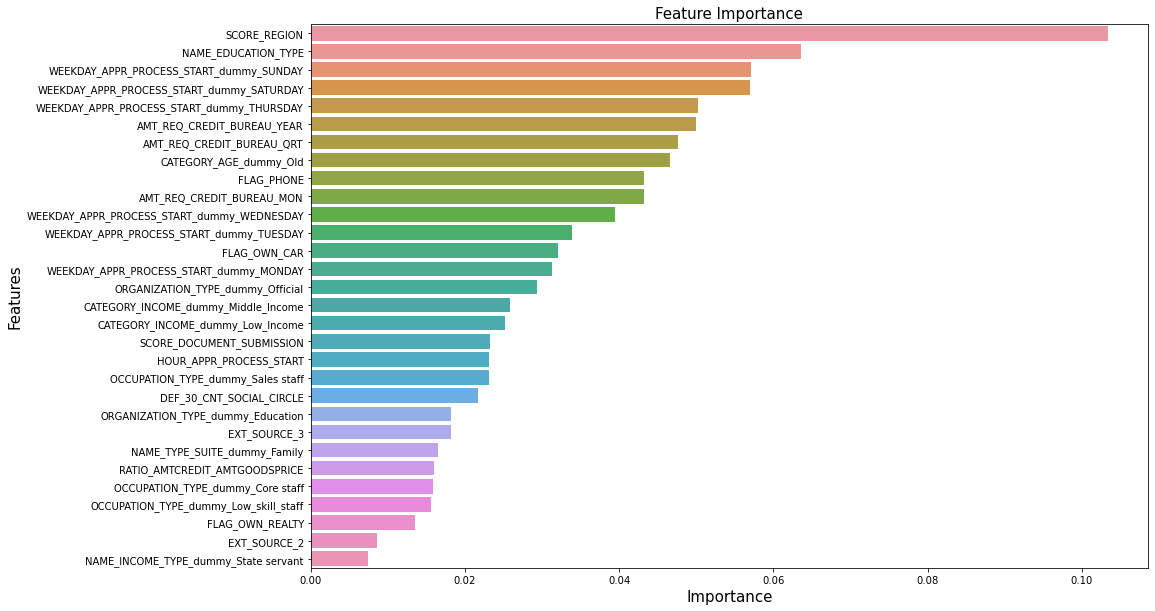

Wall time: 747 ms


In [17]:
%%time
# create a dataframe that stores the feature names and their importance
# 'feature_importances_' returns the features based on the gini importance
important_features = pd.DataFrame({'Features': X_train[best_features_XGB].columns, 
                                   'Importance': model_xgb.feature_importances_})

# sort the dataframe in the descending order according to the feature importance
important_features = important_features.sort_values('Importance', ascending = False)

# create a barplot to visualize the features based on their importance
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

# display the plot
plt.show()

#### Model Performance

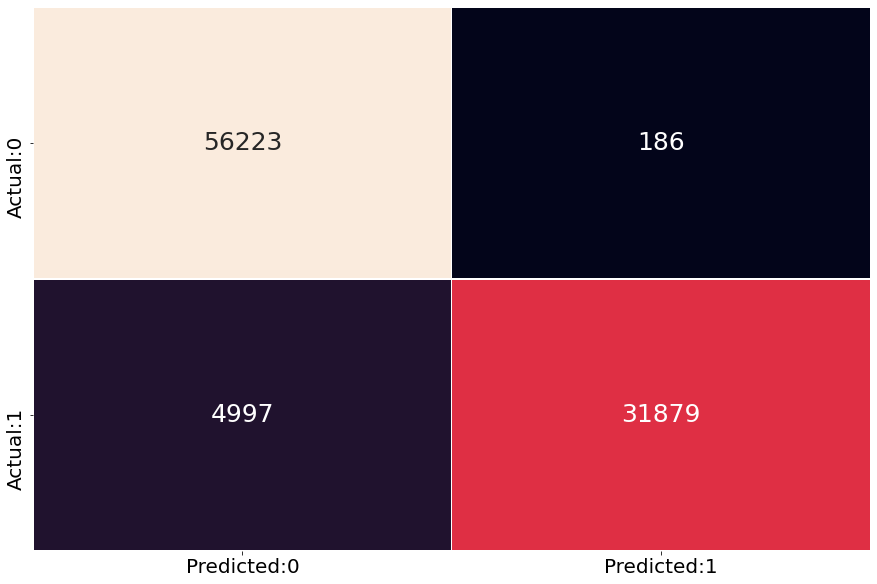

Wall time: 485 ms


In [18]:
%%time
y_pred = model_xgb.predict(X_test[best_features_XGB])
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [19]:
%%time
# performance measures obtained by classification_report()
result = classification_report(y_test, y_pred)
print(result)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56409
           1       0.99      0.86      0.92     36876

    accuracy                           0.94     93285
   macro avg       0.96      0.93      0.94     93285
weighted avg       0.95      0.94      0.94     93285

Wall time: 121 ms


In [20]:
%%time
# compute the kappa value
kappa = cohen_kappa_score(y_test, y_pred)

# print the kappa value
print('kappa value:',kappa)

kappa value: 0.8810968787287745
Wall time: 66.9 ms


#### Plot the ROC curve

Wall time: 51.9 ms


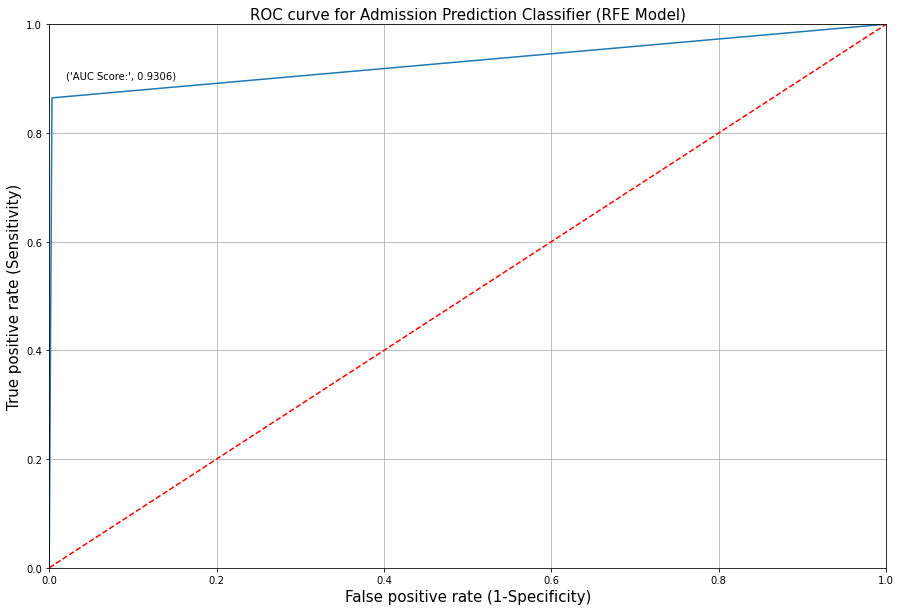

In [21]:
%%time
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot the ROC curve
plt.plot(fpr, tpr)

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Admission Prediction Classifier (RFE Model)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, y_pred),4)))
                               
# plot the grid
plt.grid(True)

In [22]:
print('Training set score: ' + str(model_xgb.score(X_train[best_features_XGB],y_train)))
print('Test set score: ' + str(model_xgb.score(X_test[best_features_XGB],y_test))) 

Training set score: 0.9462690647134967
Test set score: 0.9444390845259152


#### Model Evaluation

In [23]:
%%time
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_xgb, X_train[best_features_XGB], y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Mean ROC AUC:", np.mean(scores))

Mean ROC AUC: 0.9616813220603285
Wall time: 23min 34s
